#### Summary:
Now that we've performed gene, peak and motif trait associations, I plan to combine these results together and look for common patterns and good examples. The simplest thing to do here would just be to find some examples of links where the cRE and gene have concordant association with a trait (and also a trait associated motif if possible). Not totally sure how well that'll go. Additionally, we can use the links to create TF modules (what Rebecca has done) and perform some basic tests for these in differential expression results to provide evidence of the TF responsible for changes. Finally, we could consider more sophisticated networks based approaches, but I think that'll turn into a black hole project, so avoiding for now.

In [31]:
suppressMessages(library(dplyr)) 
suppressMessages(library(tidyr)) 
suppressMessages(library(Matrix)) 
suppressMessages(library(data.table))
suppressMessages(library(future)) 
suppressMessages(library(stringr))
suppressMessages(library(stringi))
suppressMessages(library(readr))
#suppressMessages(library(meta))

suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr)) 
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(shadowtext))
suppressMessages(library(forcats))

suppressMessages(library(DESeq2))
suppressMessages(library(fgsea))
suppressMessages(library(parallel))
#suppressMessages(library(bettermc))
suppressMessages(library(qvalue))
suppressPackageStartupMessages(library(clustifyr))

In [24]:
# BiocManager::install("rWikiPathways")
library(rWikiPathways)

# Basic Inputs

In [2]:
#only ran links and ATAC on larger cell types
joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal')
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B',
            '#F5DE6C', '#752BBA', '#F598C9','#FDBB84')
names(colors) <- joint_celltypes
colors

beta     alpha     delta     gamma    acinar    ductal      <NA>      <NA> 
"#3F98E0" "#F51646" "#E39E14" "#A1D99B" "#09850B" "#F5DE6C" "#752BBA" "#F598C9" 
     <NA> 
"#FDBB84"

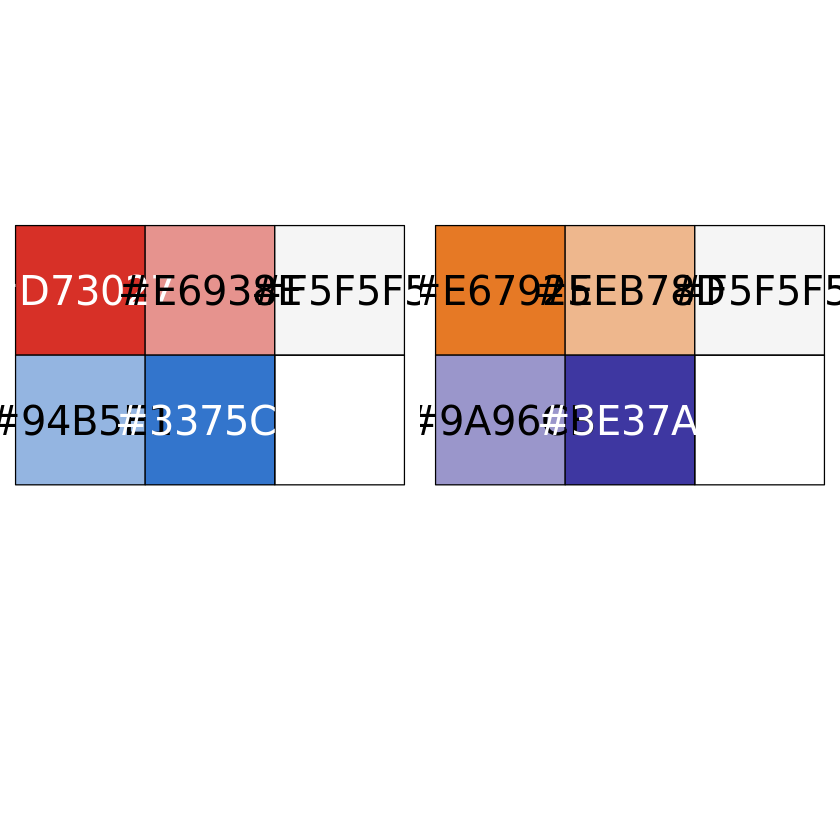

In [3]:
#make RNA and ATAC specific diverging color palettes
# rna_pal <- c('#4B9D72','#B6D499','#FFEADA','#FFACA3','#FF6959') #custom rg pallete
# atac_pal <- c('#3B5B8E','#99CAD9','#FBFFDC','#FFD396','#F59851') #custom by pallete
# atac_pal2 <- c('#38B1D6','#99CAD9','#FBFFDC','#FFD396','#F59851') #custom by pallete
# atac_pal3 <- c('#3E37A1','#9F97BE','#FCFAE1','#F3B880','#E67925') #custom by pallete
rna_pal <- c('#D73027','#E6938E','#F5F5F5','#94B5E1','#3375CC')
atac_pal <- c('#E67925','#EEB78D','#F5F5F5','#9A96CB','#3E37A1')

par(mfrow=c(1,2))
scales::show_col(rna_pal, cex_label=2)
scales::show_col(atac_pal, cex_label=2)

In [4]:
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations'
links_outdir <- file.path(outdir,'combo_results','240613_new_ChromVAR_results')

## Data file paths

In [5]:
#Gene-trait association results
rna_dir <- file.path(outdir,'RNA','REM_meta')

In [6]:
#Peak-trait association results
atac_dir <- file.path(outdir,'ATAC','DESeq')

In [7]:
#Motif-trait association results
#ChromVAR
chromvar_dir <- '/nfs/lab/welison/islet_multiome/intermediates/chromVAR'

#HOMER
homer_dir <- file.path(outdir,'ATAC','HOMER')

In [8]:
#Links
link_overlap_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/231211_links_summary/'
#link_overlap_suffix <- '_all_methods_links.wHeader.bedpe'
link_overlap_suffix <- '_all_methods_links.wHeader.wUnionPeaks.bedpe'

In [9]:
# Motif matches in cREs matrix
motif_match_fp <- '/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240322_WE_MotifMatches_Union_Peaks.RDS'
motifs <- readRDS(motif_match_fp)
#head(motifs)

In [10]:
library(dplyr)

## Map cRE-gene links cRE coordinates to union peaks!!!

In [69]:
union_peaks_fp <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/240304_union_peaks/union_peaks.sort.bed'

In [70]:
celltype <- 'beta'

In [77]:
for (celltype in joint_celltypes){
    print(celltype)
    #read in links
    links_fp <- paste0(link_overlap_dir,celltype,link_overlap_suffix)
    links <- read.table(links_fp, sep='\t',header=TRUE)
    print(dim(links))
    
    #write cRE coords to a bed file for overlap
    links_fp <- file.path(link_overlap_dir, sprintf('%s_all_methods_links_cREs.bed',celltype))
    links_cres <- links %>% select(chr,start,end) %>% distinct()
    write.table(links_cres, links_fp, sep='\t', row.names=F, col.names=F, quote=F)

    #do overlap and read in result
    map_fp <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/240304_union_peaks/celltype_union_peaks/%s.union_peaks.LINKS_MAP.bed',celltype)
    cmd <- sprintf('bedtools intersect -a %s -b %s -wa -wb -loj > %s', links_fp, union_peaks_fp, map_fp)
    system(cmd)
    map <- read.table(map_fp, sep='\t')
    colnames(map) <- c('chr','start','end','chr1','start1','end1','union_peak')

    #summarize how many cREs get mapped to multiple union peaks -- many!
    map2 <- map %>% mutate(ct_cre=paste(chr,start,end,sep='-'), union_cre=paste(chr1,start1,end1,sep='-')) %>%
                group_by(ct_cre) %>% mutate(num_union_peaks=length(unique(union_peak)))
    print(table(map2$num_union_peaks))
    
    #map links cre coords to union peaks, clean up and write to file
    links2 <- left_join(links, map, by=c('chr','start','end'))
    links2 <- links2 %>% select(-chr,-start,-end,-union_peak) %>%
                relocate(chr1,start1,end1) %>% rename(chr=chr1,start=start1,end=end1) %>%
                subset(!is.na(chr)) %>% distinct()
    print(dim(links2))
    out_fp <- paste0(link_overlap_dir, sprintf('%s_all_methods_links.wHeader.wUnionPeaks.bedpe',celltype))
    write.table(links2, out_fp, sep='\t', row.names=F, quote=F)
}

[1] "beta"
[1] 176964     12

    1     2     3     4     5     6     7 
49110 20624  4806   984   195    18     7 
[1] 235695     12
[1] "alpha"
[1] 146583     12

    1     2     3     4     5     6 
40064 17758  4344   968   185    24 
[1] 198157     12
[1] "delta"
[1] 101456     12

    1     2     3     4     5     6     7 
31232 15344  3963   928   195    24     7 
[1] 139522     12
[1] "gamma"
[1] 114697     12

    1     2     3     4     5     6 
29412 14240  3879   936   180    24 
[1] 156556     12
[1] "acinar"
[1] 107450     12

    1     2     3     4     5     6     7 
32065 13618  3519   784   140    12     7 
[1] 148005     12
[1] "ductal"
[1] 184267     12

    1     2     3     4     5     6     7 
44369 16352  4152  1020   150    18     7 
[1] 248476     12


# 1. Approach 1: filter links for cRE-gene pairs with significant and concordant differential activity -- move to another notebook?

In [18]:
### Function to get all motifs within a cre
get_motif_matches <- function(cre, motifs){
    cre_matches <- motifs@assays@data$motifMatches[which(rownames(motifs) == cre),]
    cre_motifs <- colnames(motifs)[which(cre_matches)]
    return(paste(cre_motifs,collapse=','))
}

In [19]:
### Function to combine all the trait association information into one dataframe and apply
### some basic filters to get concordant and sig links associated with the trait
get_concordant_links <- function(celltype, trait, trait2, outdir){
    #read in links, RNA associations, and ATAC associations
    links_fp <- paste0(link_overlap_dir,celltype,link_overlap_suffix)
    links <- as.data.frame(read.table(links_fp, sep='\t',header=TRUE))
    rna_fp <- file.path(rna_dir,trait,sprintf('%s_%s.all_genes_REM_results.txt',celltype,trait))
    rna <- read.table(rna_fp, sep='\t') %>% tibble::rownames_to_column(var='gene')
    atac_fp <- file.path(atac_dir, trait, sprintf('ATAC_deseq_v4.%s.%s.tsv',trait,celltype))
    atac <- read.table(atac_fp, sep='\t') %>% tibble::rownames_to_column(var='cre')

    #modify files for merging and merge
    links_fin <- links %>% mutate(cre=paste(chr,start,end,sep='-')) %>%
                    mutate(link=paste(cre,gene,sep='_')) %>%
                    select(link,cre,gene,max_score,method_str) %>%
                    dplyr::rename(link_max_score=max_score)
    rna_fin <- rna %>% dplyr::rename(rna_effect=effect, rna_pval=pvalue, rna_qval=qvalue) %>%
                    select(gene,rna_effect,rna_pval,rna_qval)
    atac_fin <- atac %>% dplyr::rename(atac_effect=log2FoldChange, atac_pval=pvalue, atac_qval=padj) %>%
                    select(cre, atac_effect, atac_pval, atac_qval)
    data <- left_join(links_fin, rna_fin, by='gene') %>% left_join(atac_fin, by='cre')
    
    #write all this information out before filtering and adding motif info
    print(paste('Number of links we start with:',dim(data)[1]))
    out_fp1 <- file.path(outdir,'links_w_RNA_ATAC_info',sprintf('%s_ALL_links.%s_RNA_ATAC_associations.txt',celltype, trait))
    #write.table(data, out_fp1, sep='\t', row.names=F, quote=F)
    
    #getting motif info is hellishly slow, so will apply some basic filters first!
    data <- data %>% mutate(concordant=ifelse(sign(rna_effect*atac_effect)==1,TRUE,FALSE))
    data2 <- subset(data, rna_pval < 0.2  & atac_pval < 0.2 & concordant==TRUE)
    print(paste('Number of links after permissive filters (p<0.2):',dim(data2)[1]))

    #now also add in motif matches and ChromVAR results
    unique_cres <- data2 %>% select(cre) %>% distinct()
    unique_cres$motif <- sapply(unique_cres$cre, get_motif_matches, motifs)
    print(paste('Number of cREs to map to motifs:',dim(unique_cres)[1]))
    data2 <- left_join(data, unique_cres, by='cre')
    data2 <- data2 %>% tidyr::separate_rows(motif, sep=',')
    
    #add in chromvar results
    # chromvar_fp <- file.path(chromvar_dir,sprintf('240418_WE_%s_lmer_meta_results.tsv',str_to_title(celltype)))
    chromvar_fp <- file.path(chromvar_dir,sprintf('240418_WE_%s_lmer_meta_results_common.tsv',(celltype)))
    chromvar <- read.table(chromvar_fp, sep='\t') %>% subset(trait == trait2) 
    chromvar <- chromvar %>% select(TE.common, lower.common, upper.common, statistic.common, pval.common, qval.common, motif, trait) %>%
                            rename(TE=TE.common, lower=lower.common, upper=upper.common, statistic=statistic.common, pval=pval.common, qval=qval.common)
    # chromvar_fin <- chromvar %>% dplyr::rename(motif_effect=TE, motif_pval=pval, motif_qval=qval) %>%
    #                 select(motif,motif_effect,motif_pval,motif_qval)
    chromvar_fin <- chromvar %>% dplyr::rename(motif_effect=TE, motif_pval=pval, motif_qval=qval) %>%
                    select(motif,motif_effect,motif_pval,motif_qval)
    data2 <- left_join(data2, chromvar_fin, by='motif')

    ##apply really basic filters and write to file (motif concordant and p<0.2)
    data2 <- data2 %>% mutate(concordant2=ifelse(sign(motif_effect*atac_effect)==1,TRUE,FALSE))
    data3 <- subset(data2, concordant2==TRUE & motif_pval < 0.2)
    print(paste('Number of links with concordant motif associations:',length(unique(data3$link))))
    out_fp2 <- file.path(outdir,'links_w_RNA_ATAC_motif_info',sprintf('%s_links.%s_RNA_ATAC_motif_associations.CONCORDANT.txt',celltype, trait))
    #write.table(data3, out_fp2, sep='\t', row.names=F, quote=F)

    #apply stricter filters and write to file
    sig_data <- subset(data3, rna_pval < 0.05 & atac_pval < 0.05 & motif_pval < 0.05) %>% arrange(rna_pval, atac_pval, motif_pval) %>% select(-concordant,-concordant2)
    print(paste('Final links with sig (p<0.05) concordant associations:',dim(sig_data)[1]))
    out_fp3 <- file.path(links_outdir,sprintf('%s_links.%s_SIG_RNA_ATAC_motif_associations.txt',celltype, trait))
    write.table(sig_data, out_fp3, sep='\t', row.names=F, quote=F)
}

In [20]:
get_concordant_links('beta','scaled_age','Age',links_outdir)

[1] "Number of links we start with: 235695"
[1] "Number of links after permissive filters (p<0.2): 5823"
[1] "Number of cREs to map to motifs: 4450"
[1] "Number of links with concordant motif associations: 17612"
[1] "Final links with sig (p<0.05) concordant associations: 615"


In [21]:
get_concordant_links('beta','scaled_BMI','BMI',links_outdir)

[1] "Number of links we start with: 235695"
[1] "Number of links after permissive filters (p<0.2): 6031"
[1] "Number of cREs to map to motifs: 4565"
[1] "Number of links with concordant motif associations: 20960"
[1] "Final links with sig (p<0.05) concordant associations: 1577"


In [22]:
get_concordant_links('beta','scaled_HbA1c','HbA1c',links_outdir)

[1] "Number of links we start with: 235695"
[1] "Number of links after permissive filters (p<0.2): 4763"
[1] "Number of cREs to map to motifs: 3862"
[1] "Number of links with concordant motif associations: 10310"
[1] "Final links with sig (p<0.05) concordant associations: 52"


In [23]:
get_concordant_links('beta','sex','Sex',links_outdir)

[1] "Number of links we start with: 235695"
[1] "Number of links after permissive filters (p<0.2): 4043"
[1] "Number of cREs to map to motifs: 3314"
[1] "Number of links with concordant motif associations: 14528"
[1] "Final links with sig (p<0.05) concordant associations: 425"


In [24]:
for(celltype in c('alpha','delta')){
    get_concordant_links(celltype,'scaled_age','Age',links_outdir)
    get_concordant_links(celltype,'scaled_BMI','BMI',links_outdir)
    get_concordant_links(celltype,'scaled_HbA1c','HbA1c',links_outdir)
    get_concordant_links(celltype,'sex','Sex',links_outdir)
}

[1] "Number of links we start with: 198157"
[1] "Number of links after permissive filters (p<0.2): 2073"
[1] "Number of cREs to map to motifs: 1630"
[1] "Number of links with concordant motif associations: 7519"
[1] "Final links with sig (p<0.05) concordant associations: 32"
[1] "Number of links we start with: 198157"
[1] "Number of links after permissive filters (p<0.2): 5282"
[1] "Number of cREs to map to motifs: 3640"
[1] "Number of links with concordant motif associations: 19811"
[1] "Final links with sig (p<0.05) concordant associations: 5393"
[1] "Number of links we start with: 198157"
[1] "Number of links after permissive filters (p<0.2): 4678"
[1] "Number of cREs to map to motifs: 3712"
[1] "Number of links with concordant motif associations: 17576"
[1] "Final links with sig (p<0.05) concordant associations: 239"
[1] "Number of links we start with: 198157"
[1] "Number of links after permissive filters (p<0.2): 4452"
[1] "Number of cREs to map to motifs: 3469"
[1] "Number of lin

Warning message in file(file, "rt"):
“cannot open file '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_meta/scaled_age/gamma_scaled_age.all_genes_REM_results.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [25]:
for(celltype in c('acinar','ductal')){
    get_concordant_links(celltype,'scaled_age','Age',links_outdir)
    get_concordant_links(celltype,'scaled_BMI','BMI',links_outdir)
    get_concordant_links(celltype,'scaled_HbA1c','HbA1c',links_outdir)
    get_concordant_links(celltype,'sex','Sex',links_outdir)
}

[1] "Number of links we start with: 148005"
[1] "Number of links after permissive filters (p<0.2): 2946"
[1] "Number of cREs to map to motifs: 2318"
[1] "Number of links with concordant motif associations: 10579"
[1] "Final links with sig (p<0.05) concordant associations: 544"
[1] "Number of links we start with: 148005"
[1] "Number of links after permissive filters (p<0.2): 3192"
[1] "Number of cREs to map to motifs: 2453"
[1] "Number of links with concordant motif associations: 12625"
[1] "Final links with sig (p<0.05) concordant associations: 483"
[1] "Number of links we start with: 148005"
[1] "Number of links after permissive filters (p<0.2): 2485"
[1] "Number of cREs to map to motifs: 2071"
[1] "Number of links with concordant motif associations: 10776"
[1] "Final links with sig (p<0.05) concordant associations: 802"
[1] "Number of links we start with: 148005"
[1] "Number of links after permissive filters (p<0.2): 2818"
[1] "Number of cREs to map to motifs: 2286"
[1] "Number of li

## Look at significant results to find interesting examples

In [172]:
celltype <- 'beta'
trait2 <- 'scaled_BMI'

In [173]:
#read in concordant links (RNA,ATAC,motif) datatable to help find examples?
combo_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/combo_results/links_w_sig_assocs/'
fp <- file.path(combo_dir,sprintf('%s_links.%s_SIG_RNA_ATAC_motif_associations.txt',celltype,trait2))
df3 <- read.table(fp, sep='\t', header=1)
dim(df3)
head(df3)

[1] 620  15

link                             cre                      gene   
1 chr12-79001429-79001729_SYT1     chr12-79001429-79001729  SYT1   
2 chr6-6678314-6678614_SSR1        chr6-6678314-6678614     SSR1   
3 chr6-143542969-143543266_PHACTR2 chr6-143542969-143543266 PHACTR2
4 chr3-122825036-122825336_HSPBAP1 chr3-122825036-122825336 HSPBAP1
5 chr3-122825036-122825336_HSPBAP1 chr3-122825036-122825336 HSPBAP1
6 chr14-31993454-31993754_STRN3    chr14-31993454-31993754  STRN3  
  link_max_score method_str rna_effect rna_pval     rna_qval   atac_effect
1 0.04747158     hm         -1.0858137 3.120261e-06 0.02618341 -0.3568884 
2 0.02757222     hm         -0.2870712 1.664308e-05 0.04199817 -0.1139059 
3 0.02628200     abc         0.2539657 2.511936e-05 0.04372276  0.3279865 
4 0.01001728     hm          0.4580946 7.310905e-05 0.08565163  0.3638163 
5 0.01001728     hm          0.4580946 7.310905e-05 0.08565163  0.3638163 
6 0.01390110     hm          0.2944834 1.930978e-04 0.12864203  0.3474873 
  atac_pval   atac_qval motif                motif_effect motif_pval  
1 0.001847751 0.2791746 MA0069.1_PAX6        -0.08380039  0.0001799126
2 0.026833606 0.5575203 MA0072.1_RORA        -0.08602732  0.0268537480
3 0.008490360 0.4298090 MA1594.1_ZNF382       0.04831853  0.0040900412
4 0.015918215 0.4989548 MA1145.1_FOSL2::JUND  0.29210031  0.0261774428
5 0.015918215 0.4989548 MA1127.1_FOSB::JUN    0.24290507  0.0459250752
6 0.010559129 0.4532108 MA1556.1_RXRG         0.09350606  0.0068617254
  motif_qval
1 0.1183019 
2 0.7770822 
3 0.3849201 
4 0.7770822 
5 0.8644160 
6 0.4086083

### Delta cells and BMI

In [168]:
subset(df3, rna_qval < 0.1 & motif_pval < 0.05)

link                            cre                      gene   
1  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
2  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
3  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
4  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
5  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
6  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
7  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
8  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
9  chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
10 chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
11 chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
12 chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
13 chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
14 chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
15 chr19-18161288-18161588_JUND    chr19-18161288-18161588  JUND   
16 chr19-17686673-17686973_JUND    chr19-17686673-17686973  JUND   
17 chr19-17686673-17686973_JUND    chr19-17686673-17686973  JUND   
18 chr19-17686673-17686973_JUND    chr19-17686673-17686973  JUND   
19 chr7-158432019-158432319_NCAPG2 chr7-158432019-158432319 NCAPG2 
20 chr19-47239603-47239903_SELENOW chr19-47239603-47239903  SELENOW
21 chr19-47239603-47239903_SELENOW chr19-47239603-47239903  SELENOW
22 chr19-47239603-47239903_SELENOW chr19-47239603-47239903  SELENOW
   link_max_score method_str rna_effect rna_pval     rna_qval   atac_effect
1  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
2  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
3  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
4  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
5  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
6  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
7  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
8  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
9  0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
10 0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
11 0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
12 0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
13 0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
14 0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
15 0.05645698     cic        -0.6267948 3.282379e-05 0.05030112  0.2071814 
16 0.07155130     cic        -0.6267948 3.282379e-05 0.05030112 -0.1646271 
17 0.07155130     cic        -0.6267948 3.282379e-05 0.05030112 -0.1646271 
18 0.07155130     cic        -0.6267948 3.282379e-05 0.05030112 -0.1646271 
19 0.02900542     hm         -0.9259589 7.374446e-05 0.06257684 -0.1575002 
20 0.09893503     cic        -0.4583340 9.652177e-05 0.07120258 -0.1560367 
21 0.09893503     cic        -0.4583340 9.652177e-05 0.07120258 -0.1560367 
22 0.09893503     cic        -0.4583340 9.652177e-05 0.07120258 -0.1560367 
   atac_pval   atac_qval motif           motif_effect motif_pval  
1  0.008485928 0.6986043 MA1599.1_ZNF682  0.19900016  0.0005407001
2  0.008485928 0.6986043 MA0493.2_KLF1    0.22122028  0.0087830528
3  0.008485928 0.6986043 MA0599.1_KLF5    0.20870645  0.0093092958
4  0.008485928 0.6986043 MA1557.1_SMAD5   0.05559920  0.0117268278
5  0.008485928 0.6986043 MA1515.1_KLF2    0.22344324  0.0136888476
6  0.008485928 0.6986043 MA0747.1_SP8     0.23652732  0.0155454919
7  0.008485928 0.6986043 MA1517.1_KLF6    0.20691327  0.0273211883
8  0.008485928 0.6986043 MA0746.2_SP3     0.21426748  0.0282398013
9  0.008485928 0.6986043 MA0640.2_ELF3    0.29906983  0.0317626472
10 0.008485928 0.6986

### Alpha cells and BMI

In [160]:
subset(df3, rna_qval < 0.1 & atac_qval < 0.5 & motif_pval<0.05)

link                            cre                      gene    
150 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
151 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
152 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
153 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
154 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
155 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
156 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
157 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
158 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
159 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
160 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
161 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
162 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
163 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
164 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
165 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
166 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
167 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
168 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
169 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
170 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
171 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
172 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
173 chr8-143334751-143335051_SCRIB  chr8-143334751-143335051 SCRIB   
309 chr6-90219661-90219961_CASP8AP2 chr6-90219661-90219961   CASP8AP2
310 chr6-90219661-90219961_CASP8AP2 chr6-90219661-90219961   CASP8AP2
313 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
314 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
315 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
316 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
317 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
318 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
319 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
320 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
321 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
322 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
323 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
324 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
325 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
326 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
327 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
328 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
329 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
330 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
331 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
332 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
333 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
334 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
335 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
336 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
337 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
338 chr13-25468652-25468952_ATP8A2  chr13-25468652-25468952  ATP8A2  
605 chr7-92731369-92731669_CDK6     chr7-92731369-92731669   CDK6    
    link_max_score method_str rna_effect rna_pval     rna_qval   atac_effect
150 0.11253002     cic        -0.4563689 0.0001587956 0.03584080 0.1255041  
151 0.11253002     cic        -0.4563689 0.0001587956 0.03584080 0.125

In [152]:
# subset(df3, rna_qval < 0.1 & atac_qval < 0.5 & motif_pval<0.05) %>% arrange(rna_qval)
subset(df3, rna_qval < 0.1 & atac_qval < 0.5 & motif_pval<0.05 & gene=='CASP8AP2') %>% arrange(rna_qval)
subset(df3, rna_qval < 0.1 & atac_qval < 0.5 & motif_pval<0.05 & gene=='CDK6') %>% arrange(rna_qval)

link                            cre                    gene    
1 chr6-90219661-90219961_CASP8AP2 chr6-90219661-90219961 CASP8AP2
2 chr6-90219661-90219961_CASP8AP2 chr6-90219661-90219961 CASP8AP2
  link_max_score method_str rna_effect rna_pval     rna_qval   atac_effect
1 0.024342       abc        0.4110767  0.0003363372 0.05256714 0.2204414  
2 0.024342       abc        0.4110767  0.0003363372 0.05256714 0.2204414  
  atac_pval  atac_qval motif           motif_effect motif_pval 
1 0.00284766 0.4944157 MA1715.1_ZNF707 0.07968978   0.004375403
2 0.00284766 0.4944157 MA1107.2_KLF9   0.14689112   0.030677643

link                        cre                    gene link_max_score
1 chr7-92731369-92731669_CDK6 chr7-92731369-92731669 CDK6 0.04439728    
  method_str rna_effect rna_pval    rna_qval   atac_effect atac_pval  
1 hm         0.4264052  0.001283158 0.09778382 0.4248601   0.000154198
  atac_qval motif           motif_effect motif_pval
1 0.287959  MA0814.2_TFAP2C 0.05532994   0.01012613

In [159]:
subset(df3, grepl('HOXC13',motif) & rna_qval < 0.1) %>% arrange(rna_qval)

link                           cre                      gene  link_max_score
1 chr7-108004478-108004778_LAMB1 chr7-108004478-108004778 LAMB1 0.06669379    
  method_str rna_effect rna_pval     rna_qval   atac_effect atac_pval atac_qval
1 abc_cic    -0.3178163 0.0003766587 0.05656087 -0.1411917  0.0154372 0.6596651
  motif           motif_effect motif_pval
1 MA0907.1_HOXC13 -0.06061978  0.03036942

### Acinar cells and BMI (nothing fully sig though)

In [163]:
subset(df3, rna_qval < 0.1 & atac_qval < 0.5 & motif_pval<0.05)

link                          cre                     gene  link_max_score
2 chr19-53554466-53554766_LENG8 chr19-53554466-53554766 LENG8 0.0401623     
3 chr19-53554466-53554766_LENG8 chr19-53554466-53554766 LENG8 0.0401623     
  method_str rna_effect rna_pval     rna_qval   atac_effect atac_pval  
2 hm         -0.5778899 4.986926e-06 0.01560509 -0.2189474  0.008871619
3 hm         -0.5778899 4.986926e-06 0.01560509 -0.2189474  0.008871619
  atac_qval motif           motif_effect motif_pval 
2 0.4681133 MA1466.1_ATF6   -0.09439039  0.001365152
3 0.4681133 MA1730.1_ZNF708 -0.08120633  0.009660497

In [169]:
# subset(df3, gene=='ACIN1')
#apoptotic chromatin condensation inducer, but only nominally sig
#this is a promoter peak

In [115]:
subset(df3, gene=='ARL15')
#small GTPase, has T2D associated variants? not sure if has role in acinar cells though

link                         cre                    gene  link_max_score
289 chr5-52799894-52800194_ARL15 chr5-52799894-52800194 ARL15 0.029938      
    method_str rna_effect rna_pval  rna_qval atac_effect atac_pval  atac_qval
289 abc        0.2329008  0.0294882 0.616469 0.1035321   0.02695576 0.6050727
    motif        motif_effect motif_pval
289 MA1564.1_SP9 0.1605923    0.03909369

In [171]:
# subset(df3, gene=='CDH1')
#cadherin, generally found in epithelial cells (tumor suppressor gene)
#very long distance peak I think

In [170]:
# subset(df3, gene=='CEL')
#ccarboxyl ester lipase (mainly expressed in acinar cells) -- only nominally sig
#tiny peak

In [120]:
subset(df3, gene=='CTRB2')
#chymotrypsinogen, but only nominally sig

link                          cre                     gene  link_max_score
266 chr16-75108962-75109262_CTRB2 chr16-75108962-75109262 CTRB2 0.07299854    
267 chr16-75108962-75109262_CTRB2 chr16-75108962-75109262 CTRB2 0.07299854    
268 chr16-75236297-75236597_CTRB2 chr16-75236297-75236597 CTRB2 0.05668345    
    method_str rna_effect rna_pval   rna_qval  atac_effect atac_pval  atac_qval
266 cic        -0.3130584 0.02659693 0.5961828 -0.1503149  0.03244710 0.6227870
267 cic        -0.3130584 0.02659693 0.5961828 -0.1503149  0.03244710 0.6227870
268 cic        -0.3130584 0.02659693 0.5961828 -0.2606828  0.04370362 0.6582399
    motif           motif_effect motif_pval 
266 MA1983.1_ZNF582 -0.04949996  0.008510549
267 MA1730.1_ZNF708 -0.08120633  0.009660497
268 MA1466.1_ATF6   -0.09439039  0.001365152

In [125]:
head(df3 %>% arrange(rna_qval))

link                           cre                       gene   
1 chr8-27595317-27595617_ZNF395  chr8-27595317-27595617    ZNF395 
2 chr19-53554466-53554766_LENG8  chr19-53554466-53554766   LENG8  
3 chr19-53554466-53554766_LENG8  chr19-53554466-53554766   LENG8  
4 chr19-53538054-53538354_LENG8  chr19-53538054-53538354   LENG8  
5 chr11-119368502-119368802_OAF  chr11-119368502-119368802 OAF    
6 chr6-32796993-32797293_SLC44A4 chr6-32796993-32797293    SLC44A4
  link_max_score method_str rna_effect rna_pval     rna_qval   atac_effect
1  0.03430343    hm         -0.4070811 3.762782e-06 0.01471812 -0.1703052 
2  0.04016230    hm         -0.5778899 4.986926e-06 0.01560509 -0.2189474 
3  0.04016230    hm         -0.5778899 4.986926e-06 0.01560509 -0.2189474 
4  0.09417998    cic        -0.5778899 4.986926e-06 0.01560509 -0.2005507 
5  0.04134777    hm         -0.5860237 3.740056e-05 0.03657307 -0.1708584 
6 -0.01539612    hm          0.8567091 4.098234e-04 0.13283265  0.3268188 
  atac_pval   atac_qval motif           motif_effect motif_pval 
1 0.035121411 0.6357679 MA1730.1_ZNF708 -0.08120633  0.009660497
2 0.008871619 0.4681133 MA1466.1_ATF6   -0.09439039  0.001365152
3 0.008871619 0.4681133 MA1730.1_ZNF708 -0.08120633  0.009660497
4 0.045665217 0.6660047 MA1466.1_ATF6   -0.09439039  0.001365152
5 0.017233066 0.5446318 MA1730.1_ZNF708 -0.08120633  0.009660497
6 0.014976709 0.5249437 MA1599.1_ZNF682  0.12924536  0.019520399

### Interesting beta cells-BMI results

In [175]:
subset(df3, rna_qval < 0.1 & motif_pval < 0.05) %>% arrange(atac_qval)

link                             cre                      gene   
1 chr12-79001429-79001729_SYT1     chr12-79001429-79001729  SYT1   
2 chr6-143542969-143543266_PHACTR2 chr6-143542969-143543266 PHACTR2
3 chr3-122825036-122825336_HSPBAP1 chr3-122825036-122825336 HSPBAP1
4 chr3-122825036-122825336_HSPBAP1 chr3-122825036-122825336 HSPBAP1
5 chr6-6678314-6678614_SSR1        chr6-6678314-6678614     SSR1   
  link_max_score method_str rna_effect rna_pval     rna_qval   atac_effect
1 0.04747158     hm         -1.0858137 3.120261e-06 0.02618341 -0.3568884 
2 0.02628200     abc         0.2539657 2.511936e-05 0.04372276  0.3279865 
3 0.01001728     hm          0.4580946 7.310905e-05 0.08565163  0.3638163 
4 0.01001728     hm          0.4580946 7.310905e-05 0.08565163  0.3638163 
5 0.02757222     hm         -0.2870712 1.664308e-05 0.04199817 -0.1139059 
  atac_pval   atac_qval motif                motif_effect motif_pval  
1 0.001847751 0.2791746 MA0069.1_PAX6        -0.08380039  0.0001799126
2 0.008490360 0.4298090 MA1594.1_ZNF382       0.04831853  0.0040900412
3 0.015918215 0.4989548 MA1145.1_FOSL2::JUND  0.29210031  0.0261774428
4 0.015918215 0.4989548 MA1127.1_FOSB::JUN    0.24290507  0.0459250752
5 0.026833606 0.5575203 MA0072.1_RORA        -0.08602732  0.0268537480
  motif_qval
1 0.1183019 
2 0.3849201 
3 0.7770822 
4 0.8644160 
5 0.7770822

In [ ]:
#probably PAX6 too!

In [35]:
subset(df3, gene=='BACH2') #TF, inhibition improves glycemia and reverses beta cell failure?

link                         cre                    gene  link_max_score
147 chr6-89970110-89970403_BACH2 chr6-89970110-89970403 BACH2 0.02765217    
148 chr6-89970110-89970403_BACH2 chr6-89970110-89970403 BACH2 0.02765217    
149 chr6-89970110-89970403_BACH2 chr6-89970110-89970403 BACH2 0.02765217    
150 chr6-89970110-89970403_BACH2 chr6-89970110-89970403 BACH2 0.02765217    
151 chr6-89970110-89970403_BACH2 chr6-89970110-89970403 BACH2 0.02765217    
152 chr6-90219661-90219961_BACH2 chr6-90219661-90219961 BACH2 0.05319000    
153 chr6-90219661-90219961_BACH2 chr6-90219661-90219961 BACH2 0.05319000    
154 chr6-90375795-90376095_BACH2 chr6-90375795-90376095 BACH2 0.01319520    
155 chr6-90375795-90376095_BACH2 chr6-90375795-90376095 BACH2 0.01319520    
156 chr6-90413878-90414178_BACH2 chr6-90413878-90414178 BACH2 0.01074719    
    method_str rna_effect rna_pval    rna_qval  atac_effect atac_pval  
147 hm         0.3823549  0.005975552 0.3569385 0.2618948   0.005008035
148 hm         0.3823549  0.005975552 0.3569385 0.2618948   0.005008035
149 hm         0.3823549  0.005975552 0.3569385 0.2618948   0.005008035
150 hm         0.3823549  0.005975552 0.3569385 0.2618948   0.005008035
151 hm         0.3823549  0.005975552 0.3569385 0.2618948   0.005008035
152 hm_abc     0.3823549  0.005975552 0.3569385 0.1706412   0.013957677
153 hm_abc     0.3823549  0.005975552 0.3569385 0.1706412   0.013957677
154 hm         0.3823549  0.005975552 0.3569385 0.1813946   0.021067926
155 hm         0.3823549  0.005975552 0.3569385 0.1813946   0.021067926
156 hm         0.3823549  0.005975552 0.3569385 0.1791253   0.031408023
    atac_qval motif          motif_effect motif_pval motif_qval
147 0.3695298 MA0855.1_RXRB  0.08543264   0.02480562 0.7770822 
148 0.3695298 MA1537.1_NR2F1 0.10507265   0.02713025 0.7770822 
149 0.3695298 MA1574.1_THRB  0.08828212   0.02946127 0.7858309 
150 0.3695298 MA0856.1_RXRG  0.08680505   0.03221184 0.8147213 
151 0.3695298 MA1550.1_PPARD 0.08462468   0.04017749 0.8416408 
152 0.4800000 MA0605.2_ATF3  0.25803718   0.02982141 0.7858309 
153 0.4800000 MA0656.1_JDP2  0.24763264   0.03832218 0.8416408 
154 0.5341184 MA1532.2_NR1D2 0.07854707   0.01346699 0.5709209 
155 0.5341184 MA1531.1_NR1D1 0.04644481   0.04224486 0.8433365 
156 0.5739153 MA1532.2_NR1D2 0.07854707   0.01346699 0.5709209

In [36]:
subset(df3, gene=='HERPUD2') #stress response gene

link                           cre                    gene   
552 chr7-35647214-35647514_HERPUD2 chr7-35647214-35647514 HERPUD2
553 chr7-35647214-35647514_HERPUD2 chr7-35647214-35647514 HERPUD2
    link_max_score method_str rna_effect rna_pval   rna_qval  atac_effect
552 0.01391519     hm         0.1402045  0.04249821 0.6048019 -0.1099089 
553 0.01391519     hm         0.1402045  0.04249821 0.6048019 -0.1099089 
    atac_pval  atac_qval motif         motif_effect motif_pval motif_qval
552 0.01973252 0.5261282 MA1151.1_RORC -0.11375415  0.02442633 0.7770822 
553 0.01973252 0.5261282 MA0072.1_RORA -0.08602732  0.02685375 0.7770822

In [37]:
subset(df3, gene=='MAFA') #involved in insulin secretion

link                          cre                      gene link_max_score
132 chr8-143953750-143954050_MAFA chr8-143953750-143954050 MAFA 0.1563865     
    method_str rna_effect rna_pval    rna_qval  atac_effect atac_pval 
132 cic        -0.4299252 0.005308314 0.3530055 0.1242291   0.02505136
    atac_qval motif          motif_effect motif_pval motif_qval
132 0.5497603 MA1531.1_NR1D1 0.04644481   0.04224486 0.8433365

In [38]:
subset(df3, gene=='MEIS2') #beta cell TF

link                          cre                     gene  link_max_score
589 chr15-37221105-37221405_MEIS2 chr15-37221105-37221405 MEIS2 0.04036874    
590 chr15-37221105-37221405_MEIS2 chr15-37221105-37221405 MEIS2 0.04036874    
    method_str rna_effect rna_pval   rna_qval  atac_effect atac_pval  atac_qval
589 hm         0.1418832  0.04626463 0.6205483 -0.1701103  0.04718117 0.6229251
590 hm         0.1418832  0.04626463 0.6205483 -0.1701103  0.04718117 0.6229251
    motif         motif_effect motif_pval motif_qval
589 MA1151.1_RORC -0.11375415  0.02442633 0.7770822 
590 MA0072.1_RORA -0.08602732  0.02685375 0.7770822

In [39]:
subset(df3, gene=='PARP10') #dna repair?

link                            cre                      gene  
362 chr8-143953750-143954050_PARP10 chr8-143953750-143954050 PARP10
    link_max_score method_str rna_effect rna_pval   rna_qval atac_effect
362 0.0463         abc        -0.2760248 0.02487837 0.52871  0.1242291  
    atac_pval  atac_qval motif          motif_effect motif_pval motif_qval
362 0.02505136 0.5497603 MA1531.1_NR1D1 0.04644481   0.04224486 0.8433365

In [40]:
subset(df3, gene=='PARP16') #dna repair? in ER?

link                           cre                     gene  
389 chr15-65305190-65305389_PARP16 chr15-65305190-65305389 PARP16
    link_max_score method_str rna_effect rna_pval   rna_qval  atac_effect
389 0.153759       abc        0.2277966  0.02664912 0.5376553 -0.1401553 
    atac_pval  atac_qval motif            motif_effect motif_pval motif_qval
389 0.01966108 0.525749  MA1722.1_ZSCAN31 -0.03696207  0.03973964 0.8416408

In [41]:
subset(df3, gene=='TRPM5') #calcium-activated cation channel involved in insulin secretion

link                        cre                   gene  link_max_score
121 chr11-2251225-2251525_TRPM5 chr11-2251225-2251525 TRPM5 0.009071347   
    method_str rna_effect rna_pval    rna_qval  atac_effect atac_pval 
121 hm         -0.4895812 0.004313237 0.3426663 -0.2589883  0.04566543
    atac_qval motif           motif_effect motif_pval   motif_qval
121 0.6197564 MA1707.1_DMRTA1 -0.05545749  0.0003591539 0.1183019

## TO DO LATER: add in motif family info?

In [ ]:
#map motifs to family? -- DO THIS LATER
TFClass_Lookup <- read_csv("/nfs/lab/welison/References/220907_WE_Chromvar_to_Gene_By_Subfam_Complete(JAPRAR2022_TFClass).csv")
head(TFClass_Lookup)
#TFClass_Full <- read_csv("/nfs/lab/welison/References/220907_WE_Chromvar_to_Gene_Jaspar2022.csv")

# 2a. Build TF-target gene modules

In [11]:
#get all cREs containing a TF motif
get_motif_cres <- function(tf, motifs, ct_peaks){
    #read in TF-cREs matrix and subset to cell type cREs
    tf_matches <- motifs@assays@data$motifMatches[which(rownames(motifs) %in% ct_peaks),which(colnames(motifs) == tf)]
    tf_cres <- rownames(motifs)[which(tf_matches)]
    return(tf_cres)
}

In [47]:
gather_tf_modules <- function(celltype, motifs, CPM_cutoff=5, TPM_cutoff=1){
    #read in cell type union peaks 
    union_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/240304_union_peaks/celltype_union_peaks'
    union_peaks_fp <- file.path(union_dir, sprintf('%s.union_peaks.bed',celltype))
    union_peaks_df <- read.table(union_peaks_fp, sep='\t')
    ct_peaks <- paste(union_peaks_df$V1,union_peaks_df$V2,union_peaks_df$V3, sep='-')
    
    #filter cell type peaks to use based on pseudobulk CPM ################# TO DO: make sure this works
    ct_cpm_fp <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/atac_profiles/celltype_CPM/all_celltypes_UNION_peak_CPM.txt'
    ct_cpm <- read.table(ct_cpm_fp,sep='\t', header=1)
    pass_peaks <- row.names(ct_cpm)[ct_cpm[,celltype] >= CPM_cutoff]
    fin_peaks <- ct_peaks[ct_peaks %in% pass_peaks]
    print(paste('Number of cell type peaks with CPM > ', CPM_cutoff, ':', length(fin_peaks)))
    
    #read in cell type links
    links_fp <- paste0(link_overlap_dir,celltype,link_overlap_suffix)
    links_df <- read.table(links_fp, sep='\t', header=1)
    links_df$cre <- paste(links_df$chr, links_df$start, links_df$end, sep='-')

    #remove any link that only has cicero evidence
    links_df <- links_df %>% subset(method_str!='cic')
    print(paste('Final number of links used to make modules:',dim(links_df)[1]))

    #gather downstream genes for each TF
    all_tfs <- colnames(motifs)
    per_tf_info <- data.frame()
    for(tf in all_tfs){
        #get cres with the TF motif
        cres <- get_motif_cres(tf, motifs, fin_peaks)
        
        #now get all genes linked to these cREs (filter for positive HM score)
        links_sub <- links_df %>% subset(cre %in% cres & hm_score > 0)
        tf_info <- links_sub %>% select(cre, gene, method_str) %>%
                    mutate(TF=tf) %>% group_by(gene) %>%
                    mutate(num_links=length(unique(cre)), all_cres=paste(cre, collapse=','), 
                           all_methods=paste(method_str, collapse=',')) %>%
                    distinct(gene, .keep_all=T) %>% select(TF,gene,num_links,all_cres,all_methods)
        per_tf_info <- rbind(per_tf_info, tf_info)    
    }

    #apply filter for gene expression (ct TPM > 1)
    ct_tpm_fp <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/rna_profiles/recluster_final_clustering_v2/major_celltype_TPM/%s_genes_values.ALL_GENES.txt',celltype)
    tpm <- read.table(ct_tpm_fp, sep='\t', header=FALSE)
    colnames(tpm) <- c('Gene','TPM')
    pass_genes <- subset(tpm, TPM >= TPM_cutoff) %>% pull(Gene)
    per_tf_info <- per_tf_info %>% subset(gene %in% pass_genes)

    #write this info to a file
    out_fp1 <- file.path(tf_mod_dir, sprintf('%s_all_TF_gene_TPM%s_links.txt',celltype,as.character(TPM_cutoff)))
    write.table(per_tf_info, out_fp1, sep='\t', row.names=F, quote=F)

    #then subset similarly to Rebecca, remove TFs with top 10% number of target genes
    info2 <- per_tf_info %>% group_by(TF) %>%
                mutate(num_genes=length(unique(gene)))
    print(hist(info2 %>% distinct(TF, .keep_all=T) %>% pull(num_genes),
         xlab='Number of target genes', ylab='Number of TFs', 
         main=sprintf('%s cell: genes per TF module -- unfiltered',str_to_title(celltype))))
    
    #now subset to just bottom 90% of TFs (based on number of target genes)
    Ninety_per <- quantile(info2$num_genes, probs = seq(.1, .9, by = .1))[[9]]
    info_fin <- subset(info2, num_genes < Ninety_per)
    print(hist(info_fin %>% distinct(TF, .keep_all=T) %>% pull(num_genes),
         xlab='Number of target genes', ylab='Number of TFs', 
         main=sprintf('%s cell: genes per TF module -- filtered (%s)',str_to_title(celltype),Ninety_per)))
    
    #write this to file
    out_fp2 <- file.path(tf_mod_dir, sprintf('%s_90per_filt_TF_gene_TPM%s_links.txt',celltype,as.character(TPM_cutoff)))
    write.table(info_fin, out_fp2, sep='\t', row.names=F, quote=F)
}

In [ ]:
tf_mod_dir <- file.path(outdir,'tf_modules','CPM5')

[1] "beta"
[1] "2024-06-11 15:54:10 PDT"
[1] "Number of cell type peaks with CPM >  5 : 43466"
[1] "Final number of links used to make modules: 194628"
$breaks
 [1]    0  200  400  600  800 1000 1200 1400 1600 1800

$counts
[1]  72 252 156  94  50  34  18  15   1

$density
[1] 5.202312e-04 1.820809e-03 1.127168e-03 6.791908e-04 3.612717e-04
[6] 2.456647e-04 1.300578e-04 1.083815e-04 7.225434e-06

$mids
[1]  100  300  500  700  900 1100 1300 1500 1700

$xname
[1] "info2 %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


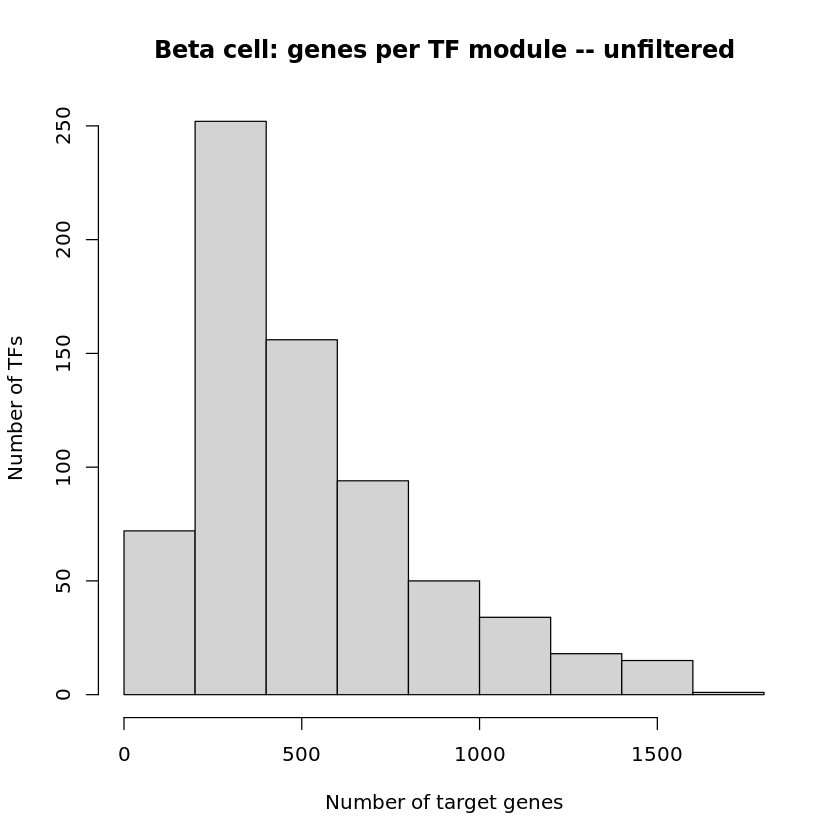

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300

$counts
 [1]  14  58 125 127  90  66  63  31  36  14  25   9   9

$density
 [1] 0.0002098951 0.0008695652 0.0018740630 0.0019040480 0.0013493253
 [6] 0.0009895052 0.0009445277 0.0004647676 0.0005397301 0.0002098951
[11] 0.0003748126 0.0001349325 0.0001349325

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050 1150 1250

$xname
[1] "info_fin %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "alpha"
[1] "2024-06-11 15:57:35 PDT"
[1] "Number of cell type peaks with CPM >  5 : 43585"
[1] "Final number of links used to make modules: 144438"


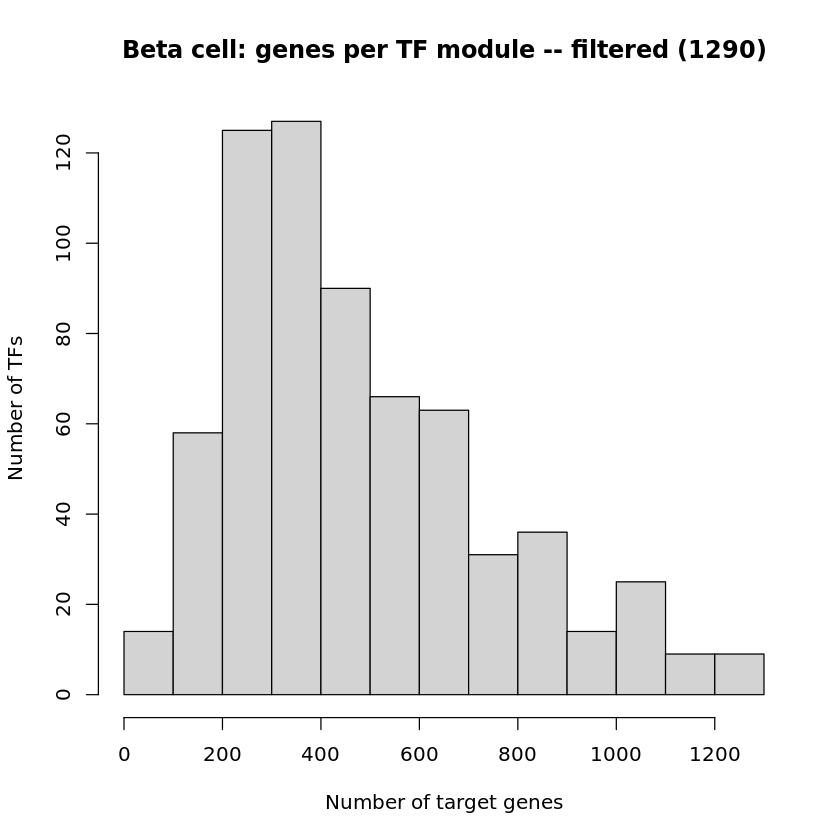

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400
[16] 1500

$counts
 [1]  64 156 145  99  71  42  33  16  17  15   5   8   9  10   2

$density
 [1] 9.248555e-04 2.254335e-03 2.095376e-03 1.430636e-03 1.026012e-03
 [6] 6.069364e-04 4.768786e-04 2.312139e-04 2.456647e-04 2.167630e-04
[11] 7.225434e-05 1.156069e-04 1.300578e-04 1.445087e-04 2.890173e-05

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050 1150 1250 1350 1450

$xname
[1] "info2 %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


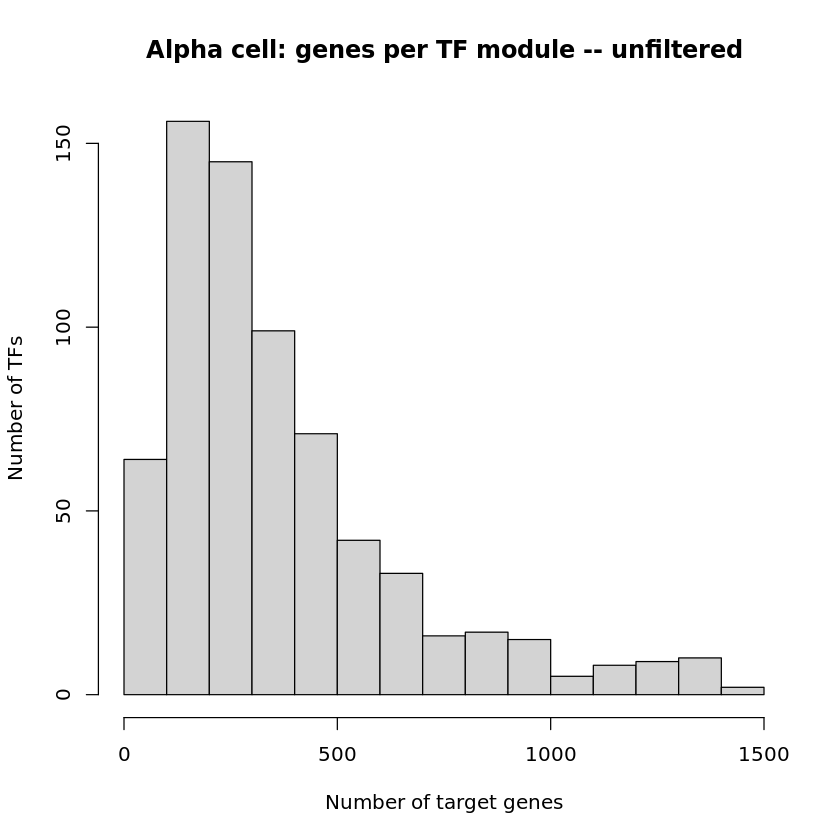

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300

$counts
 [1]  64 156 145  99  71  42  33  16  17  15   5   8   1

$density
 [1] 9.523810e-04 2.321429e-03 2.157738e-03 1.473214e-03 1.056548e-03
 [6] 6.250000e-04 4.910714e-04 2.380952e-04 2.529762e-04 2.232143e-04
[11] 7.440476e-05 1.190476e-04 1.488095e-05

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050 1150 1250

$xname
[1] "info_fin %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "delta"
[1] "2024-06-11 16:00:31 PDT"
[1] "Number of cell type peaks with CPM >  5 : 42490"
[1] "Final number of links used to make modules: 97888"


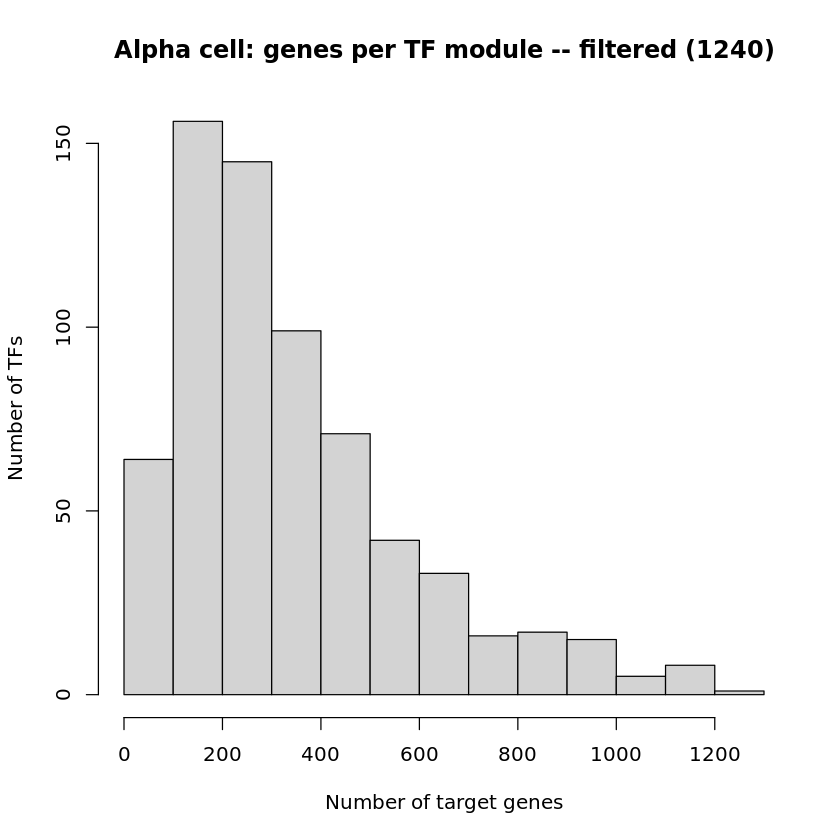

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300

$counts
 [1] 227 233  88  48  27  26   9   6   6   8   9   4   1

$density
 [1] 3.280347e-03 3.367052e-03 1.271676e-03 6.936416e-04 3.901734e-04
 [6] 3.757225e-04 1.300578e-04 8.670520e-05 8.670520e-05 1.156069e-04
[11] 1.300578e-04 5.780347e-05 1.445087e-05

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050 1150 1250

$xname
[1] "info2 %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


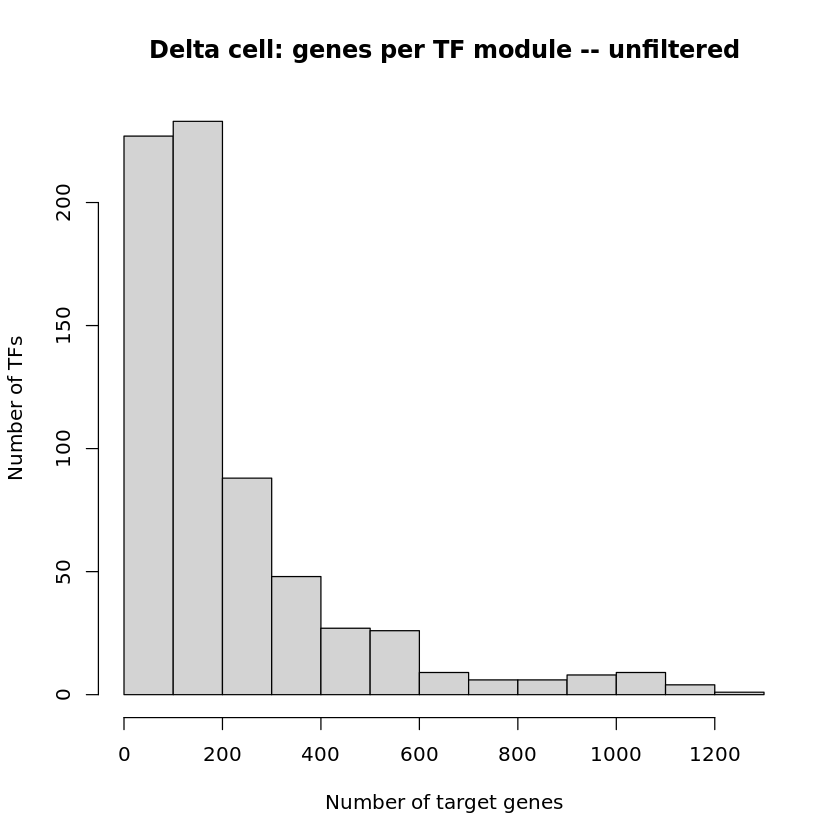

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000

$counts
 [1] 227 233  88  48  27  26   9   6   6   8

$density
 [1] 3.348083e-03 3.436578e-03 1.297935e-03 7.079646e-04 3.982301e-04
 [6] 3.834808e-04 1.327434e-04 8.849558e-05 8.849558e-05 1.179941e-04

$mids
 [1]  50 150 250 350 450 550 650 750 850 950

$xname
[1] "info_fin %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "gamma"
[1] "2024-06-11 16:03:27 PDT"
[1] "Number of cell type peaks with CPM >  5 : 42554"
[1] "Final number of links used to make modules: 94145"


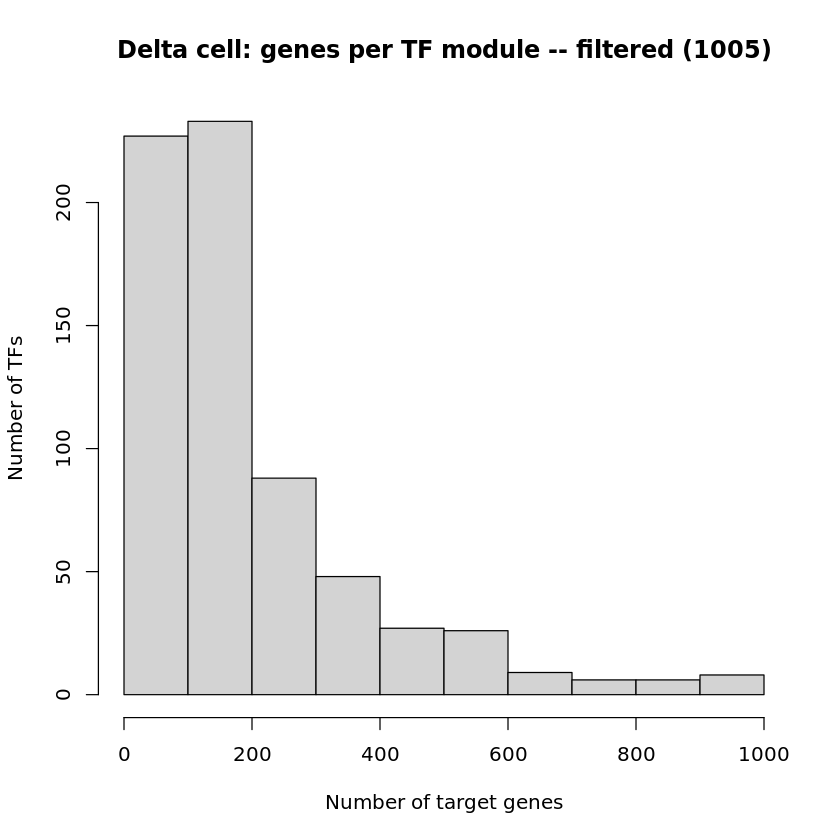

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100

$counts
 [1] 309 200  70  40  23  16  10   6   8   9   1

$density
 [1] 4.465318e-03 2.890173e-03 1.011561e-03 5.780347e-04 3.323699e-04
 [6] 2.312139e-04 1.445087e-04 8.670520e-05 1.156069e-04 1.300578e-04
[11] 1.445087e-05

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050

$xname
[1] "info2 %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


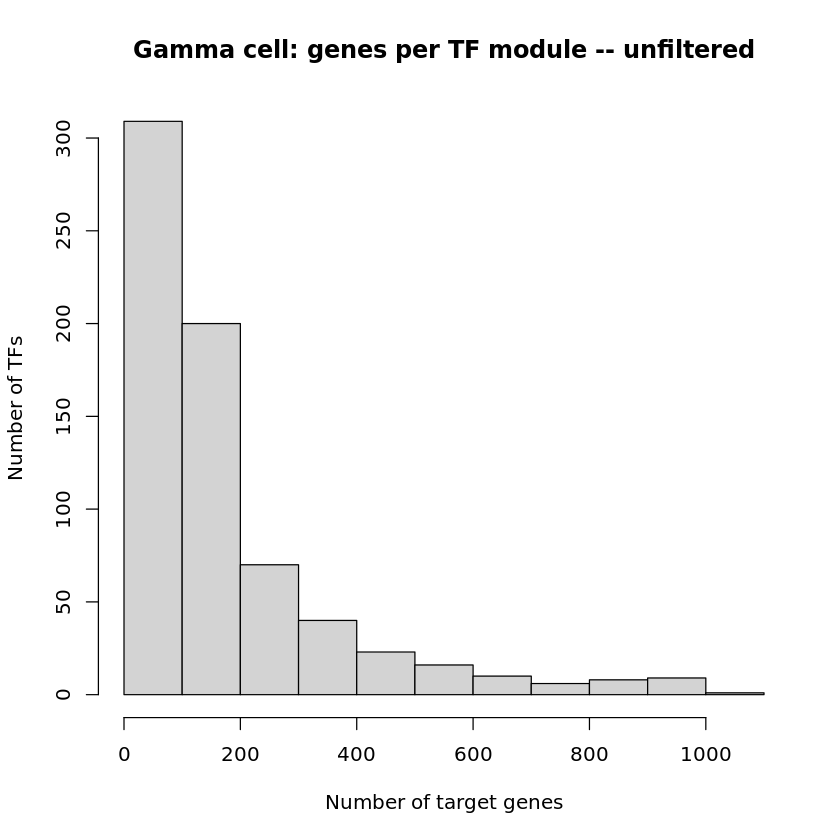

$breaks
 [1]   0 100 200 300 400 500 600 700 800 900

$counts
[1] 309 200  70  40  23  16  10   6   4

$density
[1] 4.557522e-03 2.949853e-03 1.032448e-03 5.899705e-04 3.392330e-04
[6] 2.359882e-04 1.474926e-04 8.849558e-05 5.899705e-05

$mids
[1]  50 150 250 350 450 550 650 750 850

$xname
[1] "info_fin %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "acinar"
[1] "2024-06-11 16:06:18 PDT"
[1] "Number of cell type peaks with CPM >  5 : 41824"
[1] "Final number of links used to make modules: 116327"


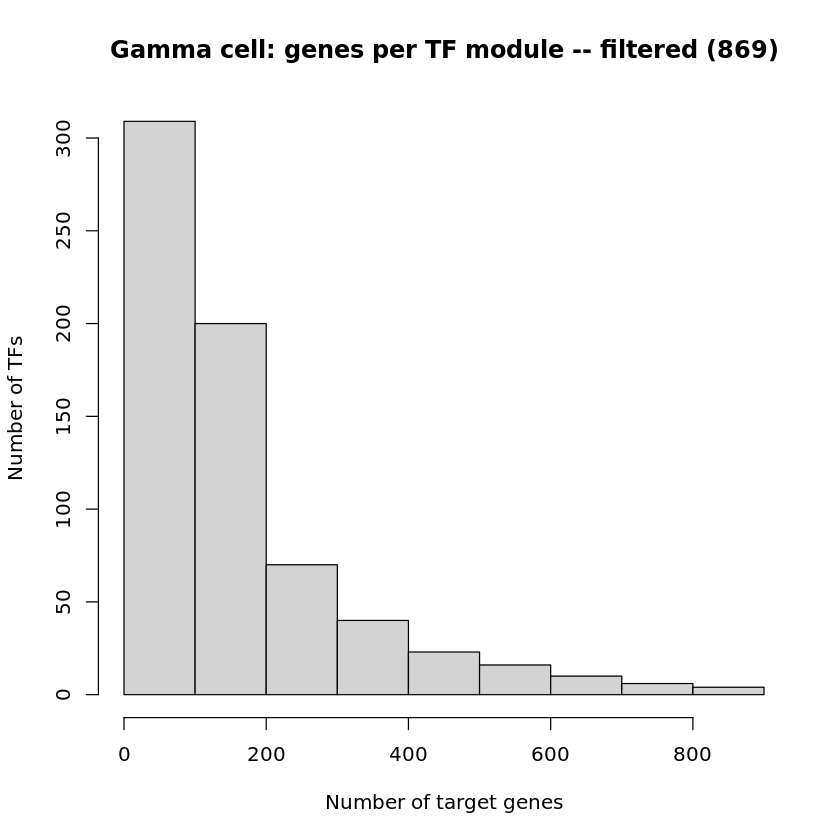

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300

$counts
 [1] 150 208 133  64  40  25  20  17   7   7   7  12   2

$density
 [1] 2.167630e-03 3.005780e-03 1.921965e-03 9.248555e-04 5.780347e-04
 [6] 3.612717e-04 2.890173e-04 2.456647e-04 1.011561e-04 1.011561e-04
[11] 1.011561e-04 1.734104e-04 2.890173e-05

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050 1150 1250

$xname
[1] "info2 %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


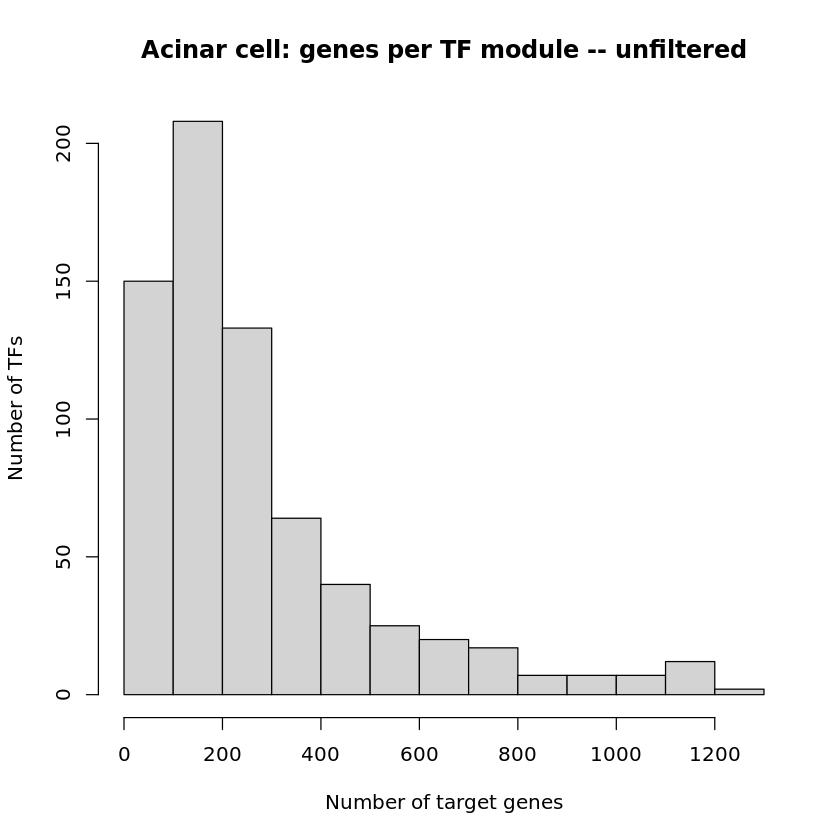

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100

$counts
 [1] 150 208 133  64  40  25  20  17   7   7   4

$density
 [1] 2.222222e-03 3.081481e-03 1.970370e-03 9.481481e-04 5.925926e-04
 [6] 3.703704e-04 2.962963e-04 2.518519e-04 1.037037e-04 1.037037e-04
[11] 5.925926e-05

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050

$xname
[1] "info_fin %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "ductal"
[1] "2024-06-11 16:09:08 PDT"
[1] "Number of cell type peaks with CPM >  5 : 42889"
[1] "Final number of links used to make modules: 148148"


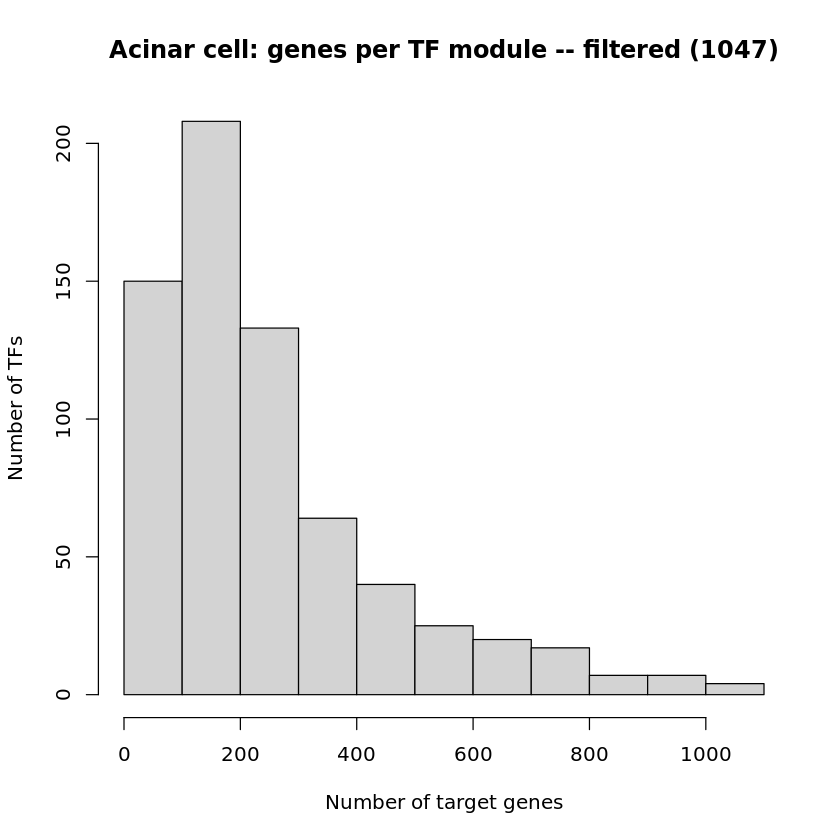

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400
[16] 1500 1600

$counts
 [1] 153 213 121  62  34  23  16  23  12   6   7   4   7   7   3   1

$density
 [1] 2.210983e-03 3.078035e-03 1.748555e-03 8.959538e-04 4.913295e-04
 [6] 3.323699e-04 2.312139e-04 3.323699e-04 1.734104e-04 8.670520e-05
[11] 1.011561e-04 5.780347e-05 1.011561e-04 1.011561e-04 4.335260e-05
[16] 1.445087e-05

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050 1150 1250 1350 1450
[16] 1550

$xname
[1] "info2 %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


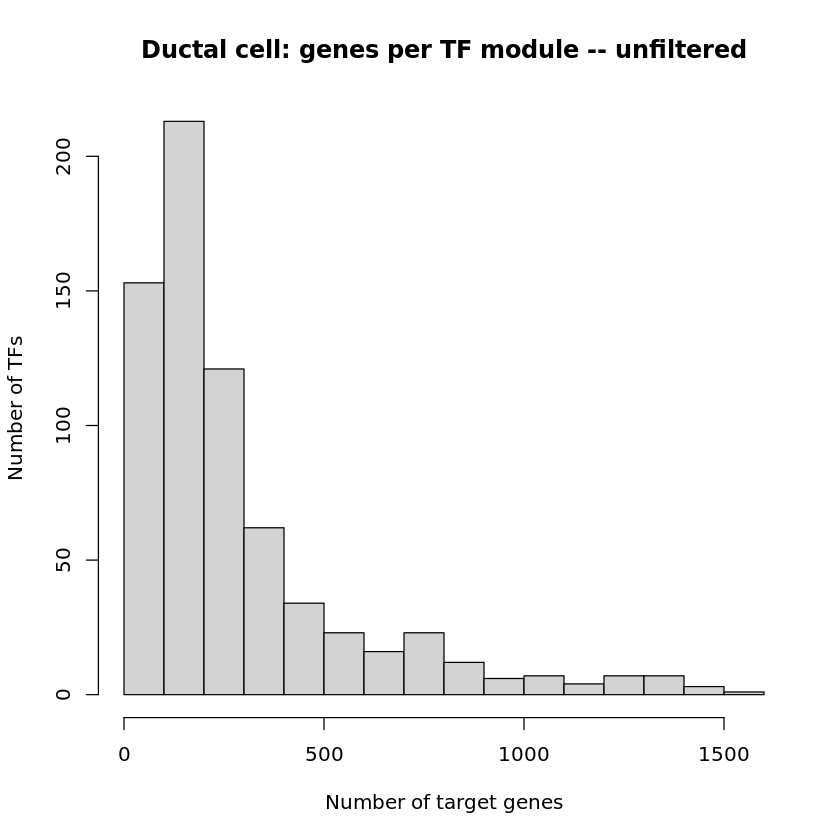

$breaks
 [1]    0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300

$counts
 [1] 153 213 121  62  34  23  16  23  12   6   7   4   3

$density
 [1] 2.259970e-03 3.146233e-03 1.787297e-03 9.158050e-04 5.022157e-04
 [6] 3.397341e-04 2.363368e-04 3.397341e-04 1.772526e-04 8.862629e-05
[11] 1.033973e-04 5.908419e-05 4.431315e-05

$mids
 [1]   50  150  250  350  450  550  650  750  850  950 1050 1150 1250

$xname
[1] "info_fin %>% distinct(TF, .keep_all = T) %>% pull(num_genes)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


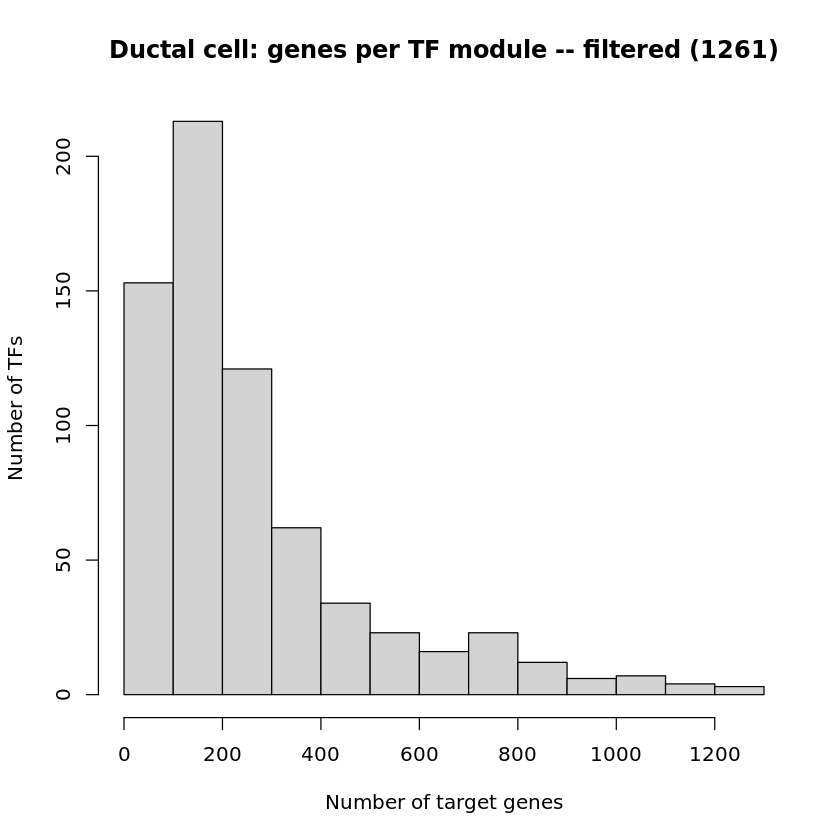

In [48]:
for(celltype in joint_celltypes){
    print(celltype)
    print(Sys.time())
    gather_tf_modules(celltype, motifs, 5)
}

# 2b. Approach 2: Calculate enrichment of TF modules in interesting pathways

## Read in pathway gene lists and format

In [49]:
#first need to read in the pathway gene set links
go_fp <- '/nfs/lab/relgamal/MAGMA/c5.go.v2023.1.Hs.symbols.gmt'
kegg_fp <- '/nfs/lab/relgamal/MAGMA/c2.cp.kegg.v2023.1.Hs.symbols.gmt'
reactome_fp <- '/nfs/lab/relgamal/MAGMA/c2.cp.reactome.v2023.1.Hs.symbols.gmt'
hallmark_fp <- '/nfs/lab/relgamal/MAGMA/h.all.v2023.1.Hs.symbols.gmt.txt'

In [50]:
#from hadley's comment in 2014 here: https://gist.github.com/aammd/9ae2f5cce9afd799bafb
list_to_df <- function(listfordf){
  df <- list(list.element = listfordf)
  class(df) <- c("tbl_df", "data.frame")
  attr(df, "row.names") <- .set_row_names(length(listfordf))

  if (!is.null(names(listfordf))) {
    df$name <- names(listfordf)
  }
  return(df)
}

In [51]:
### Function to read in a list of mSigDB pathways and organize a dataframe of pathway and gene set
get_pathway_genes_df <- function(pathways){
    fin_df <- data.frame()
    for(fp in pathways){
        gene_units <- gmt_to_list(fp, cutoff=0, sep = "\thttp://www.gsea-msigdb.org/gsea/msigdb/human/geneset/.*?\t")
        df <- list_to_df(gene_units)
        if(fp == '/nfs/lab/relgamal/MAGMA/c2.cp.reactome.v2023.1.Hs.symbols.gmt'){
            df$name <- paste0('REACTOME_',df$name)
        }
        fin_df <- rbind(fin_df,df)
    }
    fin_df <- fin_df %>% dplyr::rename(pathway=name, genes=list.element)
    return(fin_df)
}

In [52]:
#get pathway gene sets into a dataframe format
pathway_info <- get_pathway_genes_df(c(go_fp,kegg_fp,reactome_fp,hallmark_fp))
dim(pathway_info)
head(pathway_info,1)
tail(pathway_info,1)

Rows: 10532 Columns: 1
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 186 Columns: 1
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1654 Columns: 1
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to

[1] 12422     2

genes                                                                                                                                                                                                                                                                                                               
1 AKT3    , PPARGC1A, POLG2   , PARP1   , DNA2    , TYMP    , FLCN    , PRIMPOL , ENDOG   , STOX1   , SLC25A4 , LIG3    , MEF2A   , MPV17   , OPA1    , RRM2B   , POLG    , SLC25A36, TWNK    , RRM1    , METTL4  , SSBP1   , TOP3A   , TP53    , TEFM    , PIF1    , SESN2   , SLC25A33, DNAJA3  , MGME1   , LONP1   
  pathway                              
1 GOBP_MITOCHONDRIAL_GENOME_MAINTENANCE

genes                                                                                                                                                                                                                                                                                                                                                                 
1 PAX6   , NEUROD1, ISL1   , NKX2-2 , PCSK1  , NKX6-1 , SLC2A2 , SEC11A , DCX    , SPCS1  , FOXA2  , GCK    , MAFB   , INS    , PDX1   , ABCC8  , IAPP   , SRP9   , NEUROG3, FOXO1  , AKT3   , GCG    , DPP4   , PAX4   , SYT13  , SCGN   , HNF1A  , STXBP1 , CHGA   , VDR    , PCSK2  , INSM1  , SST    , ELP4   , SRPRB  , PAK3   , G6PC2  , PKLR   , LMO2   , SRP14  
  pathway                     
1 HALLMARK_PANCREAS_BETA_CELLS

## Test for enrichment of TF modules in pathways (cell type level)

# TO DO: rerun with new functions to record # genes in different sets

In [62]:
### Function to organize data for and run a Fischer's test for a TF and pathway
run_fischer <- function(tf_genes, pathway_genes, bg_genes){
    # First remove any tf or pathway genes not in the bg genes
    tf_genes2 <- tf_genes[tf_genes %in% bg_genes]
    pathway_genes2 <- pathway_genes[pathway_genes %in% bg_genes]
    
    # Set up data table (2 x 2) for test
    data <- data.frame('not_tf'=c(sum(!bg_genes %in% tf_genes2 & !bg_genes %in% pathway_genes2), sum(!pathway_genes2 %in% tf_genes2)),
                       'tf'=c(sum(!tf_genes2 %in% pathway_genes2), sum(tf_genes2 %in% pathway_genes2)),
                       row.names=c('not_pathway','pathway'))
    data_fin <- as.matrix(data)
    #print(data_fin)
    
    test <- fisher.test(data_fin, alternative='two.sided', or=1)
    vector <- c(test$conf.int[1], test$estimate, test$conf.int[2], test$p.value, length(tf_genes2), length(pathway_genes2), length(bg_genes))
    names(vector) <- c('CI_L','odds_ratio','CI_R','pvalue','num_tf_genes','num_pathway_genes','num_bg_genes')
    return(vector)    
}

In [63]:
### Wrapper function to run Fischer on TFs vs pathways
fischer_wrapper <- function(row, mods, pathway_info, bg_genes, outdir, celltype){
    # Extract TF gene info
    mods_row <- mods[row,]
    tf <- mods_row[['TF']]
    tf_genes <- str_split(mods_row[['genes']],' , ')[[1]]
    
    # Set up dataframe to keep results in
    tf_res <- data.frame()

    # Now loop through all pathways and run Fischer tests
    for(i in seq(dim(pathway_info)[1])){
        pathway <- pathway_info$pathway[i]
        pathway_genes <- unlist(pathway_info[i,'genes'])
        pathway_res <- run_fischer(tf_genes, pathway_genes, bg_genes)
        pathway_res <- c(pathway_res,pathway)
        tf_res <- rbind(tf_res, pathway_res)
    }
    colnames(tf_res) <- c('CI_L','odds_ratio','CI_R','pvalue','num_tf_genes','num_pathway_genes','num_bg_genes','pathway')
    tf_res$motif <- tf

    #write this to a file!
    out_fp <- file.path(outdir,sprintf('%s_%s_pathway_enrichments_FISCHER.txt',celltype,tf))
    write.table(tf_res, out_fp, sep='\t', row.names=F, quote=F)
    return(out_fp)
}

In [55]:
### Overall wrapper function per cell type to get enrichment of TF modules in ALL pathways
overall_wrapper <- function(celltype, pathway_info, bg_genes_set, tf_mod_dir){
    #read in modules TF-cres-genes summary df and collapse the genes column
    fp <- file.path(tf_mod_dir, sprintf('%s_90per_filt_TF_gene_TPM1_links.txt',celltype))
    mods <- read.table(fp, sep='\t', header=1)
    mods <- mods %>% group_by(TF) %>%
            mutate(genes=paste(gene, collapse=' , ')) %>%
            select(-c(gene,num_links,all_cres,all_methods)) %>% distinct(TF, .keep_all=TRUE)
    print(head(mods))

    #read in background gene set/s
    if(bg_genes_set==1){
        bg_fp1 <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/rna_profiles/recluster_final_clustering_v2/major_celltype_TPM/%s_expressed_genes_TPM1.txt',celltype)
        bg_genes <- scan(bg_fp1, what='', sep='\n')
        test_dir <- file.path(tf_mod_dir, 'pathway_enrichment', 'all_ct_genes')    
    } else if (bg_genes_set==2){
        bg_fp2 <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/231211_links_summary/%s_all_methods_links.wHeader.bedpe',celltype)
        bg_genes <- sort(unique(read.table(bg_fp2, sep='\t', header=1) %>% pull(gene)))
        test_dir <- file.path(tf_mod_dir, 'pathway_enrichment', 'all_linked_genes')
    }
    
    #setup output dir
    dir.create(test_dir, showWarnings = F, recursive=T)

    #loop through TFs in mods to calculate pathway enrichment
    mclapply(seq(dim(mods)[1]),fischer_wrapper,mods,pathway_info,bg_genes,test_dir,celltype,
            mc.cores=10)
    
    #read back in all TF results and organize into one output file
    data <- data.frame()
    for(tf in mods$TF){
        res_fp <- file.path(test_dir,sprintf('%s_%s_pathway_enrichments_FISCHER.txt',celltype,tf))
        res <- read.table(res_fp, sep='\t', header=1)
        data <- rbind(data,res)
    }
    out_fp <- file.path(test_dir,sprintf('%s_ALL_TF_pathway_enrichments_fischer.txt',celltype))
    write.table(data, out_fp, sep='\t', row.names=F, quote=F)
    
    #remove solos TF files
    system(sprintf('rm %s/%s_*FISCHER*',test_dir,celltype))
}

In [56]:
tf_mod_dir <- file.path(outdir,'tf_modules','CPM5')

In [57]:
mclapply(joint_celltypes, overall_wrapper, pathway_info, 1, tf_mod_dir, mc.cores=3)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

## Read in results and combine with pathway association results

### First FDR correct results

In [58]:
dir <- file.path(tf_mod_dir,'pathway_enrichment','all_ct_genes')
celltype <- 'beta'

Rows: 8285474 Columns: 6
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): pathway, motif
dbl (4): CI_L, odds_ratio, CI_R, pvalue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]  593121  371615  342521  309432  271911  245178  206969  184236  178712
[10]  139951  123634  102309  143568   83949   70603   43348   26659    9481
[19]    1399 4836878

$density
 [1]  1.431712899  0.897027738  0.826798805  0.746926488  0.656355931
 [6]  0.591826128  0.499594833  0.444720483  0.431386303  0.337822555
[11]  0.298435551  0.246959920  0.346553498  0.202641394  0.170425977
[16]  0.104636138  0.064351177  0.022885836  0.003376994 11.675561350

$mids
 [1] 0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
[13] 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975

$xname
[1] "df$pvalue"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]   16574   20520   23909   28140   32912   37932   394

Rows: 8347584 Columns: 6
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): pathway, motif
dbl (4): CI_L, odds_ratio, CI_R, pvalue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


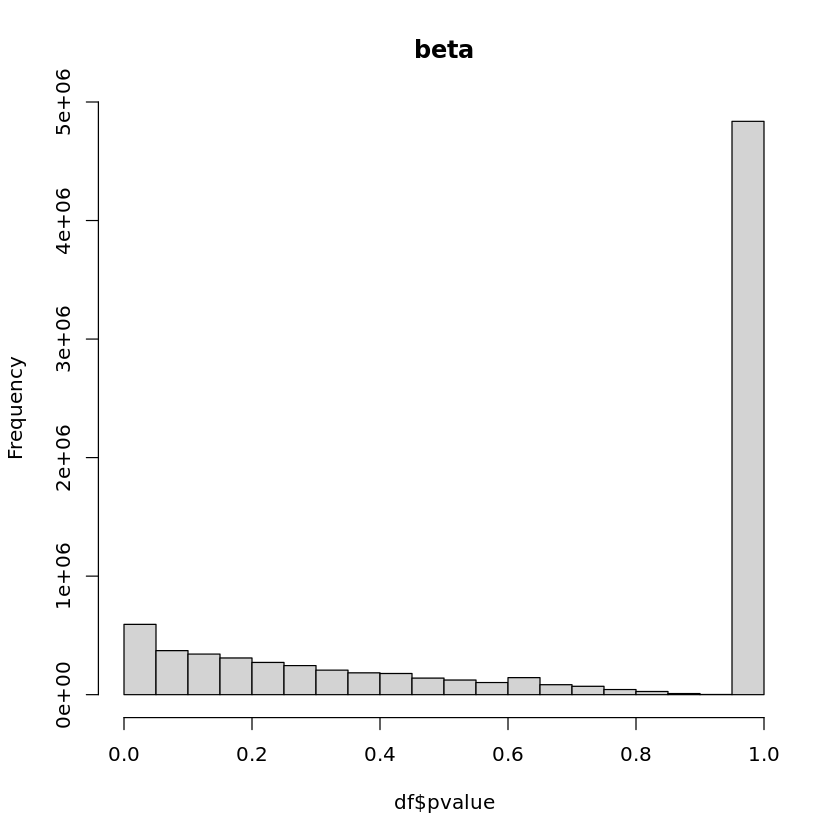

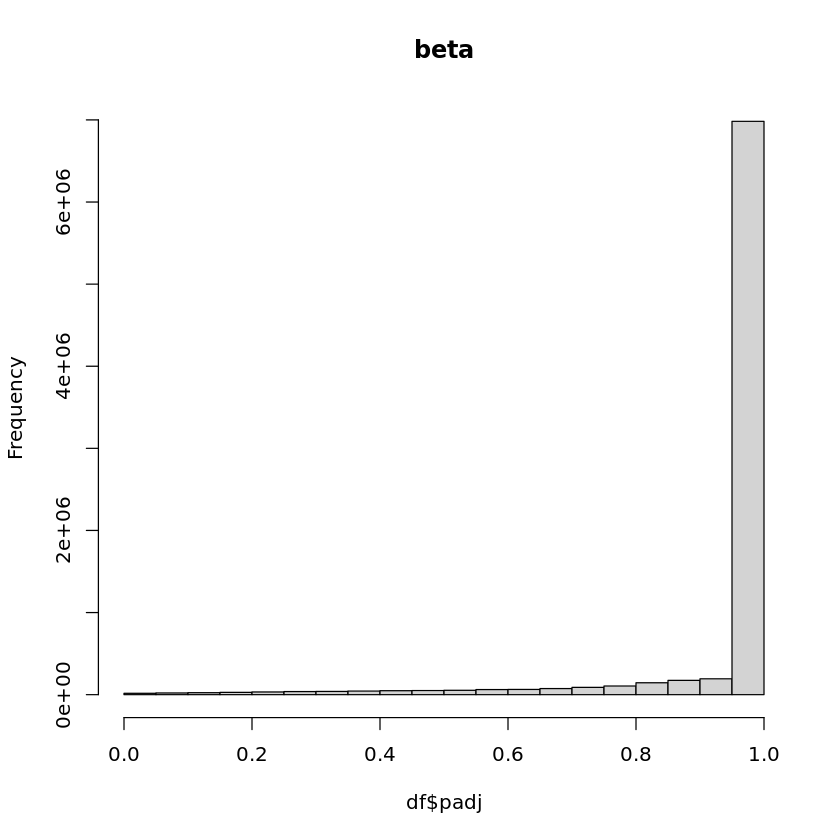

$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]  473375  345806  303419  262769  225039  201422  170539  148649  147286
[10]  112197  101698   83541  117241   67672   55746   33941   21213    7507
[19]    1078 5467446

$density
 [1]  1.134160495  0.828517569  0.726962436  0.629568987  0.539171573
 [6]  0.482587537  0.408594870  0.356148557  0.352882942  0.268813108
[11]  0.243658524  0.200156117  0.280898042  0.162135535  0.133561998
[16]  0.081319337  0.050824286  0.017986042  0.002582783 13.099469260

$mids
 [1] 0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
[13] 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975

$xname
[1] "df$pvalue"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]    1129    2942    4835    7093    9988   11631   155

Rows: 8422116 Columns: 6
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): pathway, motif
dbl (4): CI_L, odds_ratio, CI_R, pvalue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


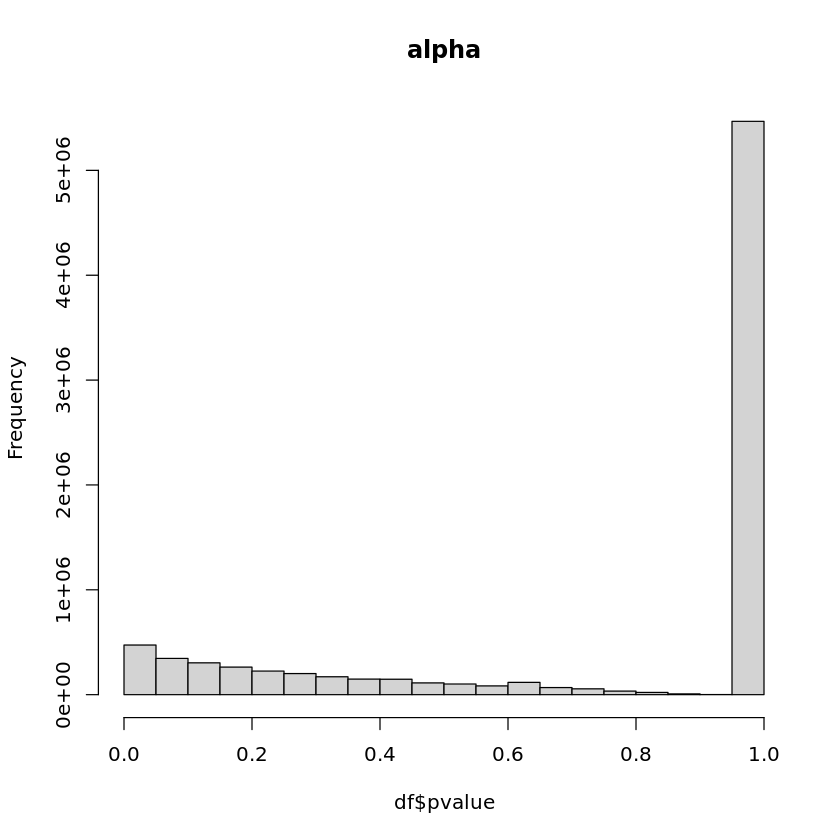

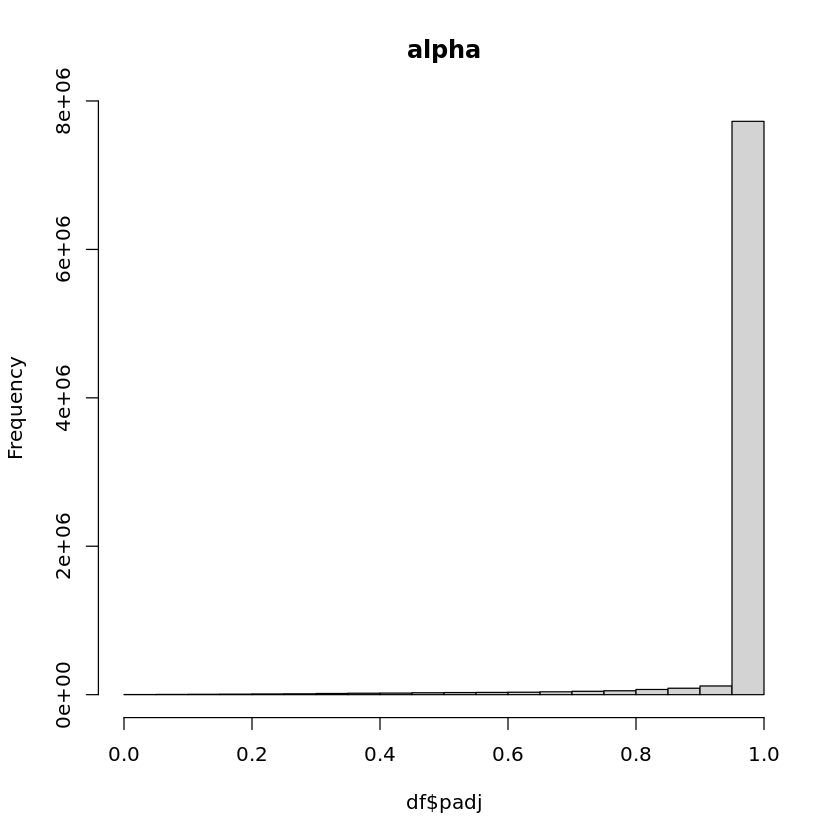

$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]  233425  223578  194814  169595  144822  136103  111910  101065  107357
[10]   78754   74307   61390   98671   48262   44165   27341   19159    6958
[19]    1199 6539241

$density
 [1]  0.554314379  0.530930707  0.462624832  0.402737269  0.343908823
 [6]  0.323203812  0.265752692  0.239999069  0.254940682  0.187017134
[11]  0.176456843  0.145782841  0.234314037  0.114607778  0.104878631
[16]  0.064926676  0.045496880  0.016523164  0.002847265 15.528736484

$mids
 [1] 0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
[13] 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975

$xname
[1] "df$pvalue"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
$breaks
 [1] 0.69 0.70 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.80 0.81 0.82 0.83
[16] 0.84 0.85 0.86 0.87 0.88 0.89 0.90 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
[31] 0.99 1.00

$count

Rows: 8422116 Columns: 6
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): pathway, motif
dbl (4): CI_L, odds_ratio, CI_R, pvalue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


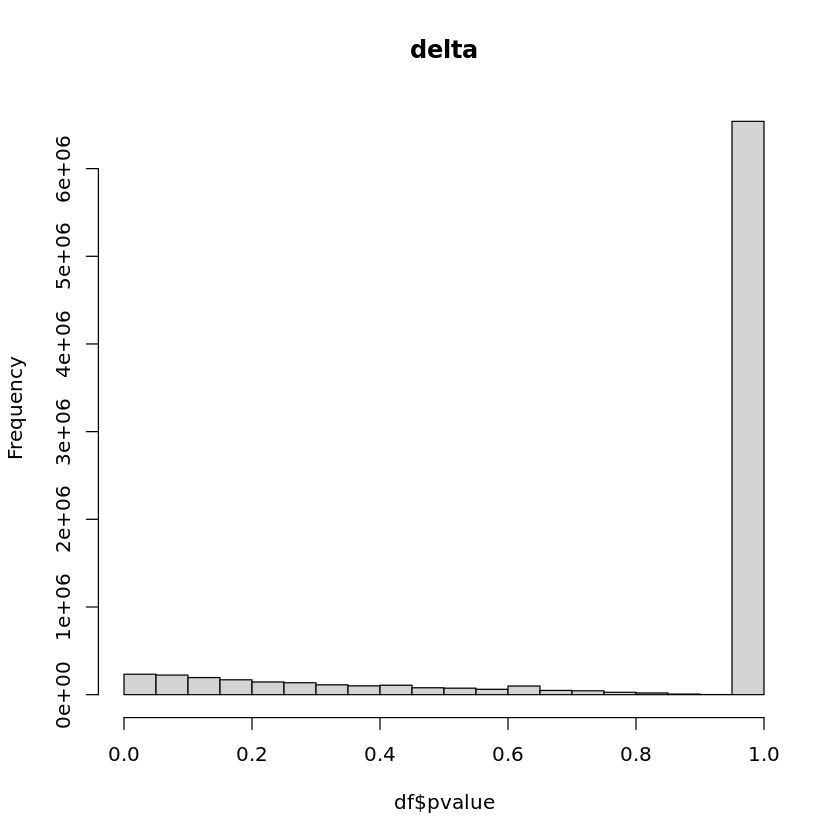

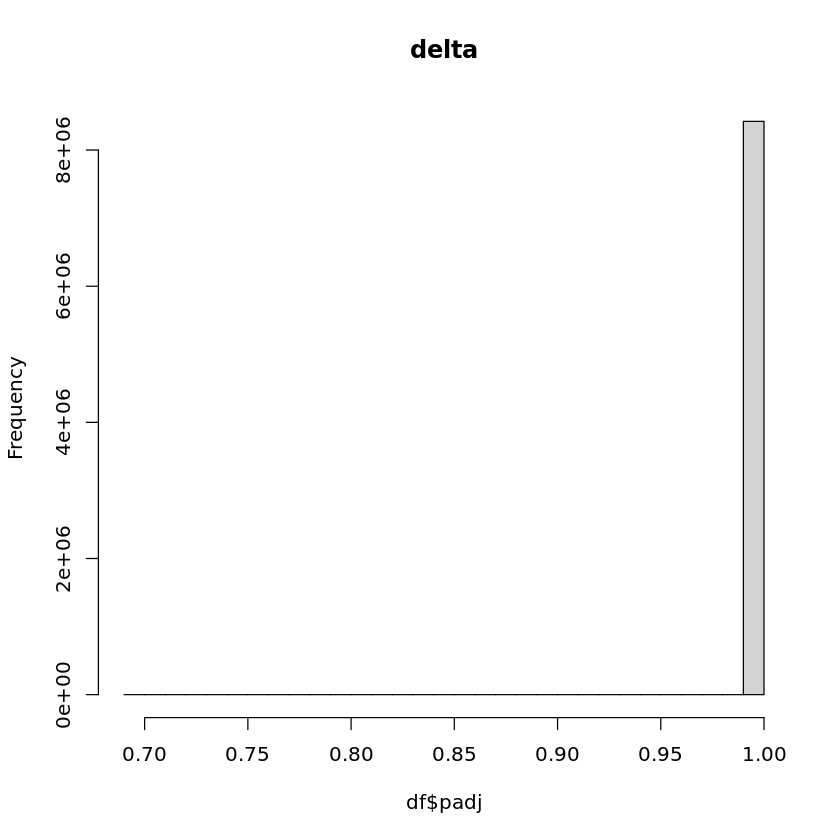

$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]  194661  192666  165168  145178  122559  117220   96793   87121   93541
[10]   67711   64613   53149   88543   41052   38656   23312   15749    5655
[19]     957 6807812

$density
 [1]  0.462261503  0.457523976  0.392224472  0.344754216  0.291040874
 [6]  0.278362350  0.229854350  0.206886250  0.222131825  0.160793321
[11]  0.153436500  0.126212937  0.210263074  0.097486190  0.091796408
[16]  0.055359010  0.037399152  0.013428929  0.002272588 16.166512074

$mids
 [1] 0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
[13] 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975

$xname
[1] "df$pvalue"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
$breaks
[1] 0 1

$counts
[1] 8422116

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "df$padj"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


Rows: 8384850 Columns: 6
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): pathway, motif
dbl (4): CI_L, odds_ratio, CI_R, pvalue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


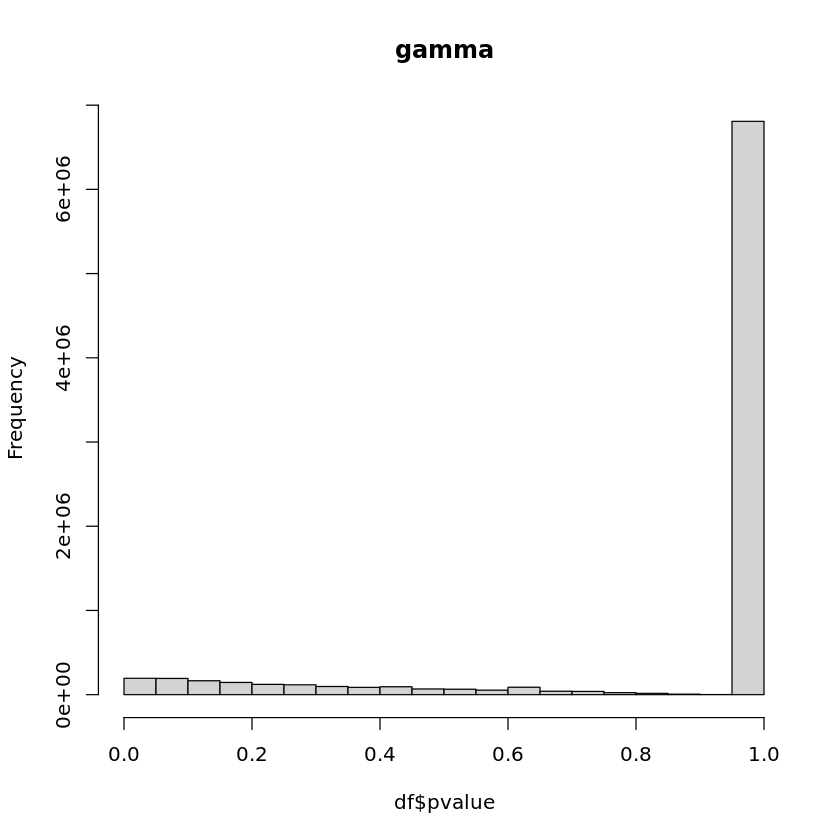

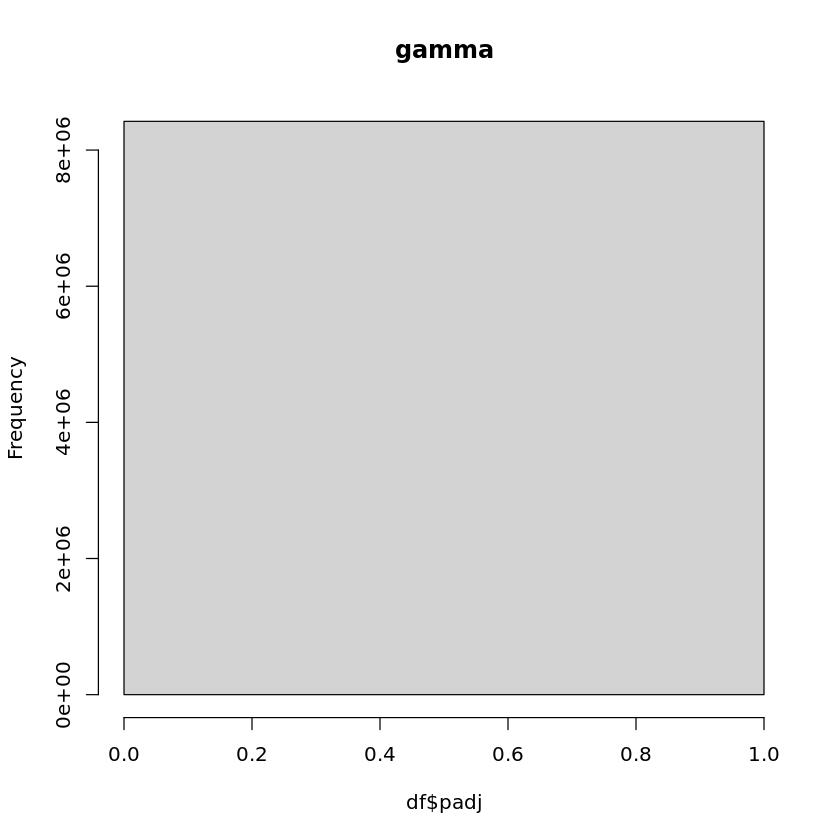

$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]  335381  281862  246052  212689  183500  167958  139220  125308  128792
[10]   94874   89156   73164  113944   57026   51279   31170   21243    8018
[19]    1513 6022701

$density
 [1]  0.79996899  0.67231256  0.58689661  0.50731736  0.43769417  0.40062255
 [7]  0.33207511  0.29889145  0.30720168  0.22629862  0.21265974  0.17451475
[13]  0.27178542  0.13602151  0.12231346  0.07434838  0.05066996  0.01912497
[19]  0.00360889 14.36567380

$mids
 [1] 0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
[13] 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975

$xname
[1] "df$pvalue"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]       5      67      64     186     236     693     626    1436    1948
[

Rows: 8409694 Columns: 6
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): pathway, motif
dbl (4): CI_L, odds_ratio, CI_R, pvalue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


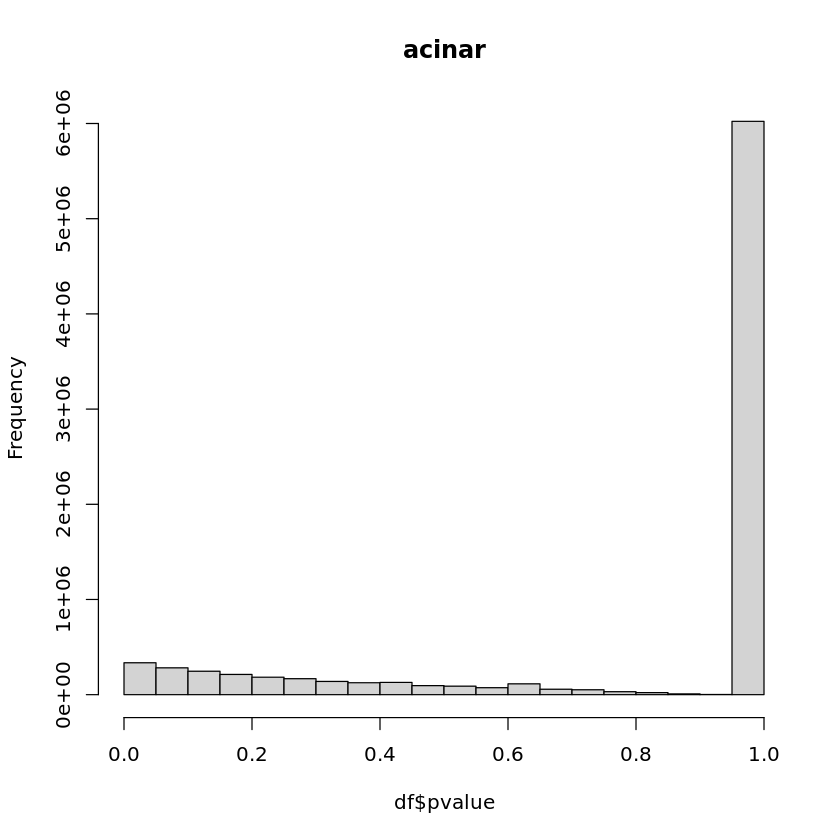

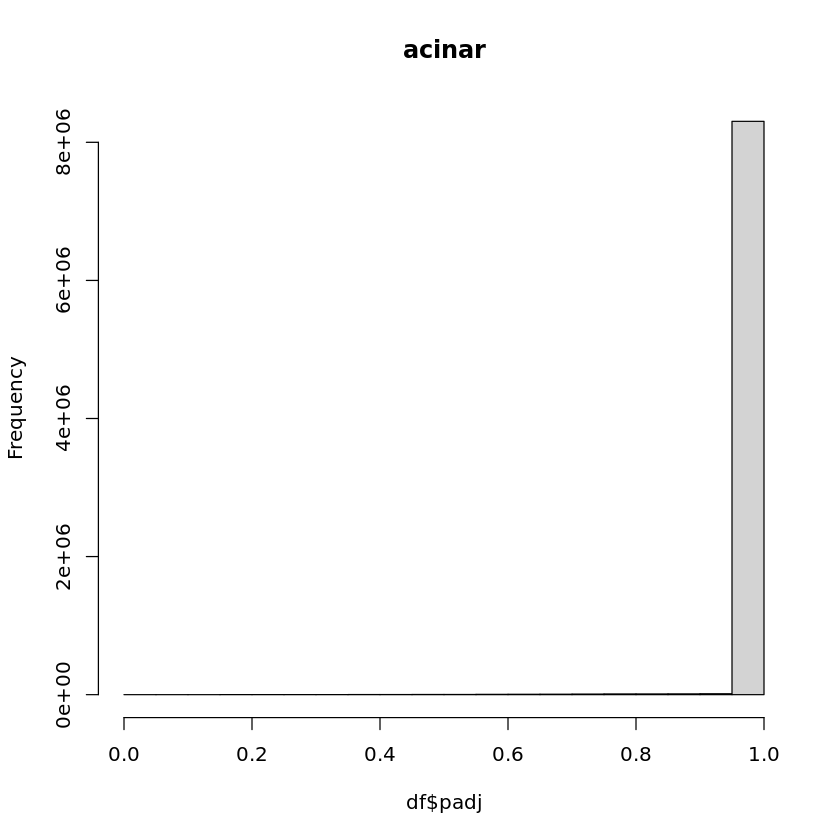

$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75 0.80 0.85 0.90 0.95 1.00

$counts
 [1]  261799  248718  219505  196042  168514  159213  132657  120158  125651
[10]   93297   89703   73599  118576   58298   54468   33634   24265    9712
[19]    1886 6219999

$density
 [1]  0.62261243  0.59150309  0.52202851  0.46622862  0.40076131  0.37864160
 [7]  0.31548591  0.28576069  0.29882419  0.22187965  0.21333238  0.17503372
[13]  0.28199837  0.13864476  0.12953622  0.07998864  0.05770721  0.02309715
[19]  0.00448530 14.79245024

$mids
 [1] 0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
[13] 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975

$xname
[1] "df$pvalue"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


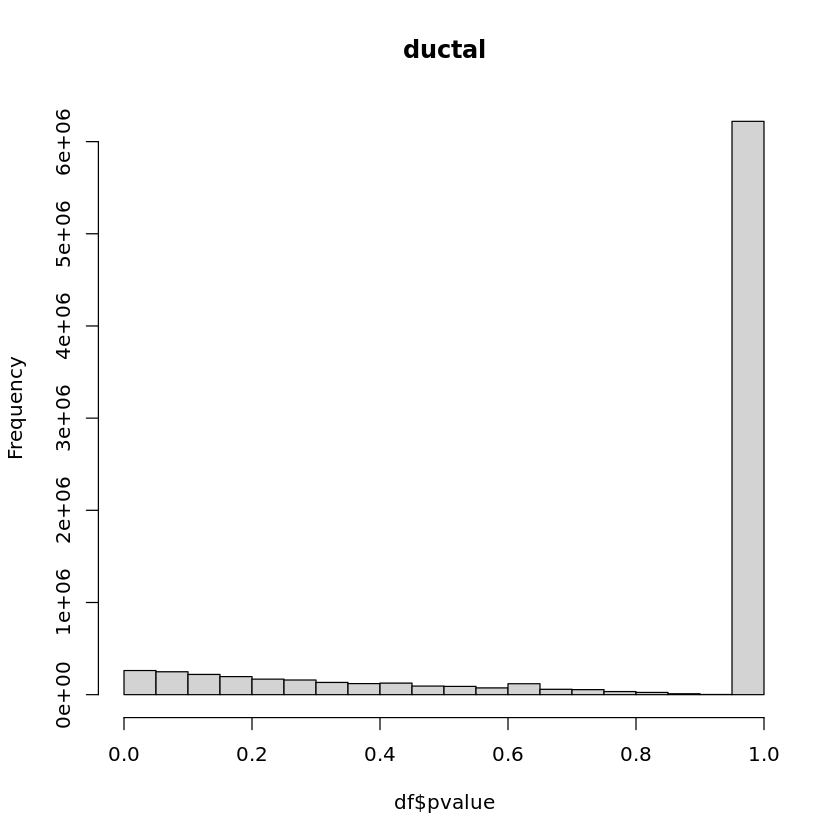

$breaks
 [1] 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90
[16] 0.95 1.00

$counts
 [1]      18       4       0       3       0      12       8      14      51
[10]      48      24     569     595     527    1323 8406498

$density
 [1] 4.280774e-05 9.512831e-06 0.000000e+00 7.134623e-06 0.000000e+00
 [6] 2.853849e-05 1.902566e-05 3.329491e-05 1.212886e-04 1.141540e-04
[11] 5.707699e-05 1.353200e-03 1.415034e-03 1.253316e-03 3.146369e-03
[16] 1.999240e+01

$mids
 [1] 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575 0.625 0.675 0.725 0.775
[13] 0.825 0.875 0.925 0.975

$xname
[1] "df$padj"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


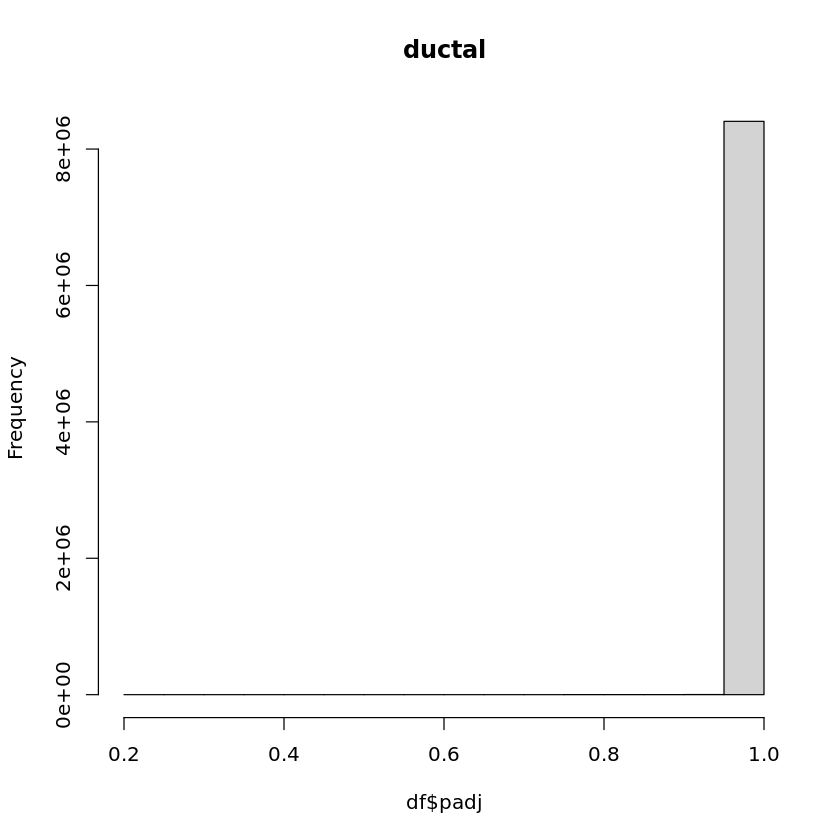

In [59]:
for(celltype in joint_celltypes){
    fp <- file.path(dir,sprintf('%s_ALL_TF_pathway_enrichments_fischer.txt',celltype))
    df <- vroom::vroom(fp)
    print(hist(df$pvalue, main=celltype))
    
    df$padj <- p.adjust(df$pvalue, method='BH')
    print(hist(df$padj,main=celltype))

    out_fp <- file.path(dir,sprintf('%s_ALL_TF_pathway_enrichments_fischer_wpadj.txt',celltype))
    write.table(df, out_fp, sep='\t', row.names=F, quote=F)
}

In [60]:
# dir <- file.path(tf_mod_dir,'pathway_enrichment','all_linked_genes')
# celltype <- 'beta'

In [61]:
# for(celltype in joint_celltypes){
#     fp <- file.path(dir,sprintf('%s_ALL_TF_pathway_enrichments_fischer.txt',celltype))
#     df <- vroom::vroom(fp)
#     print(hist(df$pvalue, main=celltype))
    
#     df$padj <- p.adjust(df$pvalue, method='BH')
#     print(hist(df$padj,main=celltype))

#     out_fp <- file.path(dir,sprintf('%s_ALL_TF_pathway_enrichments_fischer_wpadj.txt',celltype))
#     write.table(df, out_fp, sep='\t', row.names=F, quote=F)
# }

### Now combine with pathway association results and filter for sig associations and enrichments

# TO DO: in the future only write out file if there are any motifs enriched (right now writes out rows with a bunch on NAs)

In [83]:
### Function to read in TF module enrichment results and pathways associated with traits
### and make final output file of things sig for both
get_sig_pathway_enrichments <- function(celltype, trait, enrich_dir, pathway_set, enrich_cutoff=0.1, pathway_cutoff=0.1){
    # Read in padj version of TF module 
    enrich_fp <- file.path(enrich_dir,sprintf('%s_ALL_TF_pathway_enrichments_fischer_wpadj.txt',celltype))
    enrich <- fread(enrich_fp)#, sep='\t', header=1)
    sig_enrich <- subset(enrich, padj < enrich_cutoff)
    
    # Read in sig pathways and combine with sig mod enrichment
    pathway_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_fGSEA'
    pathway_fp <- file.path(pathway_dir,trait,sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt',celltype,trait,pathway_set))
    pathway_df <- fread(pathway_fp)#, sep='\t', header=1)
    sig_pathways <- subset(pathway_df, padj < pathway_cutoff) %>% select(-leadingEdge)
    print(paste('Number of significant pathways:',dim(sig_pathways)[1]))
    
    # join two dataframes and print some summary info
    if(dim(sig_pathways)[1]>0){
        res <- left_join(sig_pathways,sig_enrich, by='pathway')
    print(paste('Number of motif enrichments in sig pathways:',dim(res)[1]))
    res <- res %>% group_by(pathway) %>% mutate(num_motifs=length(motif))
    print(hist(res %>% distinct(pathway, .keep_all=TRUE) %>% pull(num_motifs),main=paste(celltype,trait,'sig enriched motifs per sig pathway')))
    
    #write this to a file too!
    out_fp <- file.path(enrich_dir,'sig_pathways',sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.txt',celltype, trait))
    write.table(res,out_fp, sep='\t', row.names=F, quote=F)
    }
}

In [81]:
traits <- c('scaled_age','scaled_BMI','scaled_HbA1c','sex')

[1] "Number of significant pathways: 40"
[1] "Number of motif enrichments in sig pathways: 56"
$breaks
 [1]  1  2  3  4  5  6  7  8  9 10

$counts
[1] 37  1  0  0  1  0  0  0  1

$density
[1] 0.925 0.025 0.000 0.000 0.025 0.000 0.000 0.000 0.025

$mids
[1] 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 187"
[1] "Number of motif enrichments in sig pathways: 1958"


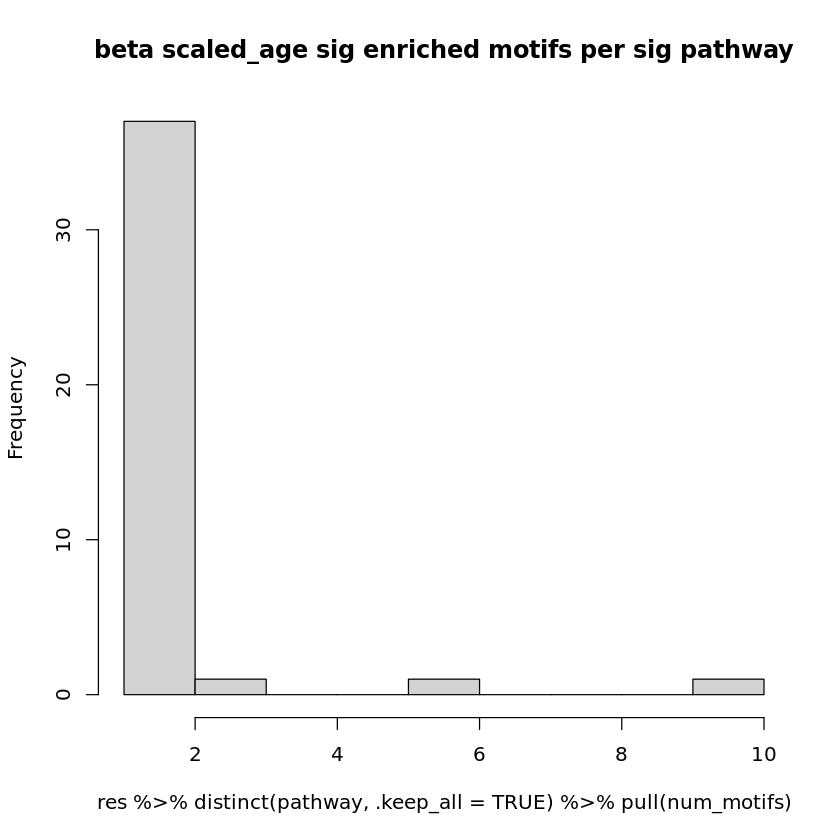

$breaks
[1]   0  50 100 150 200 250 300

$counts
[1] 176   5   2   2   1   1

$density
[1] 0.0188235294 0.0005347594 0.0002139037 0.0002139037 0.0001069519
[6] 0.0001069519

$mids
[1]  25  75 125 175 225 275

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 3"
[1] "Number of motif enrichments in sig pathways: 3"


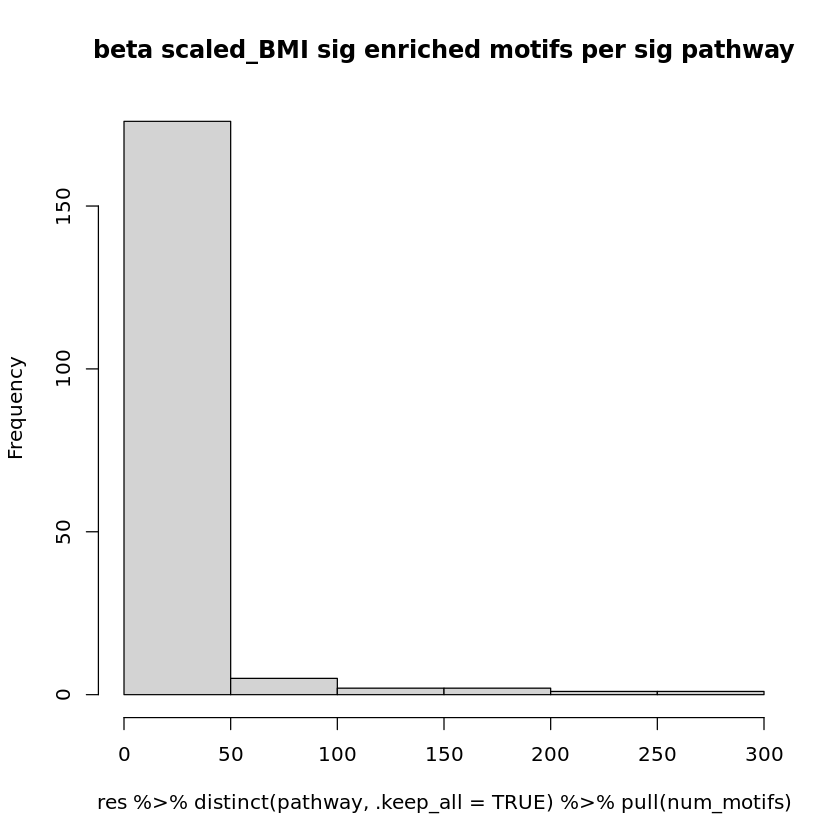

$breaks
[1] 0 1

$counts
[1] 3

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 9"
[1] "Number of motif enrichments in sig pathways: 268"


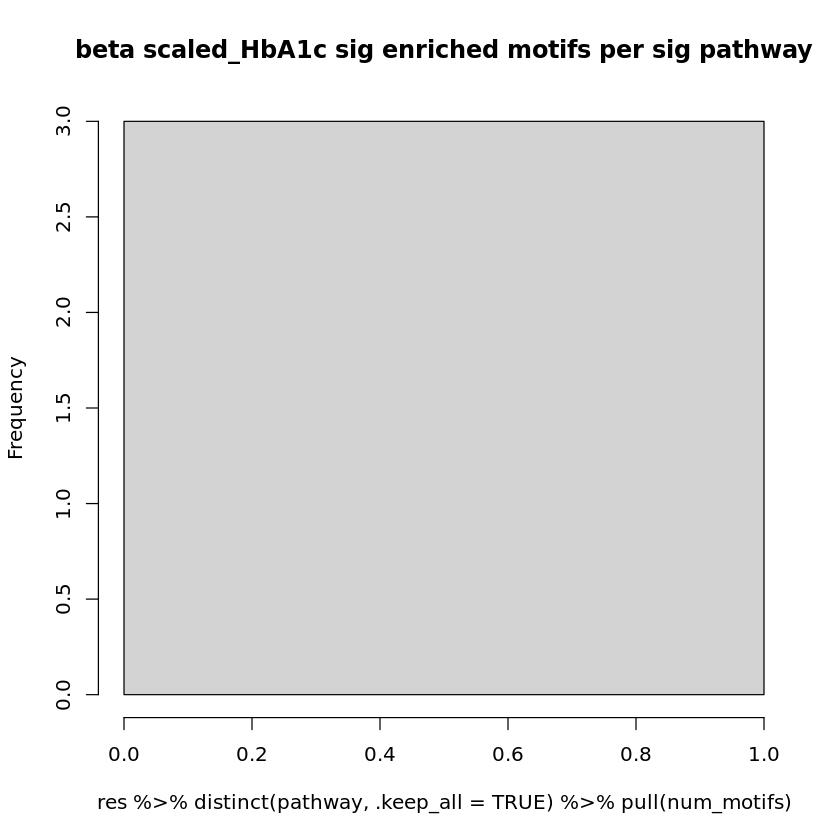

$breaks
[1]   0  50 100 150 200

$counts
[1] 7 1 0 1

$density
[1] 0.015555556 0.002222222 0.000000000 0.002222222

$mids
[1]  25  75 125 175

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 41"
[1] "Number of motif enrichments in sig pathways: 41"


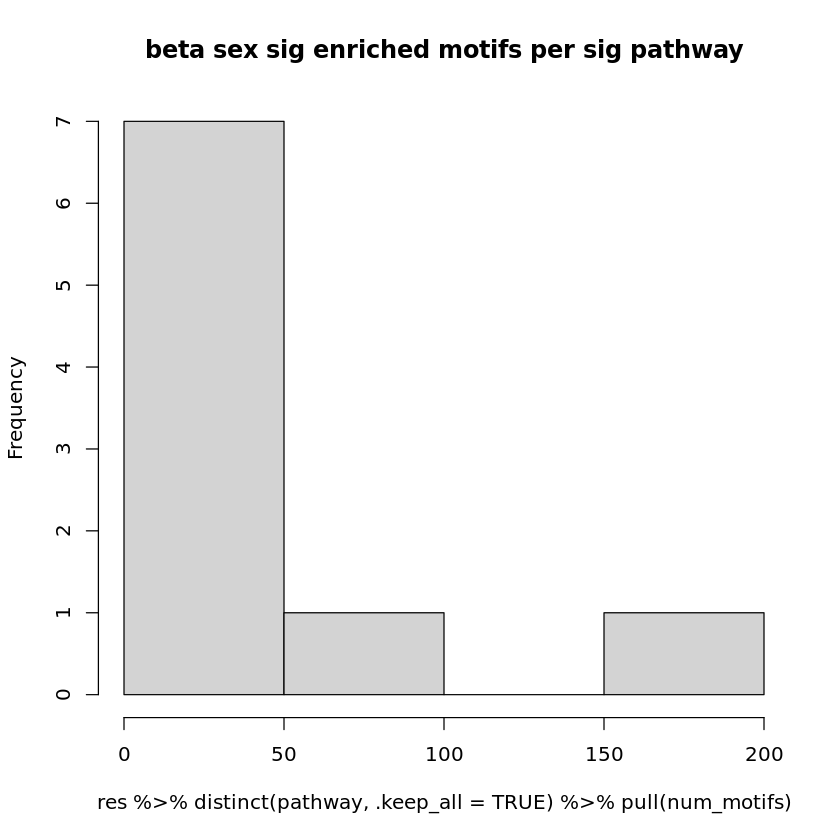

$breaks
[1] 0 1

$counts
[1] 41

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 24"
[1] "Number of motif enrichments in sig pathways: 172"


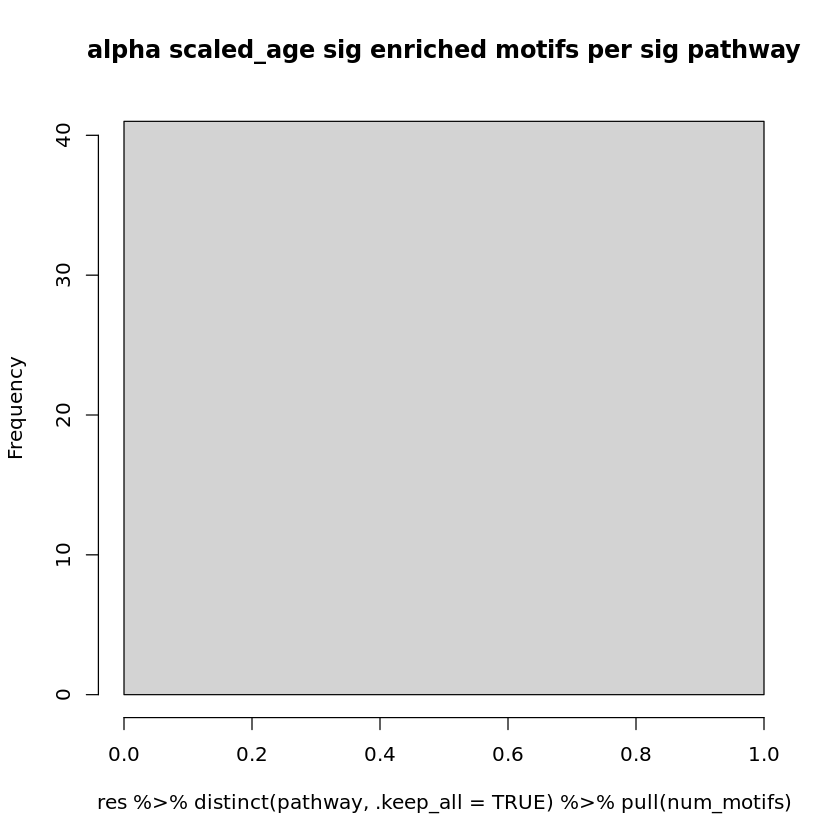

$breaks
[1]  0  5 10 15 20 25 30 35 40

$counts
[1] 18  0  1  1  2  1  0  1

$density
[1] 0.150000000 0.000000000 0.008333333 0.008333333 0.016666667 0.008333333
[7] 0.000000000 0.008333333

$mids
[1]  2.5  7.5 12.5 17.5 22.5 27.5 32.5 37.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 48"
[1] "Number of motif enrichments in sig pathways: 48"


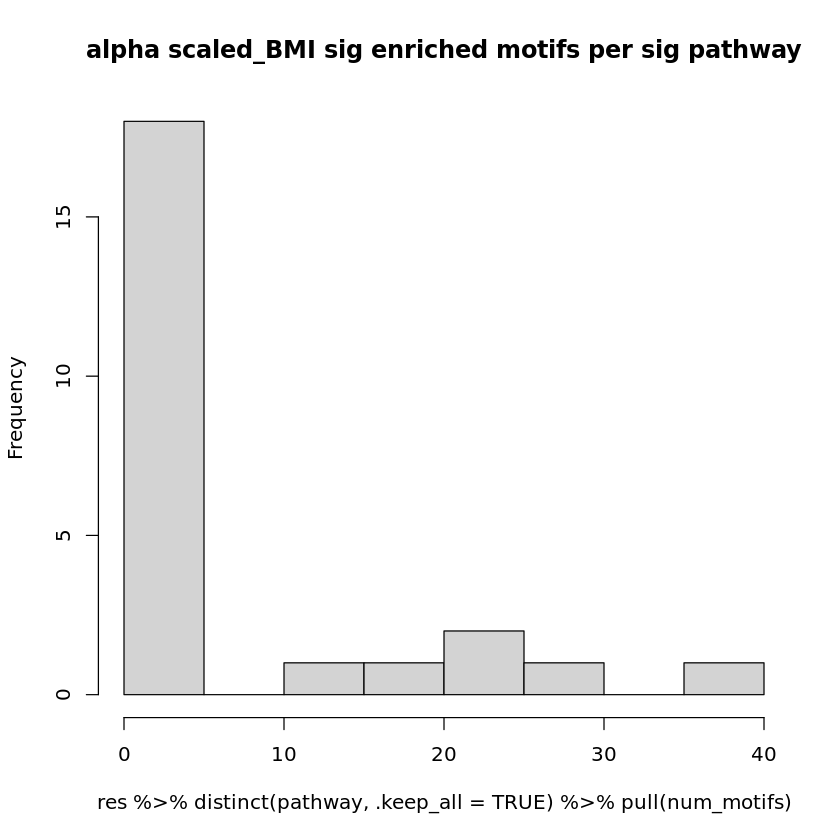

$breaks
[1] 0 1

$counts
[1] 48

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 2"
[1] "Number of motif enrichments in sig pathways: 2"


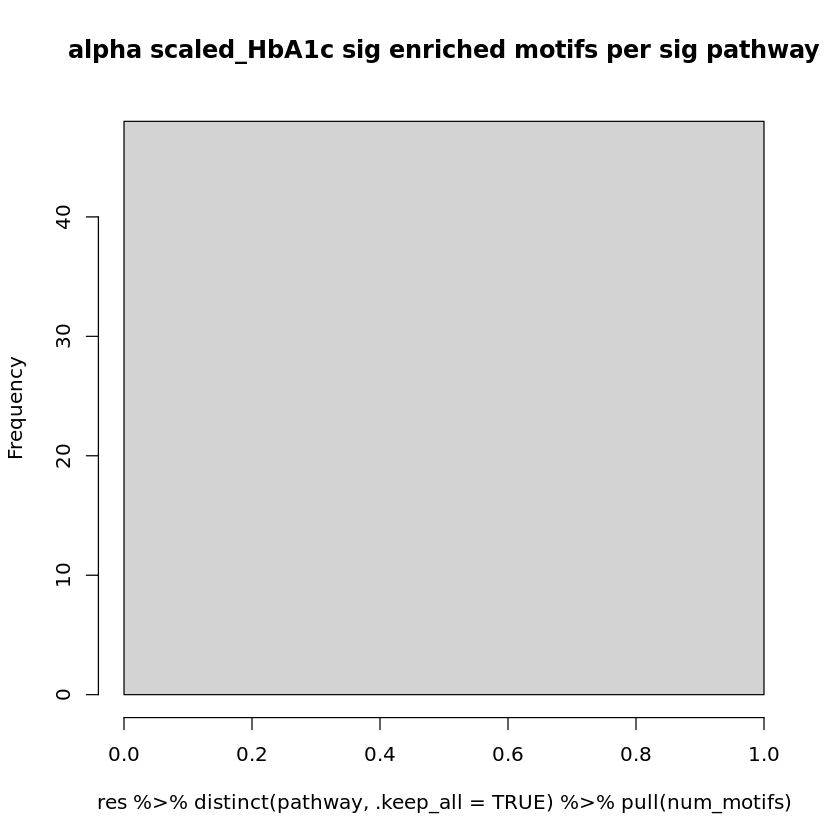

$breaks
[1] 0 1

$counts
[1] 2

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 3"
[1] "Number of motif enrichments in sig pathways: 3"


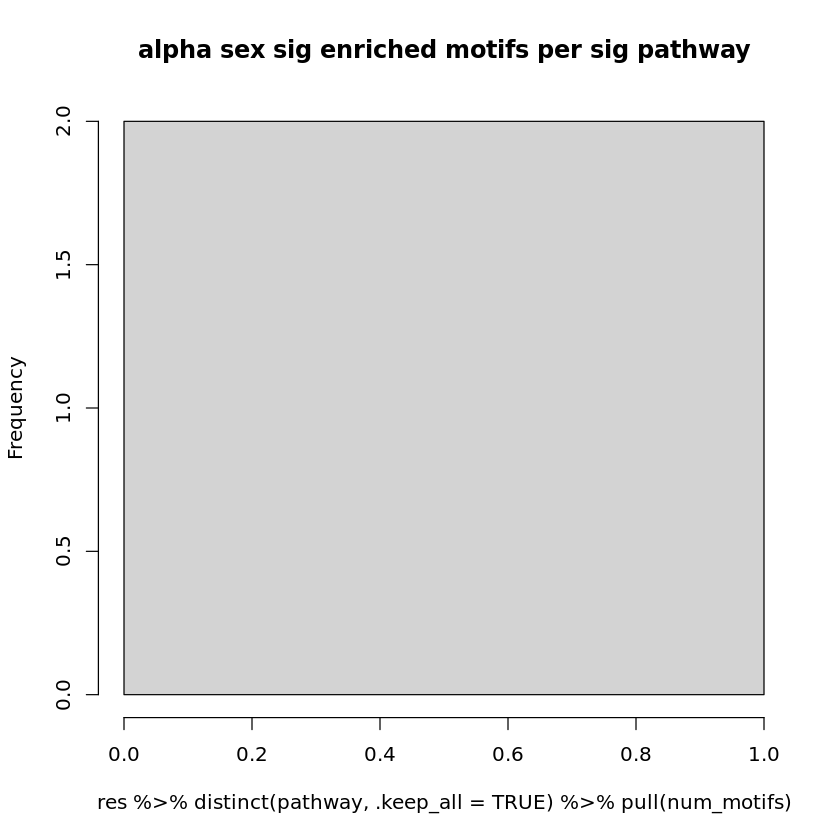

$breaks
[1] 0 1

$counts
[1] 3

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 9"
[1] "Number of motif enrichments in sig pathways: 9"


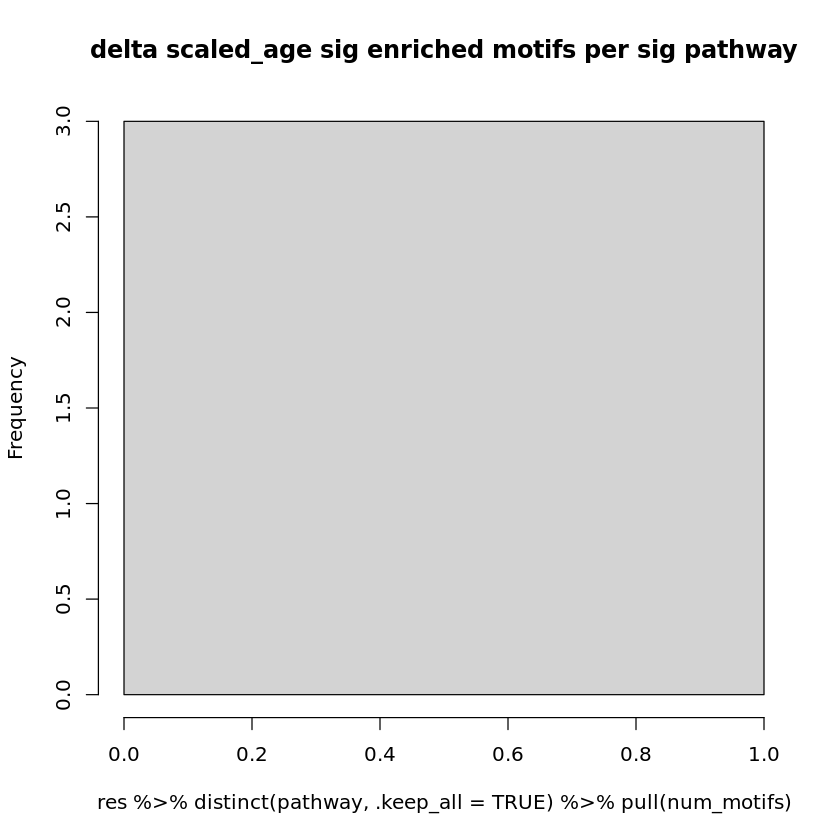

$breaks
[1] 0 1

$counts
[1] 9

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 103"
[1] "Number of motif enrichments in sig pathways: 103"


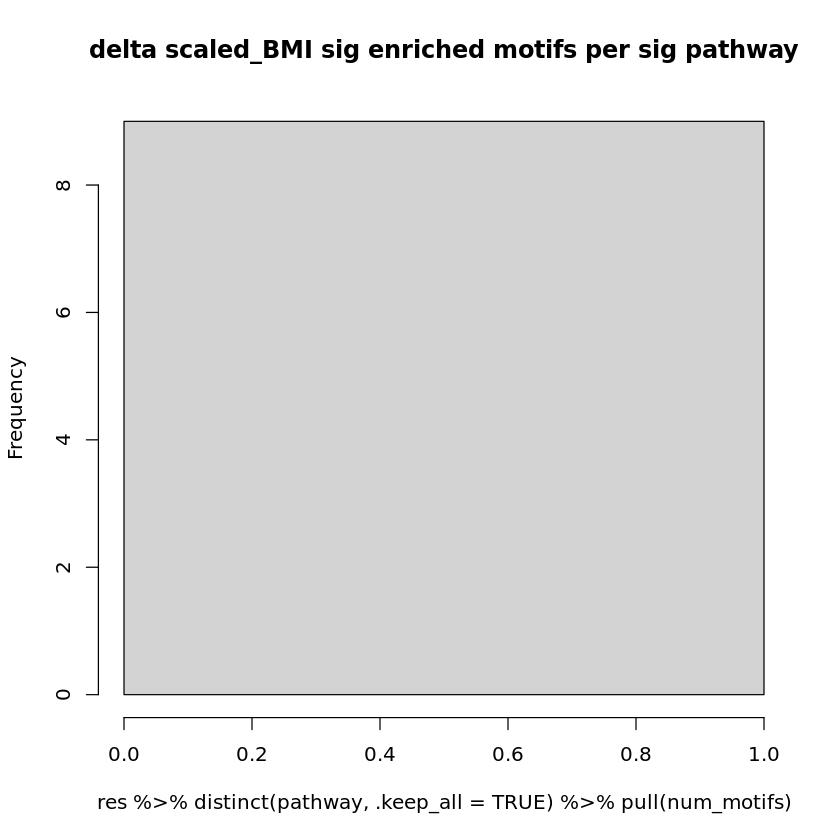

$breaks
[1] 0 1

$counts
[1] 103

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"
[1] "Number of significant pathways: 13"
[1] "Number of motif enrichments in sig pathways: 13"
$breaks
[1] 0 1

$counts
[1] 13

$density
[1] 1

$mids
[1] 0.5

$xname
[1] "res %>% distinct(pathway, .keep_all = TRUE) %>% pull(num_motifs)"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


ERROR: Error in fread(pathway_fp): File '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_fGSEA/scaled_age/gamma_scaled_age.all_genes_REM_results_fGSEA_all.txt' does not exist or is non-readable. getwd()=='/nfs/lab/hmummey/multiomic_islet/notebooks/trait_associations/final_notebooks'


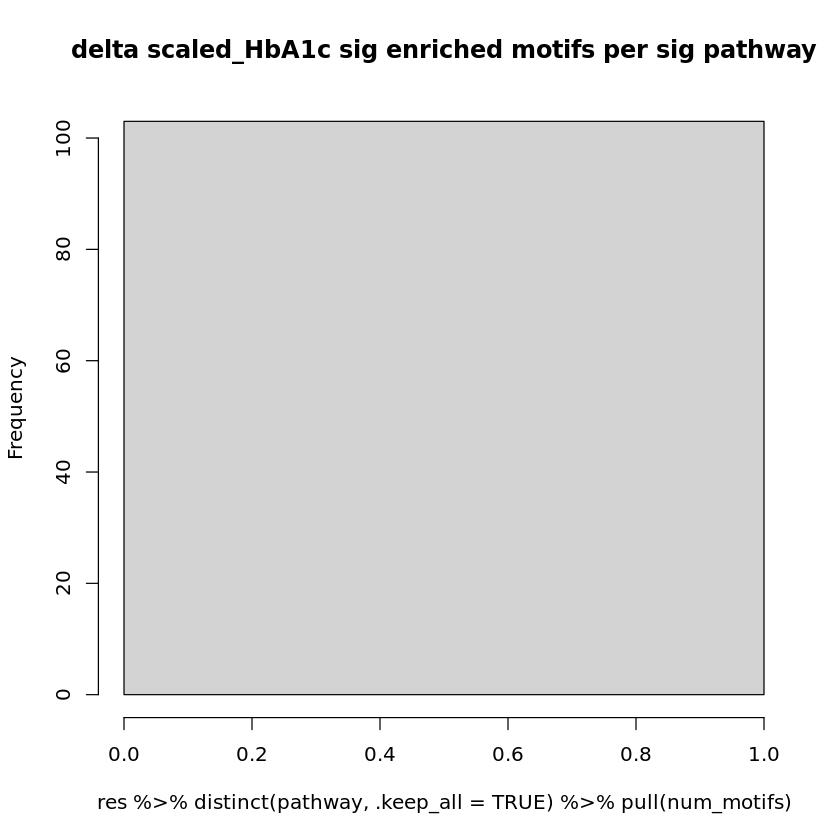

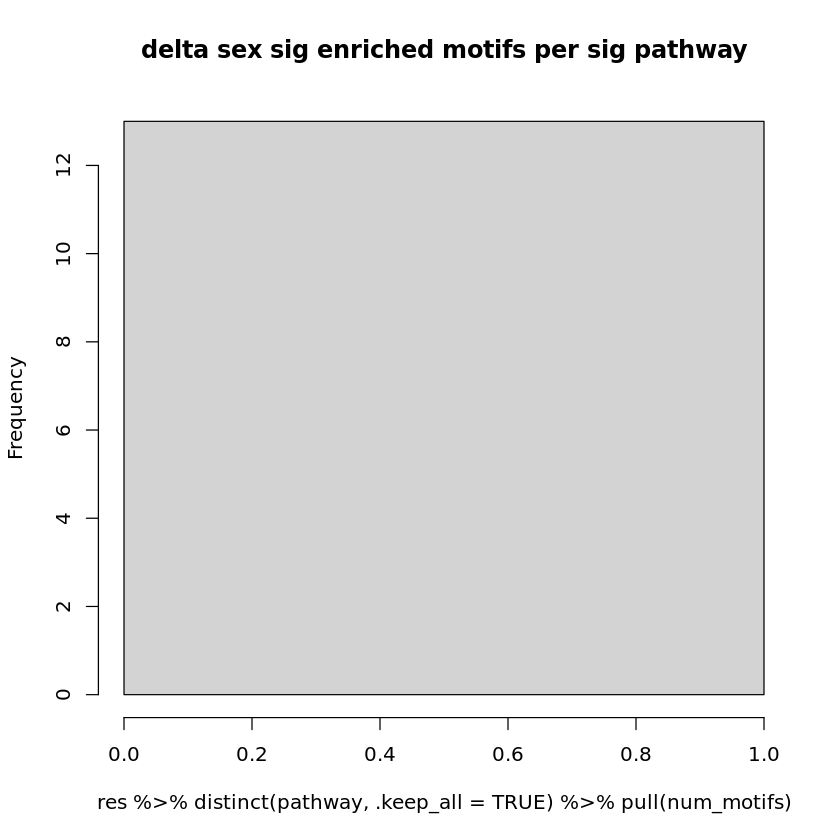

In [84]:
dir1 <- file.path(tf_mod_dir,'pathway_enrichment','all_ct_genes')
for(celltype in joint_celltypes){
    for(trait in traits){
        get_sig_pathway_enrichments(celltype,trait,dir1,'all')
    }
}

In [ ]:
# dir2 <- file.path(tf_mod_dir,'pathway_enrichment','all_linked_genes')
# for(celltype in joint_celltypes){
#     for(trait in traits){
#         get_sig_pathway_enrichments(celltype,trait,dir2,'all')
#     }
# }

# 2c. Calculate concordance of TF modules with enriched pathways
Goal: Based on the files made ^, for all trait associated pathways, calculate the concordance of TF modules that are enriched in those genes.

In [307]:
indir <- file.path(tf_mod_dir,'pathway_enrichment','all_ct_genes','sig_pathways')
outdir <- file.path(tf_mod_dir,'pathway_enrichment','all_ct_genes','pathway_mod_concordance')

In [363]:
calc_pathway_mod_concordance <- function(row, mods, deg_df){
    #get inputs from df row
    pathway <- row[['pathway']]
    pathway_dir <- sign(as.numeric(row[['NES']]))
    motif <- row[['motif']]

    #get tf target genes and test for enriched concordance with binomial test
    tf_targets <- mods %>% subset(TF==motif) %>% pull(gene)
    concordance <- sign(subset(deg_df, gene %in% tf_targets) %>% pull(effect))== pathway_dir
    test <- binom.test(x=sum(concordance), n=length(concordance), p=0.5, alternative='two.sided')

    #collect outputs as one vector (prob, CI_L, CI_R, pval, # genes in mod, # genes concordant)
    outputs <- c(test$estimate, test$conf.int, test$p.value, test$parameter, test$statistic)
    return(outputs)
}

In [368]:
ref_df <- read.table('/nfs/lab/ABC/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE)
auto_genes <- subset(ref_df, !grepl('X|Y',V1)) %>% pull(V4)

In [422]:
rna_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA'
rna_degs_dir <- file.path(rna_dir, 'REM_meta')
    
for(celltype in joint_celltypes){
    #read in cell type modules here
    mods_fp <- file.path(tf_mod_dir,sprintf('%s_90per_filt_TF_gene_TPM1_links.txt',celltype))
    mods <- fread(mods_fp)

    for(trait in traits){
        #read in results of associated pathways with enriched mods
        in_fp <- file.path(indir,sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.txt',celltype, trait))
        if(file.exists(in_fp)){
            df <- read.table(in_fp, sep='\t', header=1) %>% subset(!is.na(motif))
            if(dim(df)[1] > 0){
                #print some summary info
                print(c(celltype,trait))
                print(paste('number of sig trait pathway-motif enrichments', dim(df)[1]))
                print(paste('number of unique pathways', length(unique(df$pathway))))
                print(paste('number of unique motifs', length(unique(df$motif))))
                
                # Read in DESeq results dataframe and subset to autosomal genes IF sex association
                fp <- file.path(rna_degs_dir, trait, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
                deg_df <- read.table(fp, sep='\t', header=TRUE)
                deg_df <- deg_df %>% tibble::rownames_to_column(var='gene') 
                if (trait == 'sex') deg_df <- subset(deg_df, gene %in% auto_genes)
    
                #now calculate concordance with a binomial test and collect results
                results <- as.data.frame(t(apply(df, 1, calc_pathway_mod_concordance, mods, deg_df)))
                colnames(results) <- c('prob','CI_L','CI_R','pval_concord','trials','successes')
                
                #adjust pvalues, combine with initial file and write out
                results$padj <- p.adjust(results$pval, method='BH')
                fin_df <- cbind(df,results)
                out_fp <- file.path(outdir,sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.assoc_concordance.txt',celltype, trait))
                write.table(fin_df, out_fp, sep='\t', row.names=F, quote=F)                
            }
        }        
    }
}

[1] "beta"       "scaled_age"
[1] "number of sig trait pathway-motif enrichments 20"
[1] "number of unique pathways 4"
[1] "number of unique motifs 20"
[1] "beta"       "scaled_BMI"
[1] "number of sig trait pathway-motif enrichments 1823"
[1] "number of unique pathways 52"
[1] "number of unique motifs 531"
[1] "beta" "sex" 
[1] "number of sig trait pathway-motif enrichments 262"
[1] "number of unique pathways 3"
[1] "number of unique motifs 158"
[1] "alpha"      "scaled_BMI"
[1] "number of sig trait pathway-motif enrichments 161"
[1] "number of unique pathways 13"
[1] "number of unique motifs 105"
[1] "alpha"        "scaled_HbA1c"
[1] "number of sig trait pathway-motif enrichments 3"
[1] "number of unique pathways 3"
[1] "number of unique motifs 2"


In [427]:
#quick summary of results (only 4 files anyways)
summary_list <- list()

for(celltype in joint_celltypes){
    #read in cell type modules here
    mods_fp <- file.path(tf_mod_dir,sprintf('%s_90per_filt_TF_gene_TPM1_links.txt',celltype))
    mods <- fread(mods_fp)

    for(trait in traits){
        res_fp <- file.path(outdir,sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.assoc_concordance.txt',celltype, trait))
        if(file.exists(res_fp)){
            print(c(celltype, trait))
            #read in files and print out anything that passes sig
            res <- read.table(res_fp, sep='\t', header=1)
            res$pair <- paste(res$pathway, res$motif, sep='-')
            sig1 <- subset(res, padj < 0.1)
            sig2 <- subset(res, pval_concord < 0.05)
            
            #summarize a few things
            summary <- c(celltype,trait,dim(res)[1],dim(sig1)[1],paste(sig1$pair,collapse=','),dim(sig2)[1],paste(sig2$pair,collapse=','))
            summary_list[[paste(trait,celltype,sep='-')]] <- summary
        }
    }
}
final_res <- as.data.frame(t(as.data.frame(summary_list)))

[1] "beta"       "scaled_age"
[1] "beta"       "scaled_BMI"
[1] "beta" "sex" 
[1] "alpha"      "scaled_BMI"
[1] "alpha"        "scaled_HbA1c"


In [432]:
colnames(final_res) <- c('celltype','trait','motif-pathway pairs','num concordant motif-pathway pairs (q<0.1)','concordant motif-pathway pairs (q<0.1)','num concordant motif-pathway pairs (p<0.05)','concordant motif-pathway pairs (p<0.05)')
final_res[,c(1,2,3,4,6)]
final_res[c(1,5),c(1,2,3,6,7)]

celltype trait        motif-pathway pairs
scaled_age.beta    beta     scaled_age   20                 
scaled_BMI.beta    beta     scaled_BMI   1823               
sex.beta           beta     sex          262                
scaled_BMI.alpha   alpha    scaled_BMI   161                
scaled_HbA1c.alpha alpha    scaled_HbA1c 3                  
                   num concordant motif-pathway pairs (q<0.1)
scaled_age.beta    0                                         
scaled_BMI.beta    0                                         
sex.beta           226                                       
scaled_BMI.alpha   140                                       
scaled_HbA1c.alpha 3                                         
                   num concordant motif-pathway pairs (p<0.05)
scaled_age.beta    4                                          
scaled_BMI.beta    293                                        
sex.beta           208                                        
scaled_BMI.alpha   133                                        
scaled_HbA1c.alpha 3

celltype trait        motif-pathway pairs
scaled_age.beta    beta     scaled_age   20                 
scaled_HbA1c.alpha alpha    scaled_HbA1c 3                  
                   num concordant motif-pathway pairs (p<0.05)
scaled_age.beta    4                                          
scaled_HbA1c.alpha 3                                          
                   concordant motif-pathway pairs (p<0.05)                                                                                                                                    
scaled_age.beta    HALLMARK_TNFA_SIGNALING_VIA_NFKB-MA0787.1_POU3F2,HALLMARK_TNFA_SIGNALING_VIA_NFKB-MA1123.2_TWIST1,HALLMARK_HYPOXIA-MA0735.1_GLIS1,GOBP_RECOMBINATIONAL_REPAIR-MA0729.1_RARA
scaled_HbA1c.alpha GOBP_RESPONSE_TO_VIRUS-MA1715.1_ZNF707,REACTOME_INTERFERON_GAMMA_SIGNALING-MA1717.1_ZNF784,REACTOME_INTERFERON_SIGNALING-MA1717.1_ZNF784

# 3a. Pull out interesting examples
What we're looking for broadly:
- A pathway that we're interested in (sig from fGSEA)
- A motif/TF that we're interested in (sig in ChromVAR and/or HOMER)

Then will use these to focus on examples for Figure2

## Move next part to figure notebook
Specifically what the examples need: cRE-gene link with TF motif in cRE (ALL with concordant trait assoc direction, nom sig ok)
- cRE: not too far from gene (for illustration purposes), not too small peak, same dir trait assoc
- gene: same dir trait assoc
- TF: same dir trait assoc (chromVAR and or Homer)

### Pick out pathways and motifs of interest to look at results for: beta vs. age
- GOBP_RECOMBINATIONAL_REPAIR: RFX4 (concordant and kinda nom sig)
- HALLMARK_APOPTOSIS: ZNF263 (concordant and nom sig, lit says this tf prevents apop)
- HALLMARK_TNFA_SIGNALING_VIA_NFKB: KLF17 (opposite dir, not sure about lit support)
- HALLMARK_HYPOXIA: GLIS1 (lit supported as downstream of hypoxia)

In [103]:
celltype <- 'beta'
trait <- 'scaled_age'
trait2 <- 'Age'
pathway_set <- 'all'

In [87]:
dir1 <- file.path(tf_mod_dir,'pathway_enrichment','all_ct_genes','sig_pathways')
res_fp <- file.path(dir1,sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.txt',celltype,trait))
res <- read.table(res_fp, sep='\t', header=1) %>% relocate(motif,.after=pathway)
dim(res)
head(res)

[1] 56 15

pathway                          motif           pval         padj.x      
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB MA0527.1_ZBTB33 2.974468e-06 0.0001487234
2 HALLMARK_TNFA_SIGNALING_VIA_NFKB MA0475.2_FLI1   2.974468e-06 0.0001487234
3 HALLMARK_TNFA_SIGNALING_VIA_NFKB MA0787.1_POU3F2 2.974468e-06 0.0001487234
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1493.1_HES6   2.974468e-06 0.0001487234
5 HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1514.1_KLF17  2.974468e-06 0.0001487234
6 HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1550.1_PPARD  2.974468e-06 0.0001487234
  log2err   ES        NES     size database CI_L     odds_ratio CI_R    
1 0.6272567 0.7160835 1.83889 152  HALLMARK 2.013713 3.905781   6.965351
2 0.6272567 0.7160835 1.83889 152  HALLMARK 1.817853 3.433608   6.005625
3 0.6272567 0.7160835 1.83889 152  HALLMARK 1.868768 3.860015   7.193754
4 0.6272567 0.7160835 1.83889 152  HALLMARK 1.942333 4.175828   8.001238
5 0.6272567 0.7160835 1.83889 152  HALLMARK 1.592394 2.781148   4.590114
6 0.6272567 0.7160835 1.83889 152  HALLMARK 1.836120 3.792201   7.066921
  pvalue       padj.y     num_motifs
1 7.414939e-05 0.04338105 10        
2 1.500057e-04 0.06032369 10        
3 2.714179e-04 0.07930575 10        
4 2.747562e-04 0.07973120 10        
5 2.611929e-04 0.07792126 10        
6 3.134390e-04 0.08486996 10

In [100]:
table(subset(res, !is.na(motif))$pathway)


     GOBP_RECOMBINATIONAL_REPAIR               HALLMARK_APOPTOSIS 
                               3                                6 
                HALLMARK_HYPOXIA HALLMARK_TNFA_SIGNALING_VIA_NFKB 
                               1                               10 

In [90]:
table(res$motif)


       MA0048.2_NHLH1         MA0475.2_FLI1       MA0527.1_ZBTB33 
                    1                     1                     1 
      MA0528.2_ZNF263         MA0616.2_HES2         MA0729.1_RARA 
                    1                     1                     1 
       MA0731.1_BCL6B        MA0735.1_GLIS1       MA0787.1_POU3F2 
                    1                     1                     1 
        MA0799.2_RFX4         MA1107.2_KLF9       MA1123.2_TWIST1 
                    1                     1                     1 
      MA1125.1_ZNF384         MA1493.1_HES6        MA1514.1_KLF17 
                    1                     1                     1 
       MA1550.1_PPARD        MA1581.1_ZBTB6       MA1656.1_ZNF449 
                    1                     1                     1 
MA1932.1_ELK1::HOXB13 MA1943.1_ETV2::HOXB13 
                    1                     1 

Warning message:
“Removed 36 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 36 rows containing missing values (`geom_label_repel()`).”


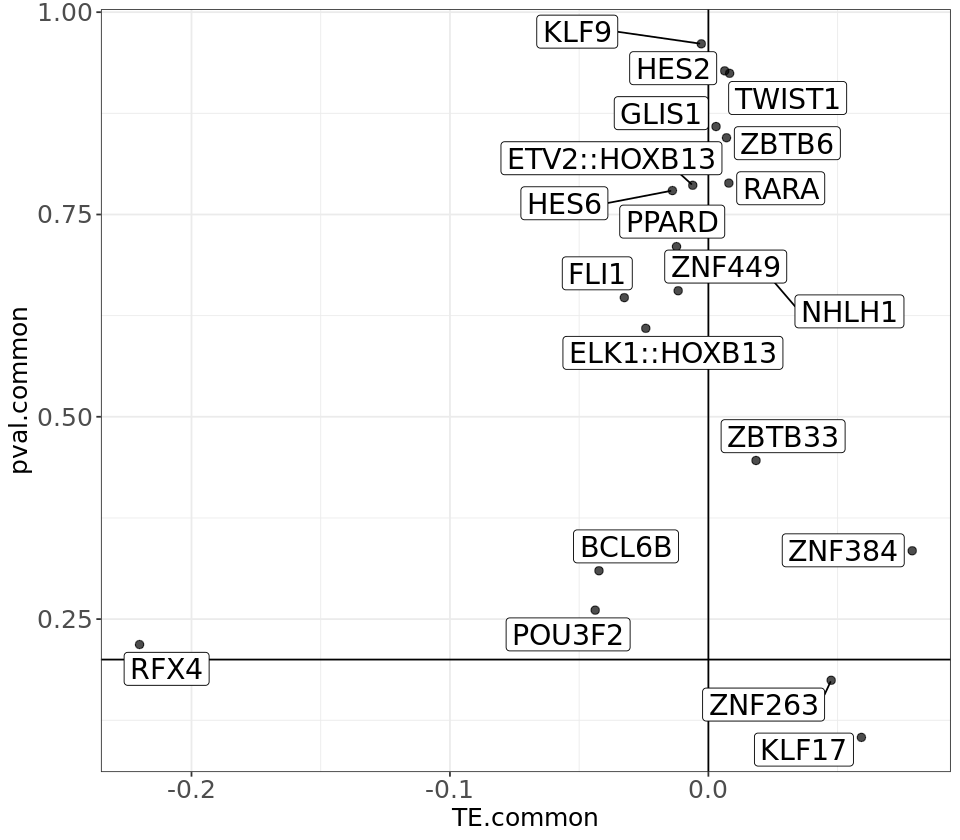

In [131]:
#add in recent chromvar results
chromvar_fp <- sprintf('/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240418_WE_%s_lmer_meta_results_common.tsv',celltype)
chromvar <- read.table(chromvar_fp, sep='\t') %>% subset(trait == trait2) %>%
                select(TE.common,statistic.common,pval.common,motif,qval.common)
#head(chromvar)

res_fin <- left_join(res, chromvar, by='motif')
res_fin$motif_short <- str_split_fixed(res_fin$motif,'_',3)[,2]
#head(res_fin)

#visualize sig and direction as reference for which are interesting
theme_set(theme_bw())
options(repr.plot.height=7,repr.plot.width=8)
ggplot(res_fin, aes(x=TE.common, pval.common, label=motif_short)) + 
    geom_point(size=2, alpha=0.7) +
    geom_vline(xintercept = 0) + geom_hline(yintercept = 0.2) +
    geom_label_repel(size=6, segment.size=0.5) + 
    theme(axis.text=element_text(size=15),
          axis.title=element_text(size=15))

In [133]:
subset(res_fin, pathway=='GOBP_RECOMBINATIONAL_REPAIR')

pathway                     motif          pval         padj.x     log2err  
28 GOBP_RECOMBINATIONAL_REPAIR MA0729.1_RARA  6.307123e-05 0.04707546 0.5384341
29 GOBP_RECOMBINATIONAL_REPAIR MA0731.1_BCL6B 6.307123e-05 0.04707546 0.5384341
30 GOBP_RECOMBINATIONAL_REPAIR MA0799.2_RFX4  6.307123e-05 0.04707546 0.5384341
   ES         NES       size database CI_L     odds_ratio CI_R     pvalue      
28 -0.5831764 -1.756296 153  GOBP     2.234925 4.621498   8.623930 6.016014e-05
29 -0.5831764 -1.756296 153  GOBP     1.929500 4.147023   7.939646 2.887283e-04
30 -0.5831764 -1.756296 153  GOBP     1.721402 3.432861   6.238842 4.107036e-04
   padj.y     num_motifs TE.common    statistic.common pval.common qval.common
28 0.03935070 3           0.007907497  0.2679039       0.7887733   0.9968712  
29 0.08176119 3          -0.042337360 -1.0157058       0.3097695   0.9968712  
30 0.09589734 3          -0.220098342 -1.2302624       0.2185988   0.9968712  
   motif_short
28 RARA       
29 BCL6B      
30 RFX4

In [134]:
subset(res_fin, pathway=='HALLMARK_APOPTOSIS')

pathway            motif           pval        padj.x     log2err  
38 HALLMARK_APOPTOSIS MA0048.2_NHLH1  0.006714081 0.06714081 0.4070179
39 HALLMARK_APOPTOSIS MA1125.1_ZNF384 0.006714081 0.06714081 0.4070179
40 HALLMARK_APOPTOSIS MA1581.1_ZBTB6  0.006714081 0.06714081 0.4070179
41 HALLMARK_APOPTOSIS MA1656.1_ZNF449 0.006714081 0.06714081 0.4070179
42 HALLMARK_APOPTOSIS MA1107.2_KLF9   0.006714081 0.06714081 0.4070179
43 HALLMARK_APOPTOSIS MA0528.2_ZNF263 0.006714081 0.06714081 0.4070179
   ES        NES      size database CI_L     odds_ratio CI_R     pvalue      
38 0.5933871 1.485304 119  HALLMARK 1.733107 3.292381   5.802514 2.452600e-04
39 0.5933871 1.485304 119  HALLMARK 1.757365 3.424275   6.145832 2.729617e-04
40 0.5933871 1.485304 119  HALLMARK 1.671768 3.256666   5.842579 4.295952e-04
41 0.5933871 1.485304 119  HALLMARK 1.719255 3.265948   5.755873 2.650180e-04
42 0.5933871 1.485304 119  HALLMARK 1.669499 2.896253   4.777634 1.313409e-04
43 0.5933871 1.485304 119  HALLMARK 1.805531 3.133120   5.169600 5.013696e-05
   padj.y     num_motifs TE.common    statistic.common pval.common qval.common
38 0.07554660 6           0.024220507  0.42459924      0.6711288   0.9968712  
39 0.07954476 6           0.078873486  0.96516934      0.3344600   0.9968712  
40 0.09803687 6           0.007013497  0.19569877      0.8448459   0.9968712  
41 0.07842310 6          -0.011688387 -0.44573244      0.6557905   0.9968712  
42 0.05663911 6          -0.002739316 -0.04902838      0.9608967   0.9968712  
43 0.03613258 6           0.047512680  1.35831741      0.1743630   0.9968712  
   motif_short
38 NHLH1      
39 ZNF384     
40 ZBTB6      
41 ZNF449     
42 KLF9       
43 ZNF263

In [135]:
subset(res_fin, pathway=='HALLMARK_TNFA_SIGNALING_VIA_NFKB')

pathway                          motif                 pval        
1  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA0527.1_ZBTB33       2.974468e-06
2  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA0475.2_FLI1         2.974468e-06
3  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA0787.1_POU3F2       2.974468e-06
4  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1493.1_HES6         2.974468e-06
5  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1514.1_KLF17        2.974468e-06
6  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1550.1_PPARD        2.974468e-06
7  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA0616.2_HES2         2.974468e-06
8  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1123.2_TWIST1       2.974468e-06
9  HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1932.1_ELK1::HOXB13 2.974468e-06
10 HALLMARK_TNFA_SIGNALING_VIA_NFKB MA1943.1_ETV2::HOXB13 2.974468e-06
   padj.x       log2err   ES        NES     size database CI_L     odds_ratio
1  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 2.013713 3.905781  
2  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 1.817853 3.433608  
3  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 1.868768 3.860015  
4  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 1.942333 4.175828  
5  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 1.592394 2.781148  
6  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 1.836120 3.792201  
7  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 2.009377 3.897317  
8  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 1.959720 3.703855  
9  0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 1.966119 4.227444  
10 0.0001487234 0.6272567 0.7160835 1.83889 152  HALLMARK 2.163655 5.173020  
   CI_R      pvalue       padj.y     num_motifs TE.common    statistic.common
1   6.965351 7.414939e-05 0.04338105 10          0.018435183  0.76210888     
2   6.005625 1.500057e-04 0.06032369 10         -0.032531320 -0.45755794     
3   7.193754 2.714179e-04 0.07930575 10         -0.043794265 -1.12392449     
4   8.001238 2.747562e-04 0.07973120 10         -0.013914536 -0.27986744     
5   4.590114 2.611929e-04 0.07792126 10          0.059207981  1.62664519     
6   7.066921 3.134390e-04 0.08486996 10         -0.012333712 -0.37145635     
7   6.950145 7.570565e-05 0.04383349 10          0.006314742  0.09099493     
8   6.482791 7.058641e-05 0.04236745 10          0.008214204  0.09488635     
9   8.101007 2.503176e-04 0.07623037 10         -0.024230462 -0.51108319     
10 10.652252 2.749096e-04 0.07976174 10         -0.006060150 -0.27144029     
   pval.common qval.common motif_short 
1  0.4459950   0.9968712   ZBTB33      
2  0.6472701   0.9968712   FLI1        
3  0.2610451   0.9968712   POU3F2      
4  0.7795792   0.9968712   HES6        
5  0.1038125   0.9968712   KLF17       
6  0.7102977   0.9968712   PPARD       
7  0.9274966   0.9968712   HES2        
8  0.9244051   0.9968712   TWIST1      
9  0.6092928   0.9968712   ELK1::HOXB13
10 0.7860524   0.9968712   ETV2::HOXB13

In [136]:
subset(res_fin, pathway=='HALLMARK_HYPOXIA')

pathway          motif          pval        padj.x     log2err   ES       
25 HALLMARK_HYPOXIA MA0735.1_GLIS1 0.002957689 0.03697111 0.4317077 0.6122577
   NES      size database CI_L     odds_ratio CI_R     pvalue       padj.y    
25 1.553967 144  HALLMARK 1.887467 4.059966   7.786694 0.0003423648 0.08830602
   num_motifs TE.common  statistic.common pval.common qval.common motif_short
25 1          0.00296052 0.1780882        0.8586537   0.9968712   GLIS1

### Pick out pathways and motifs of interest to look at results for: alpha vs. BMI
- GOBP_CELL_GROWTH: INSM1 (opposite dir but lit says interupts cell prolif!), HOXB13 (known cell growth tf, decreases with BMI), 
- GOBP_REGULATION_OF_CELL_GROWTH: (similar interesting hits as ^, pathways are prob super similar)
- Other interesting TFs: HOXD3 and GSX1/2 pop up in regards to cadherin binding, idk if there's a connection though

In [139]:
celltype <- 'alpha'
trait <- 'scaled_BMI'
trait2 <- 'BMI'
pathway_set <- 'all'

In [153]:
dir1 <- file.path(tf_mod_dir,'pathway_enrichment','all_ct_genes','sig_pathways')
res_fp <- file.path(dir1,sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.txt',celltype,trait))
res <- read.table(res_fp, sep='\t', header=1) %>% relocate(motif,.after=pathway)
dim(res)
#head(res)

[1] 172  15

In [141]:
table(subset(res, !is.na(motif))$pathway)


                            GOBP_CELL_GROWTH 
                                          37 
 GOBP_PROTEIN_LOCALIZATION_TO_CELL_PERIPHERY 
                                          19 
GOBP_PROTEIN_LOCALIZATION_TO_PLASMA_MEMBRANE 
                                          22 
              GOBP_REGULATION_OF_CELL_GROWTH 
                                          27 
 GOBP_REGULATION_OF_TRANS_SYNAPTIC_SIGNALING 
                                           1 
                       GOMF_CADHERIN_BINDING 
                                          23 
         GOMF_CELL_ADHESION_MOLECULE_BINDING 
                                           5 
                            HALLMARK_HYPOXIA 
                                           1 
                         HALLMARK_MYOGENESIS 
                                           4 
                         KEGG_FOCAL_ADHESION 
                                          13 
                 KEGG_MAPK_SIGNALING_PATHWAY 
                                 

In [145]:
sort(str_split_fixed(names(table(res$motif)),'_',2)[,2])

[1] "BACH1"        "BARX1"        "BCL6"         "BCL6B"        "CTCF"        
  [6] "CTCF"         "DLX1"         "ELK1"         "ELK1::SREBF2" "ELK3"        
 [11] "ELK4"         "ERF"          "ERF::FOXI1"   "ERF::NHLH1"   "ESX1"        
 [16] "ETV2::DRGX"   "ETV4"         "ETV5"         "ETV5::HOXA2"  "ETV7"        
 [21] "EWSR1-FLI1"   "FERD3L"       "FIGLA"        "FOS::JUN"     "FOS::JUNB"   
 [26] "FOS::JUND"    "FOSL1"        "FOSL1::JUN"   "FOSL1::JUNB"  "FOSL1::JUND" 
 [31] "FOSL2::JUN"   "FOSL2::JUND"  "FOXC2"        "FOXD2"        "FOXD3"       
 [36] "FOXJ2::ELF1"  "FOXN3"        "FOXO1::ELF1"  "FOXO1::FLI1"  "GATA6"       
 [41] "GBX1"         "GSX1"         "GSX2"         "HIC2"         "HLF"         
 [46] "HOXB13"       "HOXB8"        "HOXD3"        "HOXD8"        "INSM1"       
 [51] "IRF9"         "JUNB"         "LHX5"         "MAF::NFE2"    "MAFF"        
 [56] "MAX::MYC"     "MAZ"          "MEF2B"        "MEOX1"        "MNX1"        
 [61] "MSX1"         "MSX2"         "NFIB"         "NFIC"         "NFIC"        
 [66] "NHLH2"        "NR1H4::RXRA"  "NR2C2"        "NR2F1"        "PAX9"        
 [71] "PBX1"         "PRDM1"        "RARA::RXRG"   "RBPJ"         "RFX4"        
 [76] "SNAI1"        "SOHLH2"       "TCF12"        "TCF3"         "TCF4"        
 [81] "TCFL5"        "TFAP2B"       "TFAP2C"       "TFAP2E"       "TFEC"        
 [86] "TGIF1"        "TGIF2LX"      "TGIF2LY"      "TLX2"         "USF2"        
 [91] "VAX2"         "YY2"          "ZBTB7C"       "ZFP14"        "ZIC1"        
 [96] "ZKSCAN3"      "ZNF189"       "ZNF282"       "ZNF384"       "ZNF417"      
[101] "ZNF675"       "ZNF684"       "ZNF692"       "ZNF85"        "ZSCAN29"

Warning message:
“Removed 11 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 11 rows containing missing values (`geom_label_repel()`).”
Warning message:
“ggrepel: 158 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


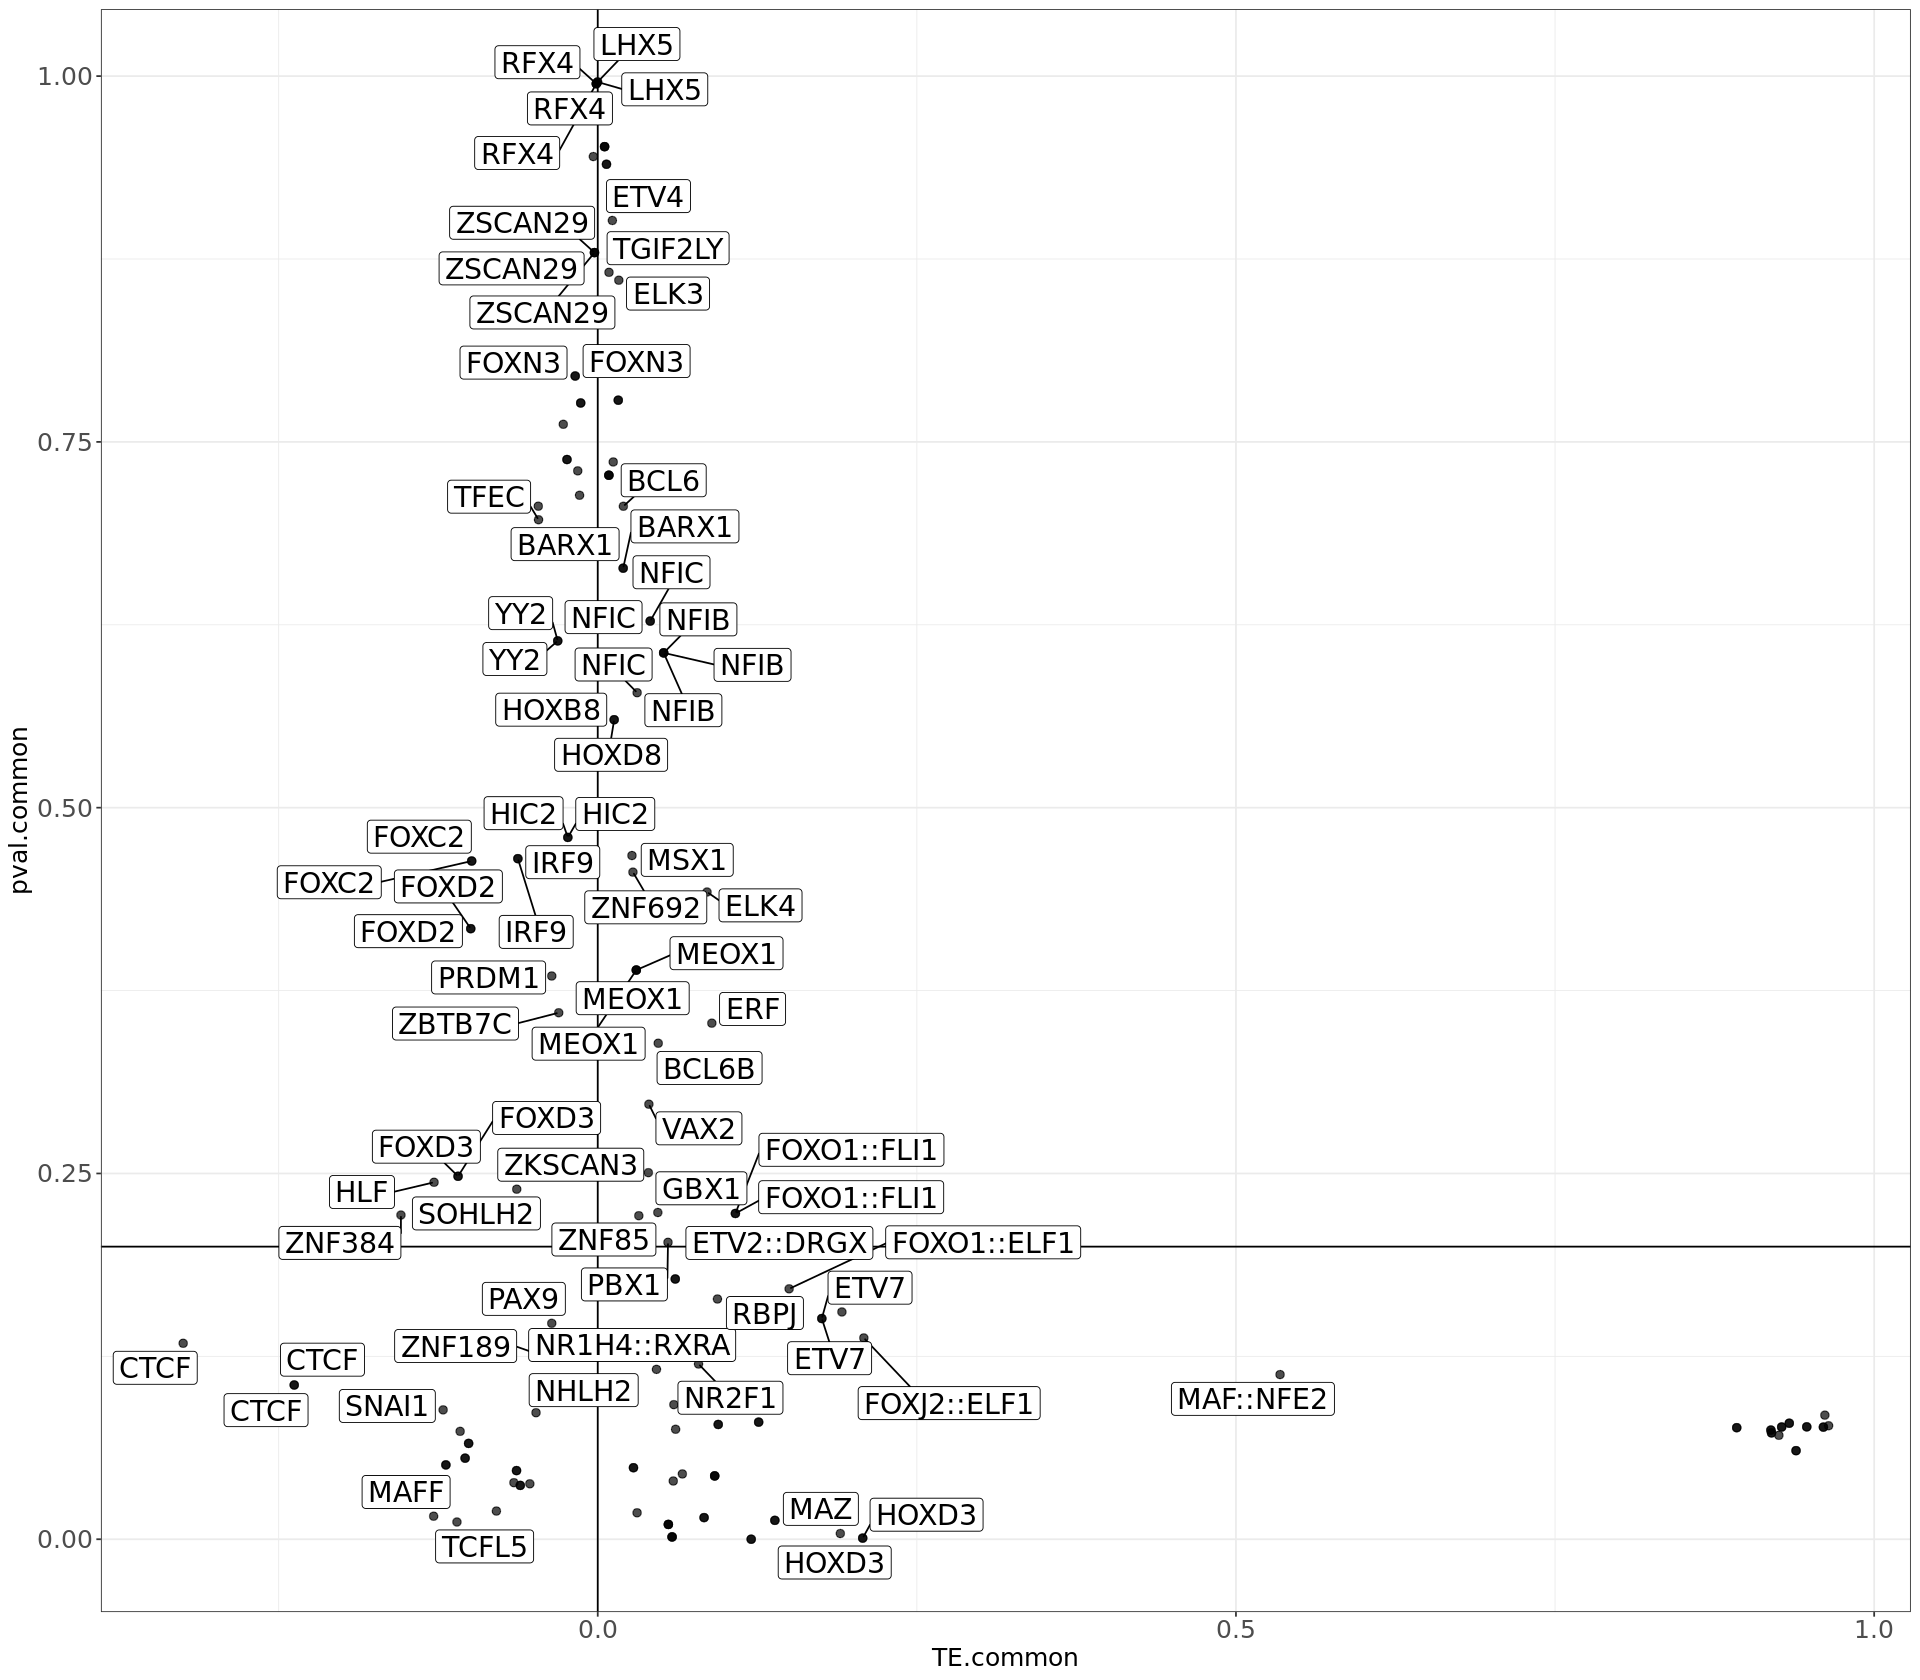

In [147]:
#add in recent chromvar results
chromvar_fp <- sprintf('/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240418_WE_%s_lmer_meta_results_common.tsv',celltype)
chromvar <- read.table(chromvar_fp, sep='\t') %>% subset(trait == trait2) %>%
                select(TE.common,statistic.common,pval.common,motif,qval.common)
#head(chromvar)

res_fin <- left_join(res, chromvar, by='motif')
res_fin$motif_short <- str_split_fixed(res_fin$motif,'_',3)[,2]
#head(res_fin)

#visualize sig and direction as reference for which are interesting
theme_set(theme_bw())
options(repr.plot.height=14,repr.plot.width=16)
ggplot(res_fin, aes(x=TE.common, pval.common, label=motif_short)) + 
    geom_point(size=2, alpha=0.7) +
    geom_vline(xintercept = 0) + geom_hline(yintercept = 0.2) +
    geom_label_repel(size=6, segment.size=0.5) + 
    theme(axis.text=element_text(size=15),
          axis.title=element_text(size=15))

In [148]:
subset(res_fin, pathway=='GOBP_CELL_GROWTH')

pathway          motif                pval         padj.x     log2err  
20 GOBP_CELL_GROWTH MA0059.1_MAX::MYC    6.378046e-06 0.01901086 0.6105269
21 GOBP_CELL_GROWTH MA0149.1_EWSR1-FLI1  6.378046e-06 0.01901086 0.6105269
22 GOBP_CELL_GROWTH MA0155.1_INSM1       6.378046e-06 0.01901086 0.6105269
23 GOBP_CELL_GROWTH MA0653.1_IRF9        6.378046e-06 0.01901086 0.6105269
24 GOBP_CELL_GROWTH MA0731.1_BCL6B       6.378046e-06 0.01901086 0.6105269
25 GOBP_CELL_GROWTH MA0738.1_HIC2        6.378046e-06 0.01901086 0.6105269
26 GOBP_CELL_GROWTH MA0781.1_PAX9        6.378046e-06 0.01901086 0.6105269
27 GOBP_CELL_GROWTH MA0846.1_FOXC2       6.378046e-06 0.01901086 0.6105269
28 GOBP_CELL_GROWTH MA0875.1_BARX1       6.378046e-06 0.01901086 0.6105269
29 GOBP_CELL_GROWTH MA1125.1_ZNF384      6.378046e-06 0.01901086 0.6105269
30 GOBP_CELL_GROWTH MA0099.3_FOS::JUN    6.378046e-06 0.01901086 0.6105269
31 GOBP_CELL_GROWTH MA1130.1_FOSL2::JUN  6.378046e-06 0.01901086 0.6105269
32 GOBP_CELL_GROWTH MA1137.1_FOSL1::JUNB 6.378046e-06 0.01901086 0.6105269
33 GOBP_CELL_GROWTH MA1142.1_FOSL1::JUND 6.378046e-06 0.01901086 0.6105269
34 GOBP_CELL_GROWTH MA1144.1_FOSL2::JUND 6.378046e-06 0.01901086 0.6105269
35 GOBP_CELL_GROWTH MA1146.1_NR1H4::RXRA 6.378046e-06 0.01901086 0.6105269
36 GOBP_CELL_GROWTH MA1485.1_FERD3L      6.378046e-06 0.01901086 0.6105269
37 GOBP_CELL_GROWTH MA1489.1_FOXN3       6.378046e-06 0.01901086 0.6105269
38 GOBP_CELL_GROWTH MA1522.1_MAZ         6.378046e-06 0.01901086 0.6105269
39 GOBP_CELL_GROWTH MA1527.1_NFIC        6.378046e-06 0.01901086 0.6105269
40 GOBP_CELL_GROWTH MA1600.1_ZNF684      6.378046e-06 0.01901086 0.6105269
41 GOBP_CELL_GROWTH MA0871.2_TFEC        6.378046e-06 0.01901086 0.6105269
42 GOBP_CELL_GROWTH MA1714.1_ZNF675      6.378046e-06 0.01901086 0.6105269
43 GOBP_CELL_GROWTH MA1720.1_ZNF85       6.378046e-06 0.01901086 0.6105269
44 GOBP_CELL_GROWTH MA1643.1_NFIB        6.378046e-06 0.01901086 0.6105269
45 GOBP_CELL_GROWTH MA0477.2_FOSL1       6.378046e-06 0.01901086 0.6105269
46 GOBP_CELL_GROWTH MA0043.3_HLF         6.378046e-06 0.01901086 0.6105269
47 GOBP_CELL_GROWTH MA0901.2_HOXB13      6.378046e-06 0.01901086 0.6105269
48 GOBP_CELL_GROWTH MA0490.2_JUNB        6.378046e-06 0.01901086 0.6105269
49 GOBP_CELL_GROWTH MA0495.3_MAFF        6.378046e-06 0.01901086 0.6105269
50 GOBP_CELL_GROWTH MA0814.2_TFAP2C      6.378046e-06 0.01901086 0.6105269
51 GOBP_CELL_GROWTH MA1973.1_ZKSCAN3     6.378046e-06 0.01901086 0.6105269
52 GOBP_CELL_GROWTH MA0041.2_FOXD3       6.378046e-06 0.01901086 0.6105269
53 GOBP_CELL_GROWTH MA0526.4_USF2        6.378046e-06 0.01901086 0.6105269
54 GOBP_CELL_GROWTH MA0799.2_RFX4        6.378046e-06 0.01901086 0.6105269
55 GOBP_CELL_GROWTH MA0847.3_FOXD2       6.378046e-06 0.01901086 0.6105269
56 GOBP_CELL_GROWTH MA1633.2_BACH1       6.378046e-06 0.01901086 0.6105269
   ES         NES       size database CI_L     odds_ratio CI_R     pvalue      
20 -0.5364037 -1.663428 381  GOBP     2.131150 3.691060   6.024724 6.932981e-06
21 -0.5364037 -1.663428 381  GOBP     1.672853 2.420059   3.413972 4.052865e-06
22 -0.5364037 -1.663428 381  GOBP     1.734035 2.648929   3.909528 1.458171e-05
23 -0.5364037 -1.663428 381  GOBP     2.203683 3.818367   6.238516 4.489087e-06
24 -0.5364037 -1.663428 381  GOBP     2.188125 4.118755   7.170840 2.196332e-05
25 -0.5364037 -1.663428 381  GOBP     1.785619 2.952234   4.643026 3.117788e-05
26 -0.5364037 -1.663428 381  GOBP     2.089576 3.929905   6.835124 3.550516e-05
27 -0.5364037 -1.663428 381  GOBP     1.797612 2.901856   4.478503 1.786887e-05
28 -0.5364037 -1.663428 381  GOBP     2.232986 4.321374   7.682819 2.653947e-05
29 -0.5364037 -1.663428 381  GOBP     1.665338 2.657631   4.062950 4.508594e-05
30 -0.5364037 -1.663428 381  GOBP     1.544383 2.280806   3.272535 4.351200e-05
31 -0.5364037 -1.663428 381  GOBP     1.563465 2.309225   3.313524 3.889499e-05
32 -0.5364037 -1.663428 381  GOBP     1.576551 2.342337   3.378034 2.836176e-05
33 -0.5364037 -1.663428 381  GOBP

In [149]:
subset(res_fin, pathway=='GOBP_REGULATION_OF_CELL_GROWTH')

pathway                        motif                pval         padj.x    
58 GOBP_REGULATION_OF_CELL_GROWTH MA0059.1_MAX::MYC    4.199025e-06 0.01901086
59 GOBP_REGULATION_OF_CELL_GROWTH MA0149.1_EWSR1-FLI1  4.199025e-06 0.01901086
60 GOBP_REGULATION_OF_CELL_GROWTH MA0155.1_INSM1       4.199025e-06 0.01901086
61 GOBP_REGULATION_OF_CELL_GROWTH MA0653.1_IRF9        4.199025e-06 0.01901086
62 GOBP_REGULATION_OF_CELL_GROWTH MA0738.1_HIC2        4.199025e-06 0.01901086
63 GOBP_REGULATION_OF_CELL_GROWTH MA0846.1_FOXC2       4.199025e-06 0.01901086
64 GOBP_REGULATION_OF_CELL_GROWTH MA0099.3_FOS::JUN    4.199025e-06 0.01901086
65 GOBP_REGULATION_OF_CELL_GROWTH MA1128.1_FOSL1::JUN  4.199025e-06 0.01901086
66 GOBP_REGULATION_OF_CELL_GROWTH MA1130.1_FOSL2::JUN  4.199025e-06 0.01901086
67 GOBP_REGULATION_OF_CELL_GROWTH MA1134.1_FOS::JUNB   4.199025e-06 0.01901086
68 GOBP_REGULATION_OF_CELL_GROWTH MA1137.1_FOSL1::JUNB 4.199025e-06 0.01901086
69 GOBP_REGULATION_OF_CELL_GROWTH MA1141.1_FOS::JUND   4.199025e-06 0.01901086
70 GOBP_REGULATION_OF_CELL_GROWTH MA1142.1_FOSL1::JUND 4.199025e-06 0.01901086
71 GOBP_REGULATION_OF_CELL_GROWTH MA1144.1_FOSL2::JUND 4.199025e-06 0.01901086
72 GOBP_REGULATION_OF_CELL_GROWTH MA1489.1_FOXN3       4.199025e-06 0.01901086
73 GOBP_REGULATION_OF_CELL_GROWTH MA1527.1_NFIC        4.199025e-06 0.01901086
74 GOBP_REGULATION_OF_CELL_GROWTH MA1714.1_ZNF675      4.199025e-06 0.01901086
75 GOBP_REGULATION_OF_CELL_GROWTH MA1643.1_NFIB        4.199025e-06 0.01901086
76 GOBP_REGULATION_OF_CELL_GROWTH MA0477.2_FOSL1       4.199025e-06 0.01901086
77 GOBP_REGULATION_OF_CELL_GROWTH MA0901.2_HOXB13      4.199025e-06 0.01901086
78 GOBP_REGULATION_OF_CELL_GROWTH MA0490.2_JUNB        4.199025e-06 0.01901086
79 GOBP_REGULATION_OF_CELL_GROWTH MA0814.2_TFAP2C      4.199025e-06 0.01901086
80 GOBP_REGULATION_OF_CELL_GROWTH MA1930.1_CTCF        4.199025e-06 0.01901086
81 GOBP_REGULATION_OF_CELL_GROWTH MA0041.2_FOXD3       4.199025e-06 0.01901086
82 GOBP_REGULATION_OF_CELL_GROWTH MA0799.2_RFX4        4.199025e-06 0.01901086
83 GOBP_REGULATION_OF_CELL_GROWTH MA0847.3_FOXD2       4.199025e-06 0.01901086
84 GOBP_REGULATION_OF_CELL_GROWTH MA1633.2_BACH1       4.199025e-06 0.01901086
   log2err   ES         NES       size database CI_L     odds_ratio CI_R    
58 0.6105269 -0.5574178 -1.708166 324  GOBP     2.134725 3.833888   6.435532
59 0.6105269 -0.5574178 -1.708166 324  GOBP     1.719615 2.545740   3.663627
60 0.6105269 -0.5574178 -1.708166 324  GOBP     1.778073 2.787895   4.204558
61 0.6105269 -0.5574178 -1.708166 324  GOBP     2.404218 4.242034   7.033396
62 0.6105269 -0.5574178 -1.708166 324  GOBP     1.841564 3.133056   5.040447
63 0.6105269 -0.5574178 -1.708166 324  GOBP     1.880773 3.112413   4.900871
64 0.6105269 -0.5574178 -1.708166 324  GOBP     1.625315 2.450405   3.578921
65 0.6105269 -0.5574178 -1.708166 324  GOBP     1.584785 2.388935   3.488766
66 0.6105269 -0.5574178 -1.708166 324  GOBP     1.645276 2.480745   3.623512
67 0.6105269 -0.5574178 -1.708166 324  GOBP     1.590529 2.431618   3.592039
68 0.6105269 -0.5574178 -1.708166 324  GOBP     1.651725 2.507422   3.683325
69 0.6105269 -0.5574178 -1.708166 324  GOBP     1.581908 2.369145   3.441457
70 0.6105269 -0.5574178 -1.708166 324  GOBP     1.695116 2.574181   3.782001
71 0.6105269 -0.5574178 -1.708166 324  GOBP     1.666663 2.530281   3.717215
72 0.6105269 -0.5574178 -1.708166 324  GOBP     2.215009 4.279596   7.592327
73 0.6105269 -0.5574178 -1.708166 324  GOBP     1.846307 3.095767   4.925090
74 0.6105269 -0.5574178 -1.708166 324  GOBP     2.071844 3.585131   5.848786
75 0.6105269 -0.5574178 -1.708166 324  GOBP     1.722057 2.780879   4.292920
76 0.6105269 -0.5574178 -1.708166 324  GOBP     1.611569 2.429583   3.548344
77 0.6105269 -0.5574178 -1.708166 324  GOBP     2.413305 4.259064   7.060501
78 0.6105269 -0.5574178 -1.708166 324  GOBP     1.624073 2.502333   3.720228
79 0.6105269 -0.5574178 -1.708166 324  GOBP     1.709488 2.614807   3.864758
80 0.6105269 -0.5574

In [152]:
#sig assoc motifs!
subset(res_fin, qval.common < 0.1)

pathway                                      motif              
3   GOBP_PROTEIN_LOCALIZATION_TO_CELL_PERIPHERY  MA1154.1_ZNF282    
22  GOBP_CELL_GROWTH                             MA0155.1_INSM1     
36  GOBP_CELL_GROWTH                             MA1485.1_FERD3L    
38  GOBP_CELL_GROWTH                             MA1522.1_MAZ       
42  GOBP_CELL_GROWTH                             MA1714.1_ZNF675    
47  GOBP_CELL_GROWTH                             MA0901.2_HOXB13    
49  GOBP_CELL_GROWTH                             MA0495.3_MAFF      
50  GOBP_CELL_GROWTH                             MA0814.2_TFAP2C    
60  GOBP_REGULATION_OF_CELL_GROWTH               MA0155.1_INSM1     
74  GOBP_REGULATION_OF_CELL_GROWTH               MA1714.1_ZNF675    
77  GOBP_REGULATION_OF_CELL_GROWTH               MA0901.2_HOXB13    
79  GOBP_REGULATION_OF_CELL_GROWTH               MA0814.2_TFAP2C    
114 GOBP_PROTEIN_LOCALIZATION_TO_PLASMA_MEMBRANE MA0696.1_ZIC1      
121 GOBP_PROTEIN_LOCALIZATION_TO_PLASMA_MEMBRANE MA0632.2_TCFL5     
135 GOMF_CADHERIN_BINDING                        MA0813.1_TFAP2B    
137 GOMF_CADHERIN_BINDING                        MA0892.1_GSX1      
139 GOMF_CADHERIN_BINDING                        MA0893.2_GSX2      
140 GOMF_CADHERIN_BINDING                        MA0912.2_HOXD3     
141 GOMF_CADHERIN_BINDING                        MA1714.1_ZNF675    
145 GOMF_CADHERIN_BINDING                        MA0814.2_TFAP2C    
155 GOMF_CELL_ADHESION_MOLECULE_BINDING          MA0892.1_GSX1      
156 GOMF_CELL_ADHESION_MOLECULE_BINDING          MA0893.2_GSX2      
157 GOMF_CELL_ADHESION_MOLECULE_BINDING          MA0912.2_HOXD3     
168 REACTOME_NERVOUS_SYSTEM_DEVELOPMENT          MA1938.1_ERF::NHLH1
    pval         padj.x      log2err   ES         NES       size database
3   3.370508e-07 0.003743286 0.6749629 -0.5891548 -1.778098 286  GOBP    
22  6.378046e-06 0.019010856 0.6105269 -0.5364037 -1.663428 381  GOBP    
36  6.378046e-06 0.019010856 0.6105269 -0.5364037 -1.663428 381  GOBP    
38  6.378046e-06 0.019010856 0.6105269 -0.5364037 -1.663428 381  GOBP    
42  6.378046e-06 0.019010856 0.6105269 -0.5364037 -1.663428 381  GOBP    
47  6.378046e-06 0.019010856 0.6105269 -0.5364037 -1.663428 381  GOBP    
49  6.378046e-06 0.019010856 0.6105269 -0.5364037 -1.663428 381  GOBP    
50  6.378046e-06 0.019010856 0.6105269 -0.5364037 -1.663428 381  GOBP    
60  4.199025e-06 0.019010856 0.6105269 -0.5574178 -1.708166 324  GOBP    
74  4.199025e-06 0.019010856 0.6105269 -0.5574178 -1.708166 324  GOBP    
77  4.199025e-06 0.019010856 0.6105269 -0.5574178 -1.708166 324  GOBP    
79  4.199025e-06 0.019010856 0.6105269 -0.5574178 -1.708166 324  GOBP    
114 5.040046e-05 0.069968444 0.5573322 -0.5761076 -1.715242 242  GOBP    
121 5.040046e-05 0.069968444 0.5573322 -0.5761076 -1.715242 242  GOBP    
135 1.017260e-04 0.086905275 0.5384341 -0.5383706 -1.624676 298  GOMF    
137 1.017260e-04 0.086905275 0.5384341 -0.5383706 -1.624676 298  GOMF    
139 1.017260e-04 0.086905275 0.5384341 -0.5383706 -1.624676 298  GOMF    
140 1.017260e-04 0.086905275 0.5384341 -0.5383706 -1.624676 298  GOMF    
141 1.017260e-04 0.086905275 0.5384341 -0.5383706 -1.624676 298  GOMF    
145 1.017260e-04 0.086905275 0.5384341 -0.5383706 -1.624676 298  GOMF    
155 8.851792e-05 0.086905275 0.5384341 -0.4888846 -1.539436 441  GOMF    
156 8.851792e-05 0.086905275 0.5384341 -0.4888846 -1.539436 441  GOMF    
157 8.851792e-05 0.086905275 0.5384341 -0.4888846 -1.539436 441  GOMF    
168 1.009114e-04 0.086905275 0.5384341 -0.4750037 -1.501594 468  REACTOME
    CI_L     odds_ratio CI_R      pvalue       padj.y     num_motifs
3   2.111194 3.965867    6.886502 3.165782e-05 0.08551398 19        
22  1.734035 2.648929    3.909528 1.458171e-05 0.06436674 37        
36  1.785504 2.882051    4.447344 1.975912e-05 0.07118727 37        
38  1.471780 2.108141    2.948527 4.763344e-05 0.09939545 37        
42  2.026961 3.401620    5.417384 7.070941e-06 0.05039606 37        
47  2.562843 4.

### Pick out pathways and motifs of interest to look at results for: beta vs. BMI
- GOBP_MICROTUBULE_BASED_MOVEMENT: FOXH1 (only sig motif)
- GOBP_REGULATION_OF_TRANSMEMBRANE_TRANSPORT:
- REACTOME_CLATHRIN_MEDIATED_ENDOCYTOSIS:
- Other interesting TFs: RARA (pops up a lot for actin related things, has a microtubule binding domain?), PAX6 is sig diff motif that decreases! (linked to a few random cardiomyopathy pathways), SMAD3 and SMAD5 increase with BMI, 

In [157]:
celltype <- 'beta'
trait <- 'scaled_BMI'
trait2 <- 'BMI'
pathway_set <- 'all'

In [158]:
dir1 <- file.path(tf_mod_dir,'pathway_enrichment','all_ct_genes','sig_pathways')
res_fp <- file.path(dir1,sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.txt',celltype,trait))
res <- read.table(res_fp, sep='\t', header=1) %>% relocate(motif,.after=pathway)
dim(res)
#head(res)

[1] 1958   15

In [159]:
table(subset(res, !is.na(motif))$pathway)


                   GOBP_ACTIN_FILAMENT_ORGANIZATION 
                                                 37 
                              GOBP_AXON_DEVELOPMENT 
                                                285 
                                      GOBP_BEHAVIOR 
                                                  1 
GOBP_CELL_MORPHOGENESIS_INVOLVED_IN_DIFFERENTIATION 
                                                140 
                       GOBP_CELL_PART_MORPHOGENESIS 
                                                229 
                      GOBP_CELL_PROJECTION_ASSEMBLY 
                                                161 
   GOBP_CILIUM_OR_FLAGELLUM_DEPENDENT_CELL_MOTILITY 
                                                  2 
                           GOBP_CILIUM_ORGANIZATION 
                                                  6 
                          GOBP_DEVELOPMENTAL_GROWTH 
                                                 30 
               GOBP_EPITHELIAL_CELL_DIFFERENT

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_label_repel()`).”
Warning message:
“ggrepel: 516 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


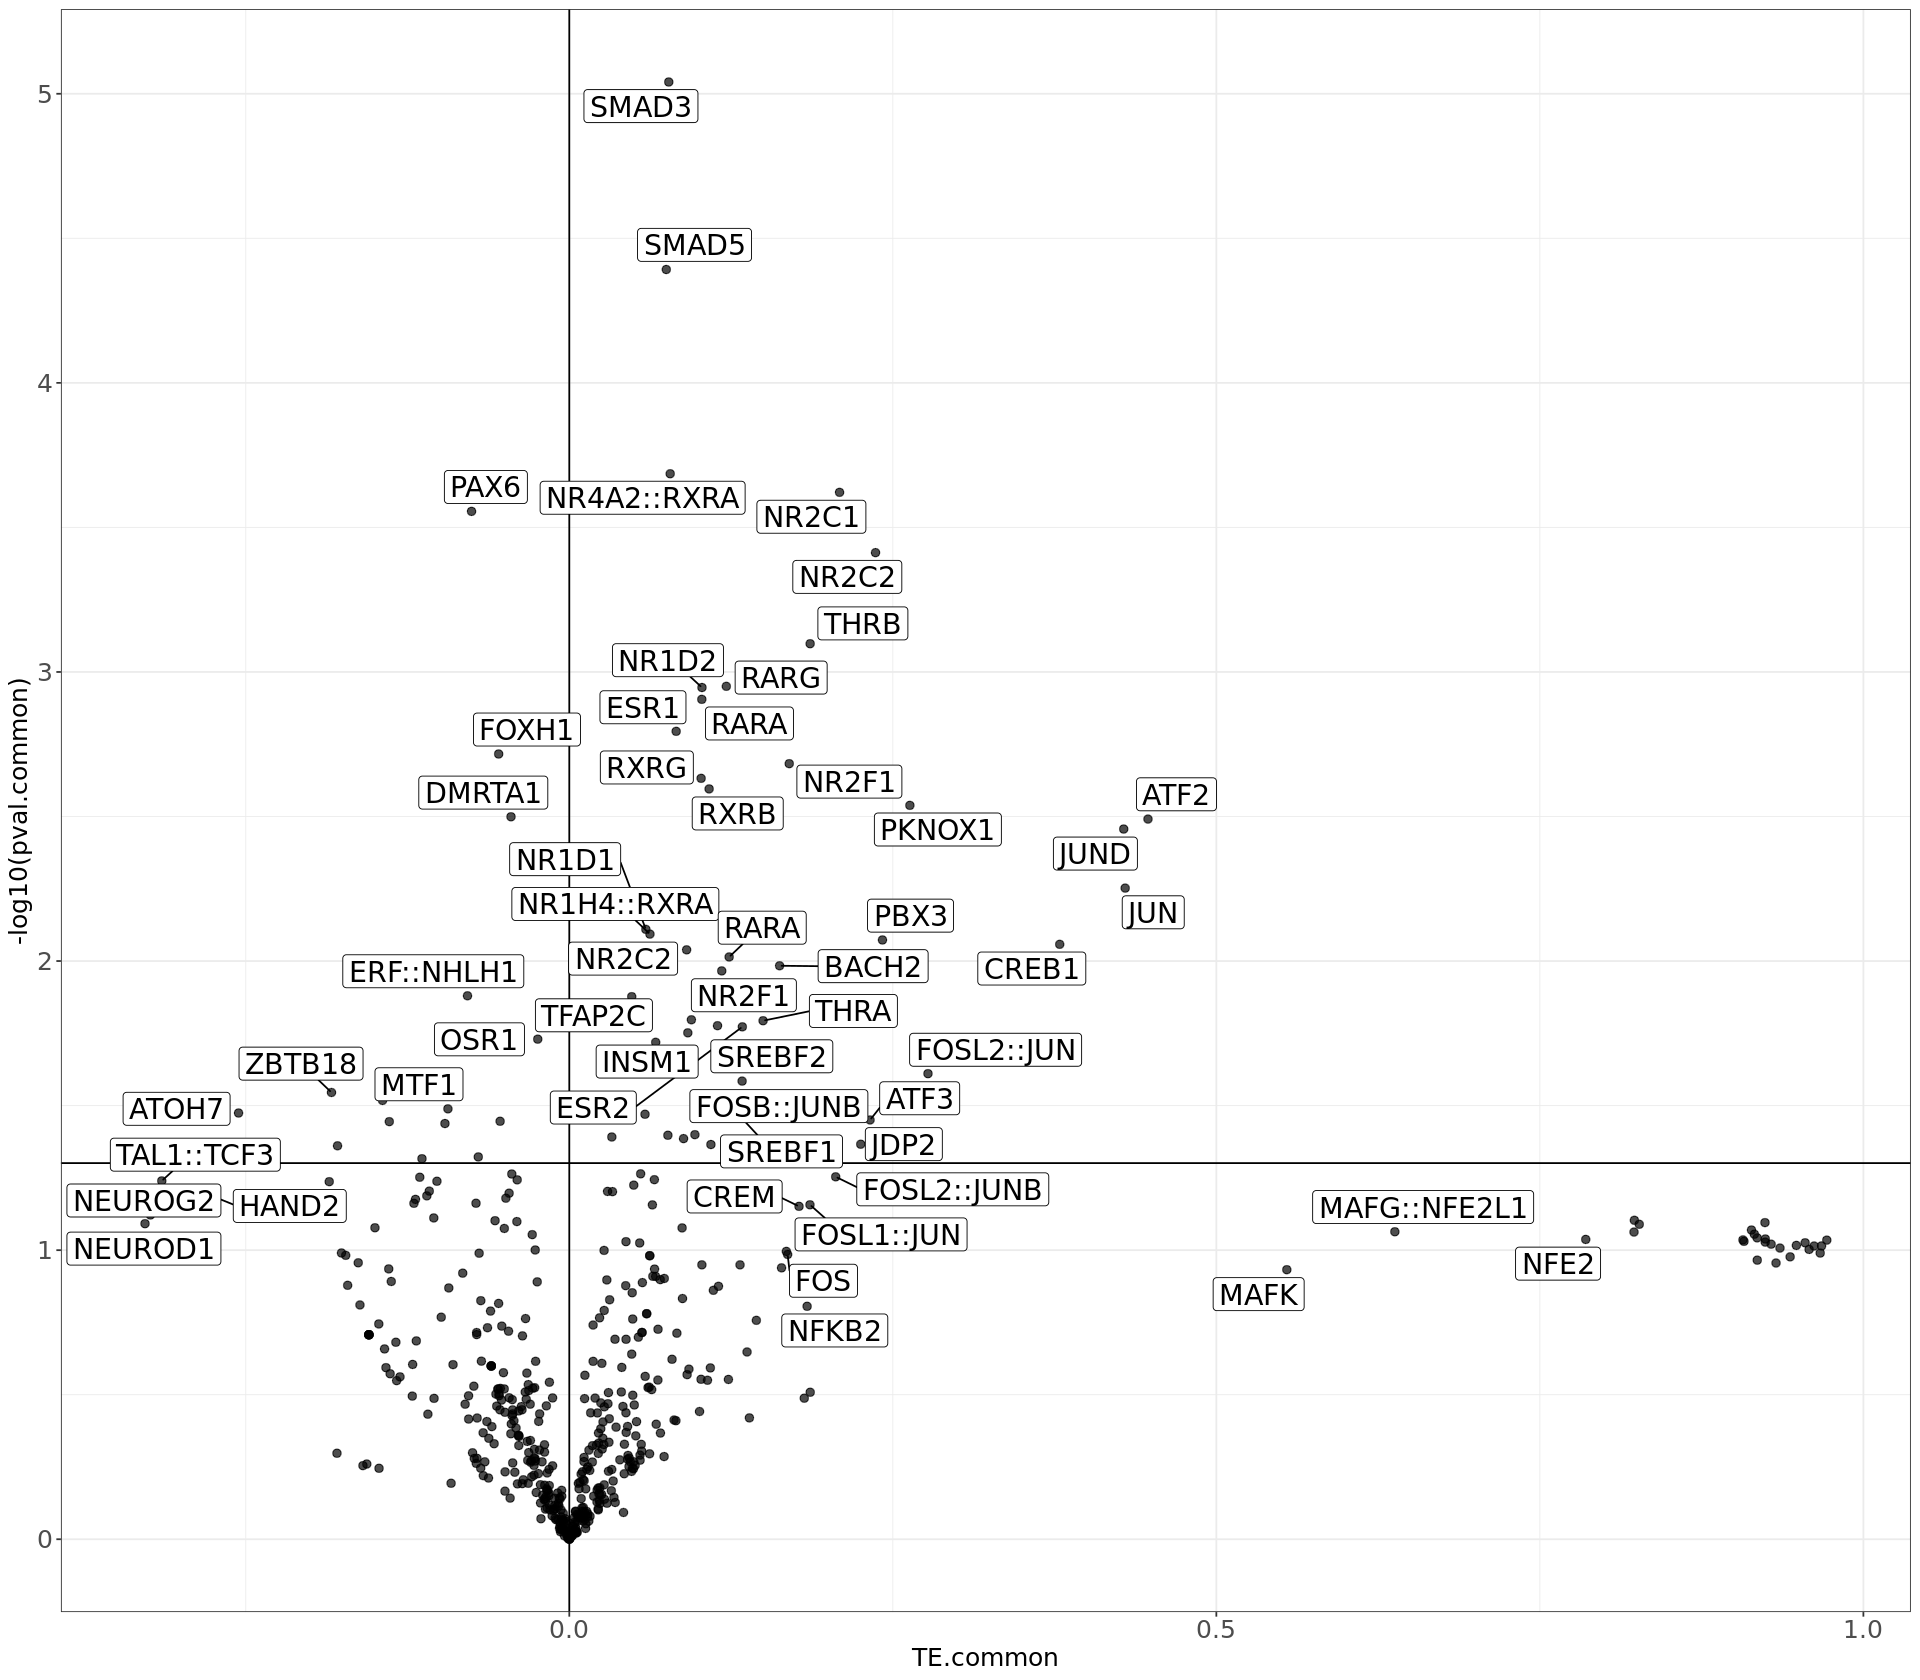

In [181]:
#add in recent chromvar results
chromvar_fp <- sprintf('/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240418_WE_%s_lmer_meta_results_common.tsv',celltype)
chromvar <- read.table(chromvar_fp, sep='\t') %>% subset(trait == trait2) %>%
                select(TE.common,statistic.common,pval.common,motif,qval.common)
#head(chromvar)

res_fin <- left_join(res, chromvar, by='motif')
res_fin$motif_short <- str_split_fixed(res_fin$motif,'_',3)[,2]
#head(res_fin)

#visualize sig and direction as reference for which are interesting
theme_set(theme_bw())
options(repr.plot.height=14,repr.plot.width=16)
ggplot(res_fin %>% distinct(motif,.keep_all=TRUE), aes(x=TE.common, y=-log10(pval.common), label=motif_short)) + 
    geom_point(size=2, alpha=0.7) +
    geom_vline(xintercept = 0) + geom_hline(yintercept = 1.30102999566398) +
    geom_label_repel(size=6, segment.size=0.5) + 
    theme(axis.text=element_text(size=15),
          axis.title=element_text(size=15))

In [164]:
subset(res_fin, pathway=='GOBP_MICROTUBULE_BASED_MOVEMENT' & pval.common < 0.05)

pathway                         motif          pval         padj.x      
1 GOBP_MICROTUBULE_BASED_MOVEMENT MA0479.1_FOXH1 1.000223e-09 1.109447e-05
  log2err   ES         NES       size database CI_L    odds_ratio CI_R    
1 0.7881868 -0.6265035 -1.891627 324  GOBP     1.65006 3.019621   5.135258
  pvalue       padj.y     num_motifs TE.common  statistic.common pval.common
1 0.0003017102 0.08342162 16         -0.0546029 -3.10202         0.001922047
  qval.common motif_short
1 0.08674123  FOXH1

In [169]:
subset(res_fin, pathway=='GOBP_REGULATION_OF_TRANSMEMBRANE_TRANSPORT' & pval.common < 0.05)

pathway                                    motif         pval       
484 GOBP_REGULATION_OF_TRANSMEMBRANE_TRANSPORT MA1552.1_RARB 8.25879e-05
    padj.x     log2err   ES         NES       size database CI_L     odds_ratio
484 0.01597087 0.5384341 -0.4991181 -1.528599 386  GOBP     1.596754 2.92261   
    CI_R     pvalue       padj.y     num_motifs TE.common  statistic.common
484 4.971281 0.0004198673 0.09688676 5          0.09156976 2.371623        
    pval.common qval.common motif_short
484 0.01771014  0.2467007   RARB

In [170]:
subset(res_fin, pathway=='REACTOME_CLATHRIN_MEDIATED_ENDOCYTOSIS')

pathway                                motif           pval        
1203 REACTOME_CLATHRIN_MEDIATED_ENDOCYTOSIS MA0713.1_PHOX2A 0.0003052467
     padj.x     log2err   ES         NES       size database CI_L    
1203 0.03847495 0.4984931 -0.6169482 -1.683862 123  REACTOME 2.073287
     odds_ratio CI_R     pvalue       padj.y     num_motifs TE.common 
1203 4.963945   10.24497 0.0003639606 0.09064903 1          -0.0190254
     statistic.common pval.common qval.common motif_short
1203 -0.4531022       0.6504751   0.7039472   PHOX2A

In [172]:
subset(res_fin, grepl('PAX6',motif))

pathway                              motif         pval         padj.x    
1223 KEGG_DILATED_CARDIOMYOPATHY          MA0069.1_PAX6 0.0004215498 0.04820444
1838 KEGG_HYPERTROPHIC_CARDIOMYOPATHY_HCM MA0069.1_PAX6 0.0013613146 0.08944029
     log2err   ES         NES       size database CI_L     odds_ratio CI_R    
1223 0.4984931 -0.7217172 -1.777383 54   KEGG     3.053437  9.894427  24.97502
1838 0.4550599 -0.7092566 -1.727854 51   KEGG     3.292832 10.705745  27.15094
     pvalue       padj.y     num_motifs TE.common   statistic.common
1223 0.0002414975 0.07504897 3          -0.07554067 -3.634675       
1838 0.0001719590 0.06410725 1          -0.07554067 -3.634675       
     pval.common  qval.common motif_short
1223 0.0002783316 0.03024165  PAX6       
1838 0.0002783316 0.03024165  PAX6

In [174]:
subset(res_fin, grepl('SMAD3',motif))

pathway                                            motif         
1473 GOMF_PHOSPHATIDYLINOSITOL_4_5_BISPHOSPHATE_BINDING MA0795.1_SMAD3
1663 GOBP_REGULATION_OF_SYSTEM_PROCESS                  MA0795.1_SMAD3
1795 GOMF_PHOSPHATIDYLINOSITOL_BISPHOSPHATE_BINDING     MA0795.1_SMAD3
     pval         padj.x     log2err   ES         NES       size database
1473 0.0007878927 0.06991445 0.4772708 -0.7022273 -1.760412  61  GOMF    
1663 0.0010878957 0.08087567 0.4550599 -0.4786355 -1.449875 342  GOBP    
1795 0.0013002304 0.08793997 0.4550599 -0.6470672 -1.668684  82  GOMF    
     CI_L     odds_ratio CI_R      pvalue       padj.y     num_motifs
1473 4.110022 13.345720  33.806446 6.189600e-05 0.03988472   4       
1663 2.439043  5.057305   9.474753 2.835059e-05 0.02743175 123       
1795 4.123855 11.785220  27.512853 2.237233e-05 0.02423710  16       
     TE.common  statistic.common pval.common  qval.common motif_short
1473 0.07686162 4.437412         9.104696e-06 0.004946278 SMAD3      
1663 0.07686162 4.437412         9.104696e-06 0.004946278 SMAD3      
1795 0.07686162 4.437412         9.104696e-06 0.004946278 SMAD3

In [173]:
#sig assoc motifs!
sort(unique(subset(res_fin, qval.common < 0.1) %>% pull(motif)))

[1] "MA0017.2_NR2F1"       "MA0069.1_PAX6"        "MA0112.3_ESR1"       
 [4] "MA0479.1_FOXH1"       "MA0492.1_JUND"        "MA0729.1_RARA"       
 [7] "MA0782.2_PKNOX1"      "MA0795.1_SMAD3"       "MA1147.1_NR4A2::RXRA"
[10] "MA1532.2_NR1D2"       "MA1535.1_NR2C1"       "MA1536.1_NR2C2"      
[13] "MA1553.1_RARG"        "MA1555.1_RXRB"        "MA1556.1_RXRG"       
[16] "MA1557.1_SMAD5"       "MA1576.1_THRB"        "MA1632.1_ATF2"       
[19] "MA1707.1_DMRTA1"

# 3b. Forest plots for TF module analysis results
What plots? We have essentially enrichment + CI data so pretty sure Forest plots it is here! (bc was a Fischer's test), and can label with significance
- Plots can be either TF centric or pathway centric, make function that can do either
- Think about how to find a way to integrate in the pathway and TF trait enrichment results too? (idk how that would look like in one fig...)

In [222]:
### Function to make a forest plot for TF and pathway enrichment
make_tf_per_pathway_plot <- function(celltype, trait1, trait2, pathway1, spec_tfs=NA, motif_pval_cutoff=0.05){
    #read in tf in pathway enrichment results
    dir1 <- file.path(tf_mod_dir,'pathway_enrichment','all_ct_genes','sig_pathways')
    res_fp <- file.path(dir1,sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.txt',celltype,trait1))
    res <- read.table(res_fp, sep='\t', header=1) %>% relocate(motif,.after=pathway)
    
    #read in chromvar trait association results too and join into one df
    chromvar_fp <- sprintf('/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240418_WE_%s_lmer_meta_results_common.tsv',celltype)
    chromvar <- read.table(chromvar_fp, sep='\t') %>% subset(trait == trait2) %>%
                    select(TE.common,lower.common,upper.common,statistic.common,pval.common,motif,qval.common)
    res_fin <- left_join(res, chromvar, by='motif')
    res_fin$motif_short <- str_split_fixed(res_fin$motif,'_',3)[,2]

    #subset to pathway of interest and specific tfs (if have any)
    data <- subset(res_fin, pathway==pathway1 & !is.na(motif))
    if(!is.na(spec_tfs)){
        data <- data %>% subset(motif %in% spec_tfs)
    }

    #final dataframe formatting for plotting
    data <- data %>% mutate(motif2=str_split_fixed(motif, '_',2)[,2]) %>%
        mutate(sig1=ifelse(padj.x<0.1,'*',''), sig2=ifelse(pval.common<motif_pval_cutoff,'*',''))
    
    #make forest plot 1 (tfs enriched in pathway)
    p1 <- ggplot(data=data, aes(x=odds_ratio, y=motif)) + 
            geom_vline(xintercept=0, color='black', alpha=0.5, size=0.5) + 
            #geom_vline(xintercept=seq(-0.2,1,0.3), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
            geom_linerange(aes(xmin=CI_L, xmax=CI_R), size=0.75) + 
            geom_point(aes(x=odds_ratio), size=7, color=colors[[celltype]]) + 
            geom_text(aes(x=odds_ratio, y=motif, label=sig1), size=10, hjust=-2, vjust=0.7, color='red') +
            xlab('Enrichment of targets in pathway') + ylab('') + labs(title=pathway) + 
            theme(plot.title=element_text(size=18, hjust=0.5),
                  axis.text.x=element_text(size=15, vjust=0.5),
                  axis.text.y=element_text(size=15, vjust=0.5),
                  axis.title.x = element_text(size=18, vjust=-0.35),
                  axis.title.y = element_text(size=18, vjust=0.5),
                  legend.position = "none", panel.border=element_rect(color='black',fill=NA, size=1))    
    if(!is.na(spec_tfs)){
        p1$data$motif <- factor(x = p1$data$motif, levels=rev(spec_tfs))
    }
    
    #make forest plot 2 (tfs associated with trait)
    p2 <- ggplot(data=data, aes(x=TE.common, y=motif)) + 
            geom_vline(xintercept=0, color='black', alpha=0.5, size=0.5) + 
            #geom_vline(xintercept=seq(-0.2,1,0.3), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
            geom_linerange(aes(xmin=lower.common, xmax=upper.common), size=0.75) + 
            geom_point(aes(x=TE.common), size=7, color=colors[[celltype]]) + 
            geom_text(aes(x=TE.common, y=motif, label=sig2), size=10, hjust=-2, vjust=0.7, color='red') +
            xlab('Association of motif with trait') + ylab('') + labs(title=trait2) + 
            theme(plot.title=element_text(size=18, hjust=0.5),
                  axis.text.x=element_text(size=15, vjust=0.5),
                  axis.text.y=element_text(size=15, vjust=0.5),
                  axis.title.x = element_text(size=18, vjust=-0.35),
                  axis.title.y = element_text(size=18, vjust=0.5),
                  legend.position = "none", panel.border=element_rect(color='black',fill=NA, size=1))    
    if(!is.na(spec_tfs)){
        p2$data$motif <- factor(x = p2$data$motif, levels=rev(spec_tfs))
    }
    
    #assemble into one composite fig
    options(repr.plot.width=12, repr.plot.height=4)
    fig <- ggarrange(p1,p2,ncol=2)
    print(fig)
}

### Beta cells and scaled age

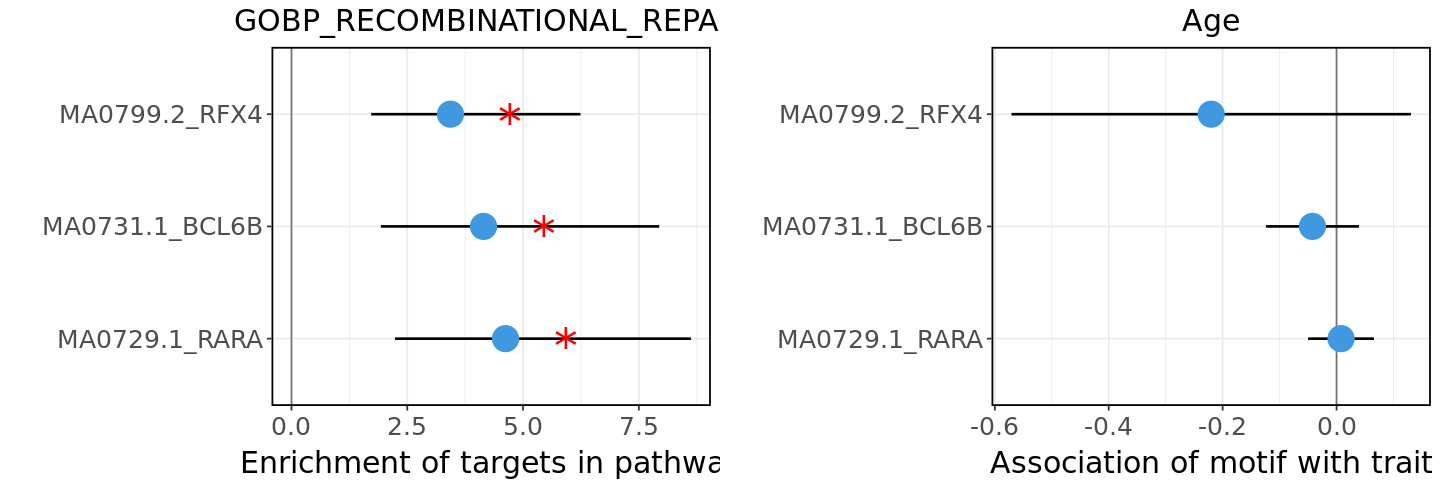

In [229]:
celltype <- 'beta'
trait1 <- 'scaled_age'
trait2 <- 'Age'
pathway <- 'GOBP_RECOMBINATIONAL_REPAIR'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.2)

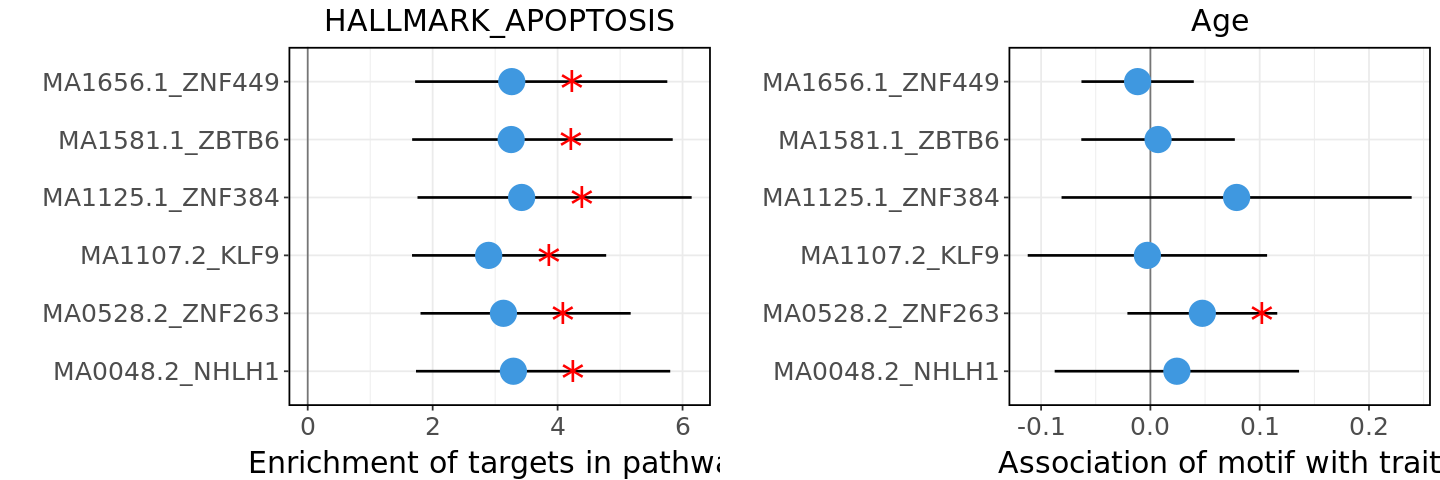

In [228]:
celltype <- 'beta'
trait1 <- 'scaled_age'
trait2 <- 'Age'
pathway <- 'HALLMARK_APOPTOSIS'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.2)

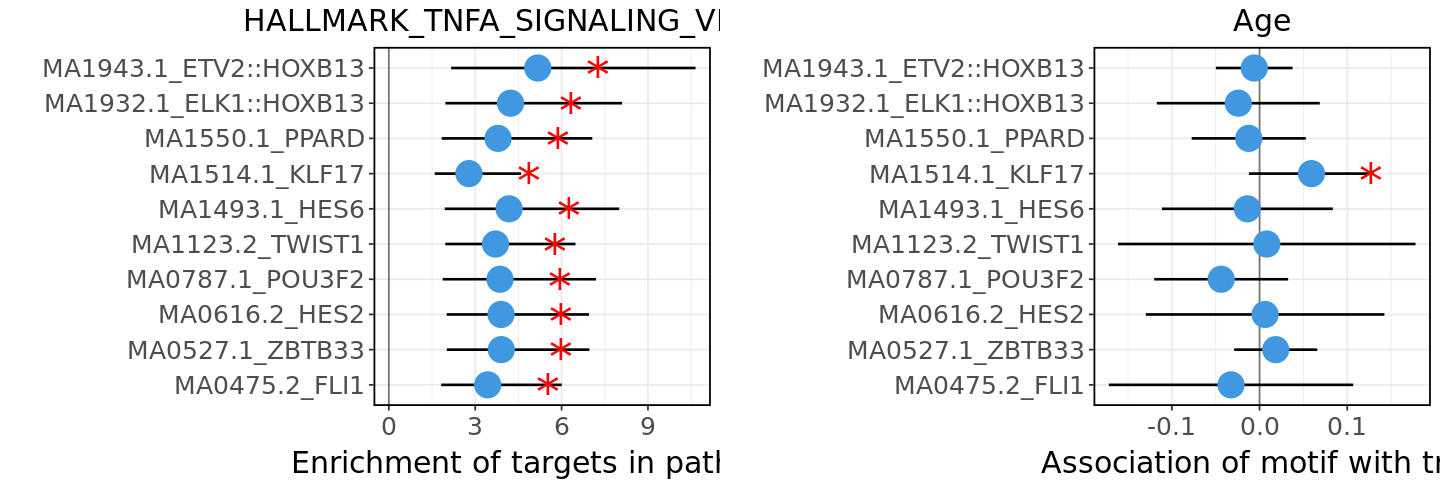

In [227]:
celltype <- 'beta'
trait1 <- 'scaled_age'
trait2 <- 'Age'
pathway <- 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.2)

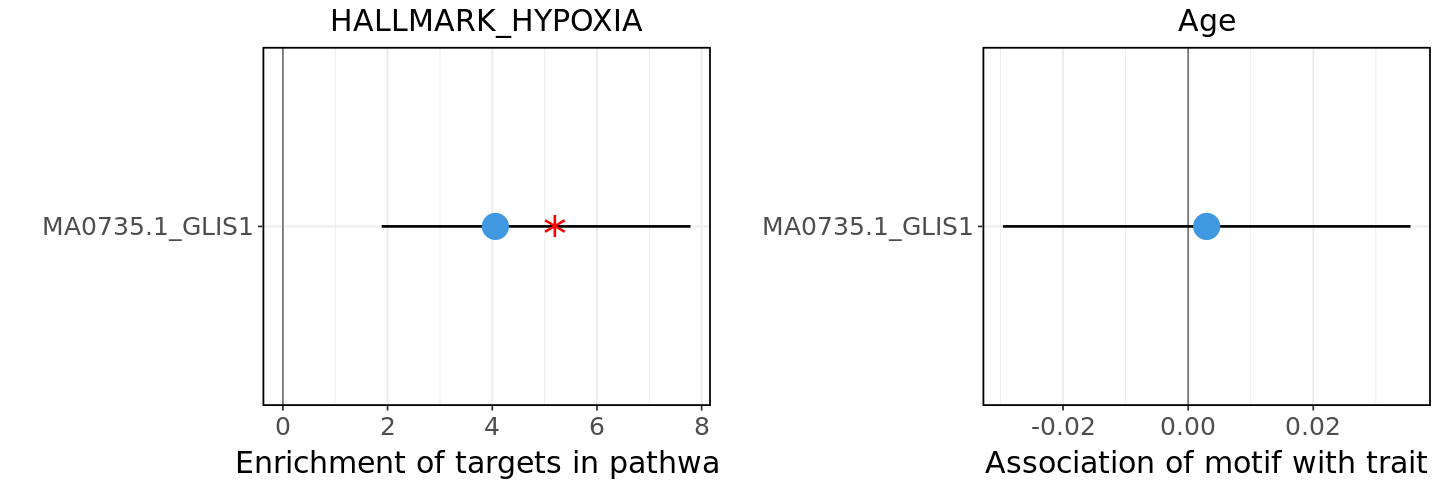

In [226]:
celltype <- 'beta'
trait1 <- 'scaled_age'
trait2 <- 'Age'
pathway <- 'HALLMARK_HYPOXIA'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.1)

### Beta cells and BMI

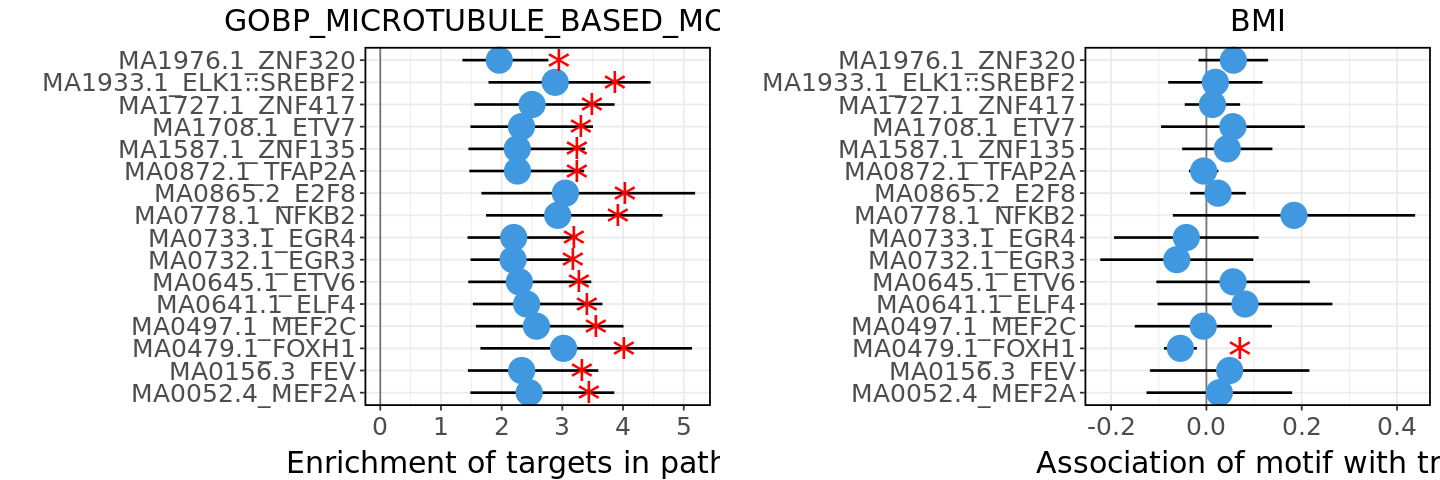

In [233]:
celltype <- 'beta'
trait1 <- 'scaled_BMI'
trait2 <- 'BMI'
pathway <- 'GOBP_MICROTUBULE_BASED_MOVEMENT'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.05)

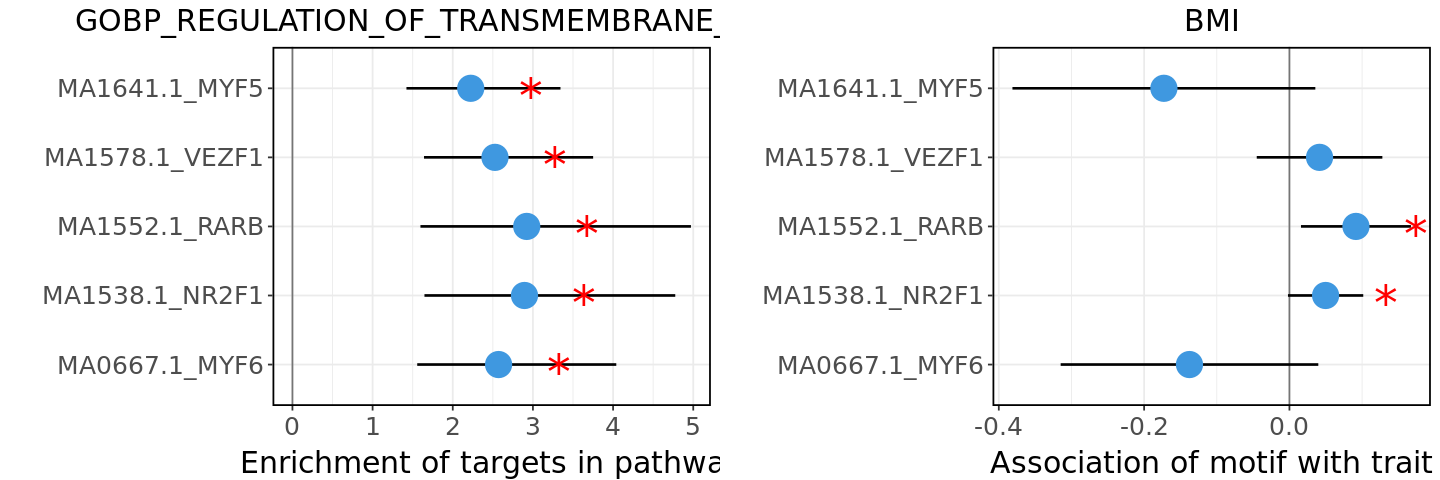

In [234]:
celltype <- 'beta'
trait1 <- 'scaled_BMI'
trait2 <- 'BMI'
pathway <- 'GOBP_REGULATION_OF_TRANSMEMBRANE_TRANSPORT'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.1)

### Alpha cells and BMI

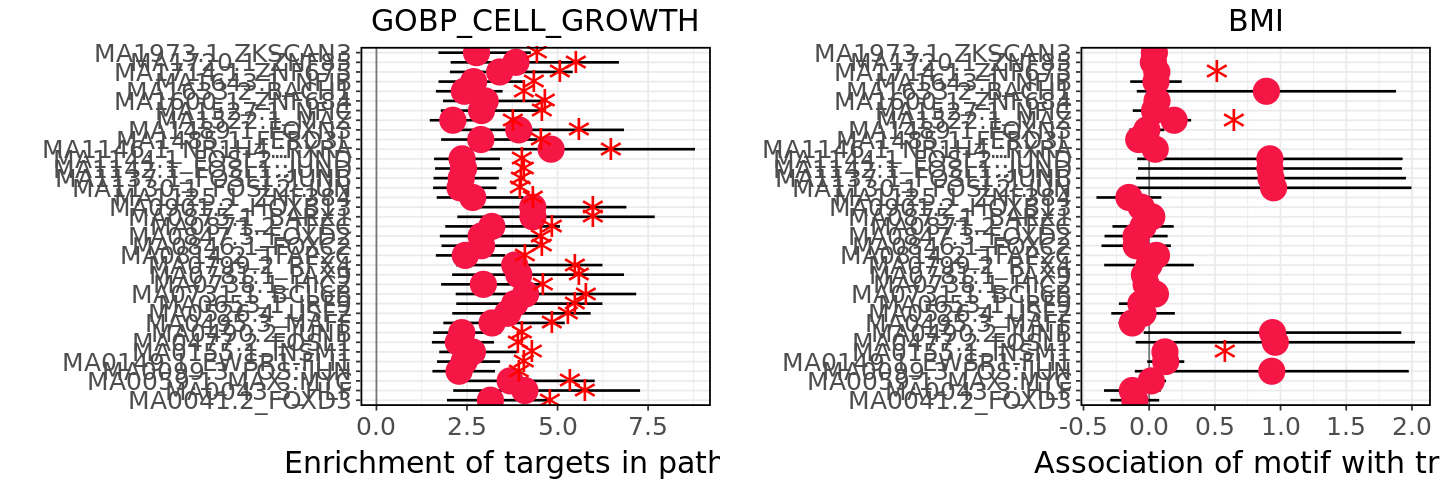

In [236]:
celltype <- 'alpha'
trait1 <- 'scaled_BMI'
trait2 <- 'BMI'
pathway <- 'GOBP_CELL_GROWTH'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.01)

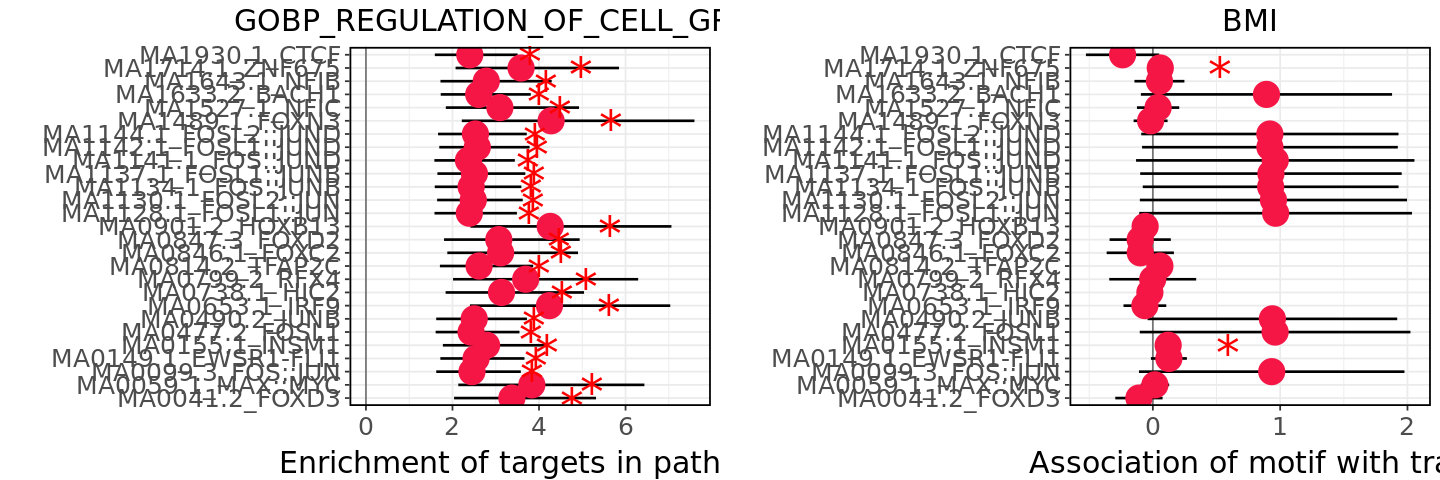

In [237]:
celltype <- 'alpha'
trait1 <- 'scaled_BMI'
trait2 <- 'BMI'
pathway <- 'GOBP_REGULATION_OF_CELL_GROWTH'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.01)

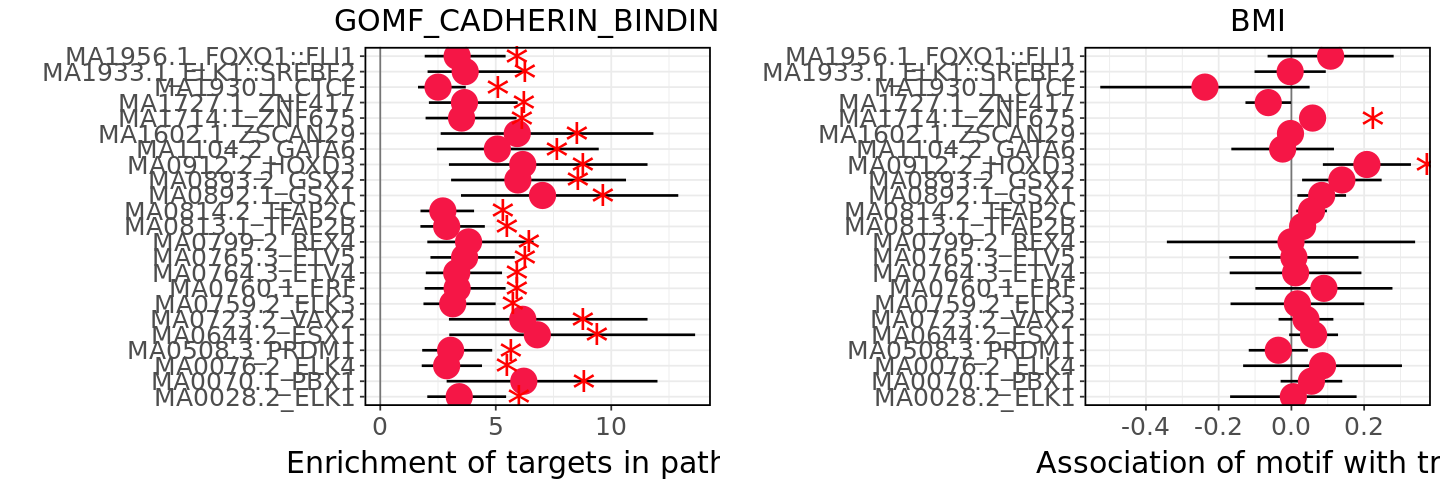

In [238]:
celltype <- 'alpha'
trait1 <- 'scaled_BMI'
trait2 <- 'BMI'
pathway <- 'GOMF_CADHERIN_BINDING'
spec_tfs <- NA

make_tf_per_pathway_plot(celltype, trait1, trait2, pathway, spec_tfs, 0.01)

# 3c: Volcano plots to highlight concordant TF modules
Not totally sure how to do this, but for now will remake the celltype-trait volcano plots and color the TF and targets differently to highlight them. Then also perform some binomial test for all TF targets and if they have concordant changes with that trait

In [473]:
### Function which reads in a DESeq output file and makes a Volcano plot 
### Based on Ruth's function EnhancedVolcano() but with my own changes
make_volcano_plot_HM <- function(df, plot_title, cell, pos_color, neg_color, max_effect=2.5, p_cutoff=0.05){
    # Add info for sig genes (only ones to label)
    # df$keyvals <- ifelse(df$qvalue < q_cutoff, ifelse(df$effect < 0,'low','high'),'mid')
    # df$color <- ifelse(df$qvalue < q_cutoff, ifelse(df$effect < 0,neg_color,pos_color),'black')
    df$keyvals <- ifelse(df$pvalue < p_cutoff, ifelse(df$effect < 0,'low','high'),'mid')
    df$color <- ifelse(df$pvalue < p_cutoff, ifelse(df$effect < 0,neg_color,pos_color),'black')
    
    # Final sorting ##### IDK WHAT THIS DOES
    keyvals.color <- df$color
    names(keyvals.color) <- df$keyvals

    ### Optional, set things with extreme effect sizes to a max value
    # df[which(df$effect > max_effect),]$effect <- max_effect
    # df[which(df$effect < -max_effect),]$effect <- -max_effect
    
    # set any 0 pvalues to smallest pvalue and manually calc horizontal line height (min sig value)
    if (min(df[['pvalue']], na.rm = TRUE) == 0) {
        df[which(df[['pvalue']] == 0), y] <- min(df[which(df[['pvalue']] != 
            0), 'pvalue'], na.rm = TRUE) * 10^-1
    }
    # pCutoff <- max(subset(df, qvalue < q_cutoff) %>% pull(pvalue))
    pCutoff <- 0.05

    #create labels just for sig genes
    df <- df %>% mutate(lab=ifelse(keyvals!='mid', gene, NA))
    
    #set x and y label limits
    xlim <- c(min(df[['effect']], na.rm = TRUE) - 0.1, max(df[['effect']], na.rm = TRUE) + 0.1)
    ylim <- c(0, max(-log10(df[['pvalue']]), na.rm = TRUE) + 1)    

    #make plot basics (points essentially)
    options(repr.plot.width=6, repr.plot.height=5)
    theme_set(theme_classic(base_size=24))
    plot <- ggplot(df, aes(x = effect, y = -log10(pvalue))) + 
            guides(colour = guide_legend(order = 1, override.aes = list(size = 5)), 
                   shape = guide_legend(order = 2, override.aes = list(size = 5))) + 
            geom_point(aes(color = factor(names(keyvals.color))), 
                       alpha = 0.5, shape = 16, size = 4, na.rm = TRUE) + 
            scale_color_manual(values = keyvals.color) + 
            scale_shape_manual(guide = TRUE) 

    #add labels for sig genes
    lengthConnectors <- unit(0.01, "npc")
    plot <- plot + geom_label_repel(data = subset(df, !is.na(df[["lab"]])), 
                                    aes(label = subset(df, !is.na(df[["lab"]]))[["lab"]]), 
                                        xlim = c(NA, NA), ylim = c(NA, NA), size = 5, 
                                        segment.color = 'grey10', segment.size = 0.5,
                                        colour = 'black', fontface = 'plain', parse = FALSE, 
                                        na.rm = TRUE, direction = 'both', 
                                        max.overlaps = 15, min.segment.length = 0,
                                        fill=NA, label.size=NA)

    #make final modifications and add theme
    plot <- plot + 
            xlab('REM effect') + ylab('-log10(p-value)') + labs(title=plot_title) +
            xlim(xlim[1], xlim[2]) + ylim(ylim[1], ylim[2]) + 
            geom_vline(xintercept = 0, linetype = 'longdash', colour = 'black', size = 0.4) + 
            geom_hline(yintercept = -log10(pCutoff), linetype = 'longdash', colour = 'black', size = 0.4)
    
    #set theme
    plot <- plot + theme(legend.background = element_rect(), 
                         plot.title = element_text(angle = 0, size = 18, face = "bold", vjust = 1), 
                         axis.text.x = element_text(angle = 0, size = 18, vjust = 1), 
                         axis.text.y = element_text(angle = 0, size = 18, vjust = 0.5), 
                         axis.title = element_text(size = 18), 
                         legend.position = 'none', 
                         title = element_text(size = 14),
                         #panel.grid.major=element_line(color='grey', size=0.5, linetype=1),
                         panel.border=element_rect(color='black',fill=NA, size=1))
    return(plot)
}

In [417]:
volcano_wrapper2 <- function(celltype, trait, tf, tf_targets){
    # Read in DESeq results dataframe and subset to autosomal genes IF sex association
    fp <- file.path(rna_degs_dir, trait, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
    df <- read.table(fp, sep='\t', header=TRUE)
    df <- df %>% tibble::rownames_to_column(var='gene')
    if (trait == 'sex'){
        df <- subset(df, gene %in% auto_genes)
    }

    #subset to tf and targets!
    df <- df %>% subset(gene %in% c(tf, tf_targets))
    
    # Make plot
    fp <- file.path(outdir, sprintf('2c_RNA_assoc_%s_vs_%s_volcano.svg',celltype,trait))
    #pdf(fp, height=6, width=6)
    title <- sprintf('%s cells and %s: %s module', str_to_title(celltype), gsub('scaled_','',trait), tf)
    p1 <- make_volcano_plot_HM(as.data.frame(df), title, celltype, rna_pal[1], rna_pal[5], 2)
    print(p1)
    #dev.off()
}

# TO DO: convert this to code that tests if a TF is enriched in concordant targets -- for all TFs (report which dir targets are assoc with?)
Not totally sure which TFs to apply this to? All those sign enriched for pathways of interest, then can know pathway dir for reference???? UGH

Could also subset for targets from different link methods (like multiple overlap, or all ABC, etc)

[1] 551


Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


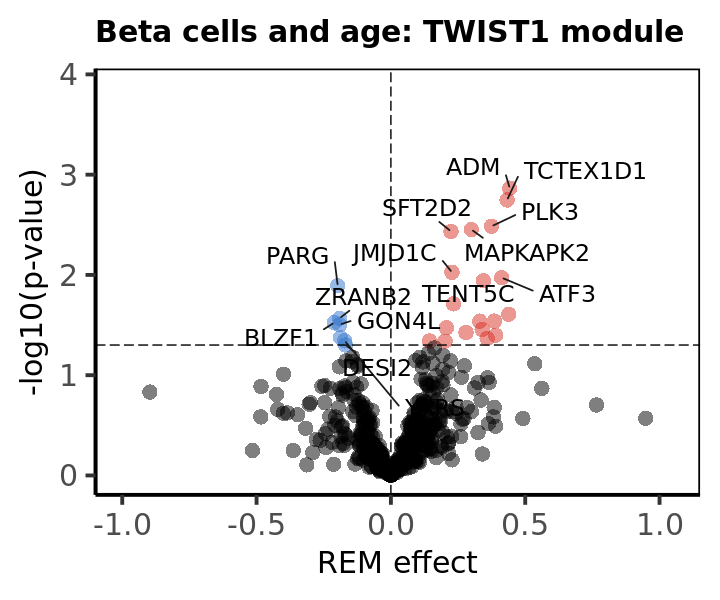

In [474]:
celltype <- 'beta'
trait <- 'scaled_age'
tf <- 'MA1123.2_TWIST1'
tf2 <- 'TWIST1'

#first read in the tf targets from the module file
mods_fp <- file.path(tf_mod_dir,sprintf('%s_90per_filt_TF_gene_TPM1_links.txt',celltype))
mods <- fread(mods_fp)
tf_targets <- mods %>% subset(TF==tf) %>% pull(gene)
print(length(tf_targets))
#head(mods)

volcano_wrapper2(celltype, trait, tf2, tf_targets)

[1] 371


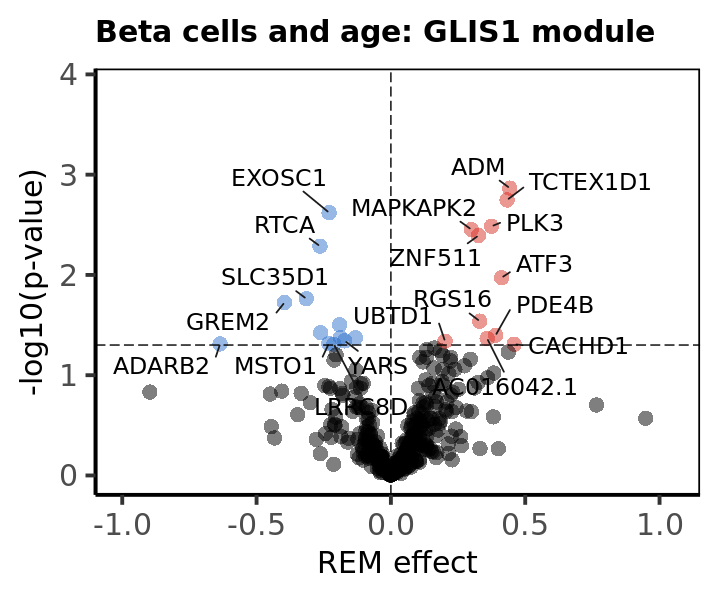

In [475]:
celltype <- 'beta'
trait <- 'scaled_age'
tf <- 'MA0735.1_GLIS1'
tf2 <- 'GLIS1'

#first read in the tf targets from the module file
mods_fp <- file.path(tf_mod_dir,sprintf('%s_90per_filt_TF_gene_TPM1_links.txt',celltype))
mods <- fread(mods_fp)
tf_targets <- mods %>% subset(TF==tf) %>% pull(gene)
print(length(tf_targets))
#head(mods)

volcano_wrapper2(celltype, trait, tf2, tf_targets)

[1] 334


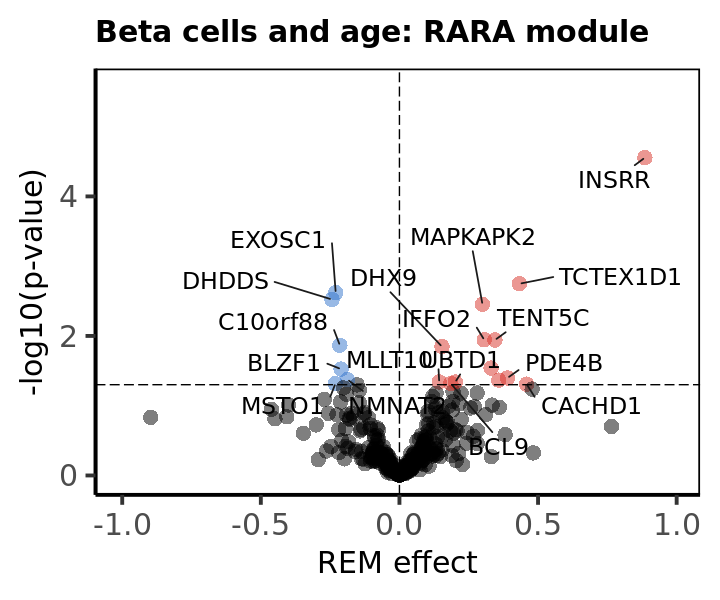

In [476]:
celltype <- 'beta'
trait <- 'scaled_age'
tf <- 'MA0729.1_RARA'
tf2 <- 'RARA'

#first read in the tf targets from the module file
mods_fp <- file.path(tf_mod_dir,sprintf('%s_90per_filt_TF_gene_TPM1_links.txt',celltype))
mods <- fread(mods_fp)
tf_targets <- mods %>% subset(TF==tf) %>% pull(gene)
print(length(tf_targets))
#head(mods)

volcano_wrapper2(celltype, trait, tf2, tf_targets)

In [462]:
#get relevant metadata for associations of interest
res_fp <- file.path(outdir,sprintf('%s_%s_ALL_TF_pathway_enrichments_fischer.SIG_PATHWAYS+MOTIFS.assoc_concordance.txt',celltype, trait))
res <- read.table(res_fp, sep='\t', header=1)
# head(res)
print(subset(res, pval_concord < 0.05))

                            pathway         pval       padj.x   log2err
3  HALLMARK_TNFA_SIGNALING_VIA_NFKB 2.974468e-06 0.0001487234 0.6272567
8  HALLMARK_TNFA_SIGNALING_VIA_NFKB 2.974468e-06 0.0001487234 0.6272567
11                 HALLMARK_HYPOXIA 2.957689e-03 0.0369711117 0.4317077
12      GOBP_RECOMBINATIONAL_REPAIR 6.307123e-05 0.0470754572 0.5384341
           ES       NES size database     CI_L odds_ratio     CI_R       pvalue
3   0.7160835  1.838890  152 HALLMARK 1.868768   3.860015 7.193754 2.714179e-04
8   0.7160835  1.838890  152 HALLMARK 1.959720   3.703855 6.482791 7.058641e-05
11  0.6122577  1.553967  144 HALLMARK 1.887467   4.059966 7.786694 3.423648e-04
12 -0.5831764 -1.756296  153     GOBP 2.234925   4.621498 8.623930 6.016014e-05
             motif     padj.y num_motifs      prob    CI_L.1    CI_R.1
3  MA0787.1_POU3F2 0.07930575         10 0.5646766 0.5146401 0.6137540
8  MA1123.2_TWIST1 0.04236745         10 0.5454545 0.5023392 0.5880689
11  MA0735.1_GLIS1 0.088306

# 4. Alt approach: create pathways from TF modules and rerun trait association fGSEA

## 4b. Create cell type TF module gmt files

In [84]:
### Function to create gmt file
make_tf_mod_gmt <- function(celltype, gmt_dir){
    #read in modules TF-cres-genes summary df 
    fp <- file.path(tf_mod_dir, sprintf('%s_90per_filt_TF_gene_TPM1_links.txt',celltype))
    mods <- read.table(fp, sep='\t', header=1)
    mods <- mods %>% 
            select(-c(num_links,all_cres,all_methods,num_genes))

    #make and write gmt file
    gmt_tfModules<- data.frame(id=mods$TF, name = celltype, gene = mods$gene)
    out_fp <- file.path(gmt_dir, sprintf('%s_90per_filt_TF_gene_TPM1_mods.gmt',celltype))
    writeGMT(gmt_tfModules, out_fp)
}

In [85]:
tf_mod_dir <- file.path(outdir,'tf_modules','CPM5')
gmt_dir <- file.path(outdir,'tf_modules','CPM5','gmts')

In [87]:
for(celltype in joint_celltypes){
    make_tf_mod_gmt(celltype, gmt_dir)
}

## 4b. Run fGSEA on RNA REM meta results

In [88]:
### Function to run fGSEA and write outputs to a file
run_fGSEA_on_REM <- function(celltype, trait, pathways, pathways_name, outdir, only_auto=FALSE){
    #read in REM results and calculate rank?
    fp <- file.path(deseq_outdir, trait, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
    df <- read.table(fp, sep='\t', header=1)
    
    # If only_auto==TRUE, remove any genes on sex chromosomes
    if(only_auto==TRUE){
        ref_df <- read.table('/nfs/lab/ABC/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE)
        auto_genes <- subset(ref_df, !grepl('X|Y',V1)) %>% pull(V4)
        df_fin <- df[row.names(df) %in% auto_genes,]
    } else{
        df_fin <- df
    }
    rank <- -log10(df_fin$pvalue) * df_fin$effect
    names(rank) <- rownames(df_fin)

    #Run fGSEA
    res <- fgsea(pathways = pathways, 
                 stats    = rank,
                 eps      = 0.0,
                 minSize  = 0,
                 maxSize  = Inf)

    # Output results to a file (sorted by padj)
    out_fp <- file.path(outdir, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
    fwrite(res[order(res$padj),], file=out_fp, sep="\t", sep2=c("", " ", ""))
}

In [89]:
traits <- c('scaled_age','scaled_BMI','scaled_HbA1c','sex')
rna_celltypes <- c('beta','alpha','delta','acinar','ductal','endothelial','stellate')

In [92]:
#read in all cell type tf module pathways
ct_pathways <- list()
for(celltype in joint_celltypes){
    gmt_fp <- file.path(gmt_dir, sprintf('%s_90per_filt_TF_gene_TPM1_mods.gmt',celltype))
    ct_pathways[[celltype]] <- gmtPathways(gmt_fp)
}

In [91]:
deseq_outdir <- file.path(outdir,'RNA','REM_meta')
fgsea_outdir <- file.path(outdir, 'tf_modules','CPM5','fGSEA')

In [94]:
for(trait in traits){
    trait_outdir <- file.path(fgsea_outdir, trait)
    dir.create(trait_outdir, showWarnings=FALSE)
    for(celltype in joint_celltypes[-4]){
        pathways <- ct_pathways[[celltype]]
        run_fGSEA_on_REM(celltype, trait, pathways, 'tf_mods', trait_outdir, FALSE)
    }
}

## 4c. Summarize results

In [98]:
### summarize sig genes results (plot with up and down as + and -)
summarize_REM_pathways <- function(traits, celltypes, pathways_name, fgsea_outdir, colors, padj_cutoff=0.1){
    #collect up and down info separately
    summary_df_up <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
            df <- read.table(fp, sep='\t', header=TRUE)
            num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$ES > 0,])[1])
        }
        summary_df_up <- rbind(summary_df_up, num_sig)
    }
    colnames(summary_df_up) <- traits

    summary_df_down <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
            df <- read.table(fp, sep='\t', header=TRUE)
            num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$ES < 0,])[1])
        }
        summary_df_down <- rbind(summary_df_down, num_sig)
    }
    colnames(summary_df_down) <- traits

    #merge up/down dfs into one dataframe
    summary_df_up$celltype <- celltypes
    summary_df_down <- -summary_df_down
    summary_df_down$celltype <- celltypes
    data <- rbind(melt(summary_df_up, id.vars='celltype'), melt(summary_df_down, id.vars='celltype'))

    # Make grouped barplot of desired metadata
    options(repr.plot.width=16, repr.plot.height=8)
    theme_set(
        theme_classic())

    p1 <- ggplot(data, aes(fill=celltype, y=value, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            geom_hline(yintercept=0) + 
            labs(x = "Celltype", y='Num sig pathways', color="Cell Type", title=pathways_name) + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

Warning message in melt(summary_df_up, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_up). In the next version, this warning will become an error.”
Warning message in melt(summary_df_down, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_down). In the next version, this warning will become an error.”
Warning me

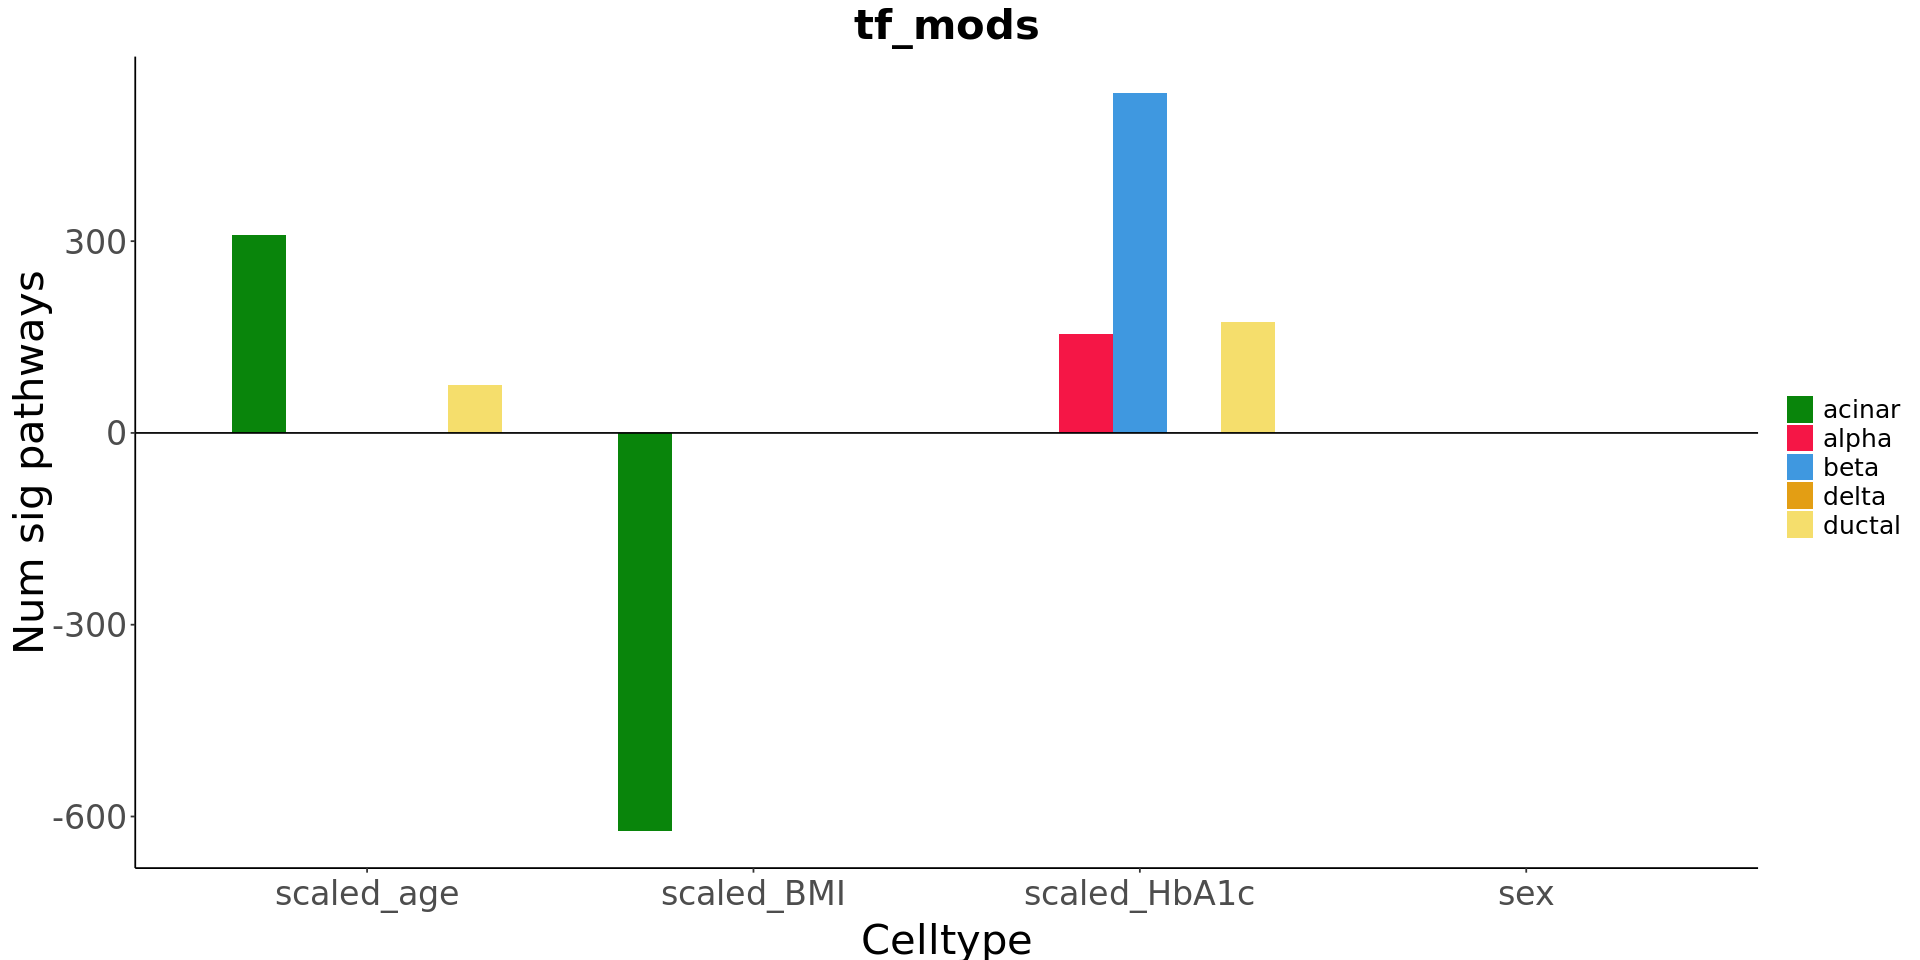

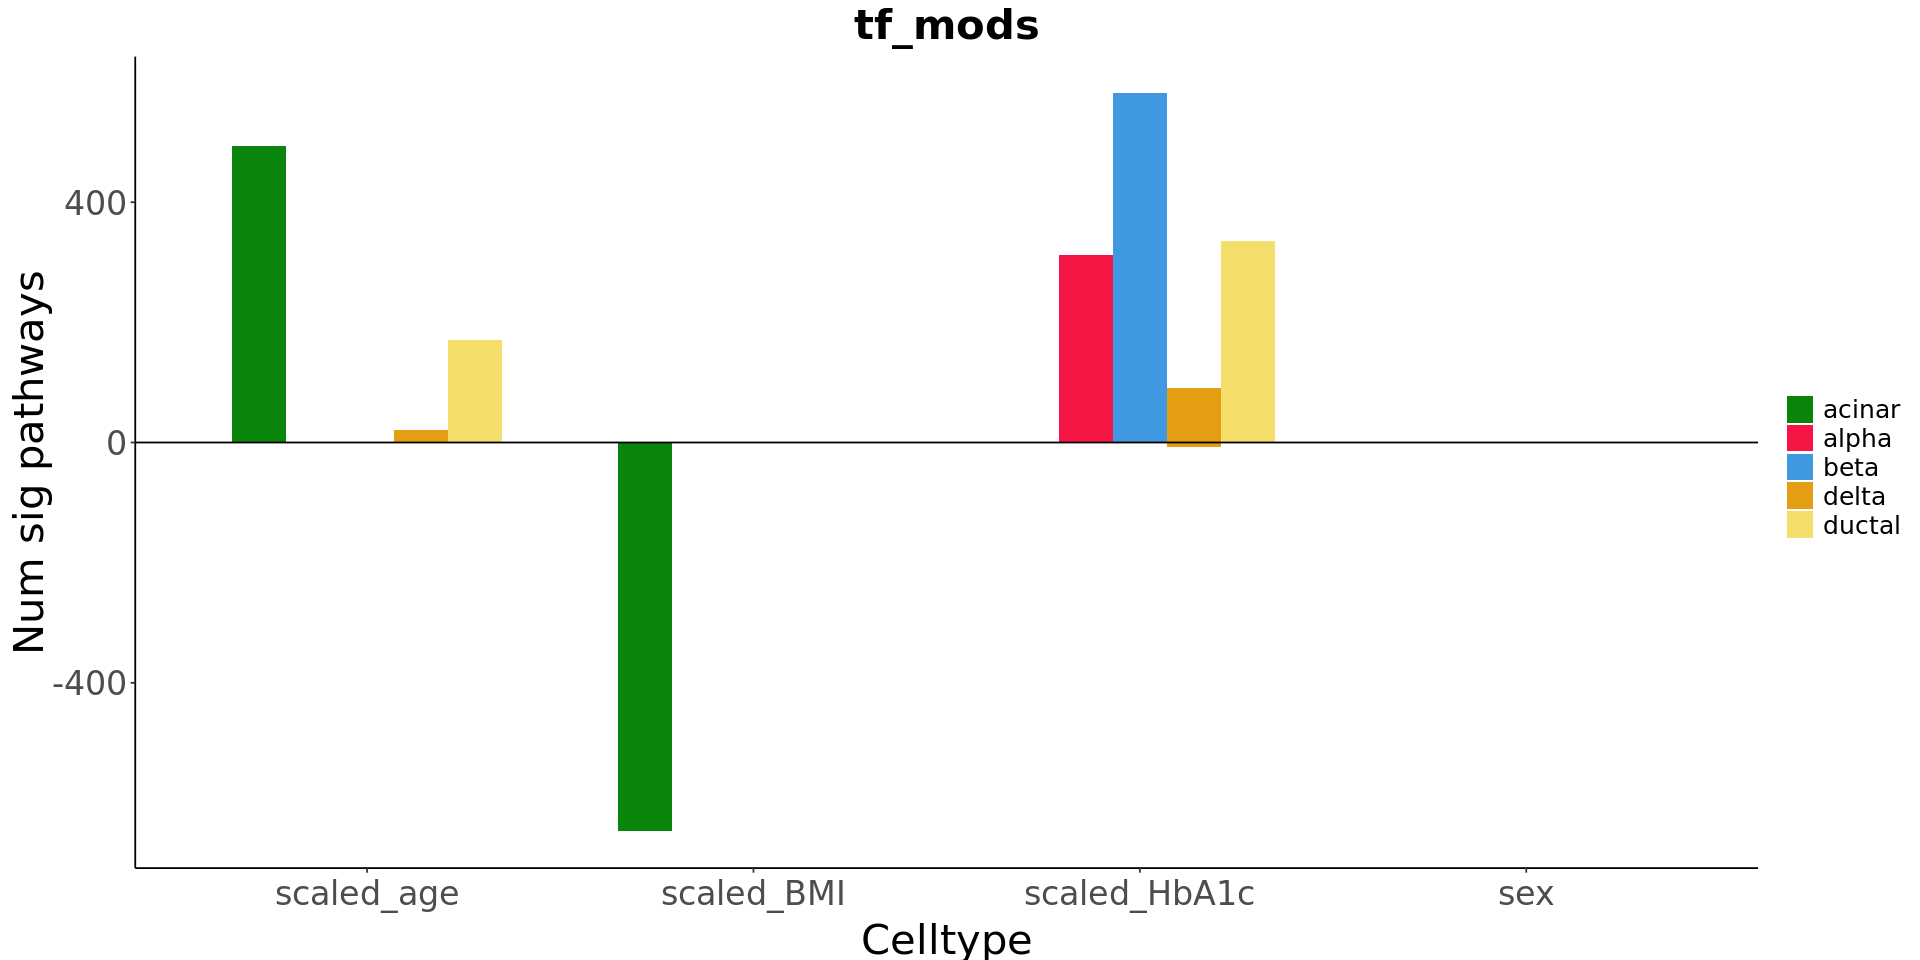

In [100]:
summarize_REM_pathways(traits, joint_celltypes[-4], 'tf_mods', fgsea_outdir, colors, padj_cutoff=0.1)
summarize_REM_pathways(traits, joint_celltypes[-4], 'tf_mods', fgsea_outdir, colors, padj_cutoff=0.2)

## Also make some pathway summary barplots just bc

In [131]:
#adapting previous plotting function to just make one plot at a time so I can make a composite plot more easily
gsea_one_dir_plt <- function(data, cell, var, color, numpathways, labelthresh, plt_dir){
    plt_title <- sprintf('%s %s-regulated pathways (-log10p)', var, plt_dir)

    #prepare df for plotting
    data$LOG10P <- -log10(data$pval)
    data <- data[order(data$pval),]

    #cut df down to just up/down pathways
    if (plt_dir == 'up'){
        plt_data <- data[which(data$ES > 0),][c(1:numpathways),]        
    } else if (plt_dir == 'down'){
        plt_data <- data[which(data$ES < 0),][c(1:numpathways),]            
    }
    
    #before preceding, make sure there are still things to plot
    #check if still have any pathways after selecting up/down
    plt_data <- na.omit(plt_data)
    make_plot <- ifelse(dim(plt_data)[1] > 0, TRUE, FALSE)
    
    if (make_plot == TRUE){        
        #factor pathways (idk why)
        plt_data$pathway <- factor(plt_data$pathway, levels= plt_data$pathway)
        plt_data$pathway <- fct_rev(plt_data$pathway)

        #make plot 
        plt <- ggplot(plt_data) +
                      geom_col(aes(LOG10P, pathway), fill= color, width = 0.9) + theme_classic() + 
                      scale_x_continuous(limits = c(0, (ceiling(max(plt_data$LOG10P, na.rm = TRUE)) + 0.5)),
                        breaks = seq(0, ceiling(max(plt_data$LOG10P, na.rm = TRUE)), by = 3), 
                        expand = c(0, 0), # The horizontal axis does not extend to either side
                        position = 'top') + # Labels are located on the top
                      scale_y_discrete(expand = expansion(add = c(0, 0.5))) +
                      theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16)) + 
                      geom_shadowtext(
                        data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = pathway, label = pathway),
                        hjust = 0,
                        nudge_x = 0.3,
                        colour = 'white',
                        bg.colour = color,
                        bg.r = 0.2,
                        size = 10) + 
                      geom_text(data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = pathway, label = pathway),
                        hjust = 0,nudge_x = 0.3,colour = 'white',size = 10) +
                      labs(title = '', subtitle = plt_title) +
                      theme(plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))  
        
    #if no data passes sig threshold return blank plot
    } else {
        plt <- ggplot(plt_data) + 
                    geom_blank() + 
                    labs(title = '', subtitle = plt_title) +
                    theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16),
                        plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    }
    return(plt)
}

In [132]:
### Short wrapper function for Ruth's plots, reads in res from a fp and then filters for padj threshold
### 7/12/23: adapted to make all plots for each trait for a cell type using new function and ggarrange them
make_ct_pathway_plots <- function(celltype, traits, fgsea_outdir, pathways_name, threshold, colors){
    plot_list <- list()
    
    for (trait in traits){
        # Read in df and filter for significant results
        fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
        df <- read.table(fp, sep='\t', header=TRUE)
        df_sig <- na.omit(df[df$padj < threshold,])

        # Make two cell type colors
        color_up <- colors[[celltype]]
        color_down <- colorRampPalette(colors = c('black',color_up))(4)[3]
        
        #Adjust pathway names (lower case and remove hallmark if applicable)
        df_sig$pathway <- tolower(df_sig$pathway)
        if (pathways_name == 'Hallmark'){
            df_sig$pathway <- gsub('hallmark_','',df_sig$pathway)
        }

        # Call newly adapted version Ruth's function to make up and down plots separately
        plt_down <- gsea_one_dir_plt(df_sig, celltype, trait, color_down, 10, 1, 'down')
        plt_up <- gsea_one_dir_plt(df_sig, celltype, trait, color_up, 10, 1, 'up')
        plot_list[[paste(trait,'down',sep='-')]] <- plt_down
        plot_list[[paste(trait,'up',sep='-')]] <- plt_up
    }
    #make composite plot
    options(repr.plot.width = 30, repr.plot.height=10)
    fig <- ggarrange(plotlist = plot_list, nrow=2, ncol=4)
    fig <- annotate_figure(fig, top=text_grob(sprintf("fGSEA %s pathways for %s cells (DESeq phenotype associations)", pathways_name, celltype),
                           color = 'black', face='bold', size=25))
    print(fig)
}

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


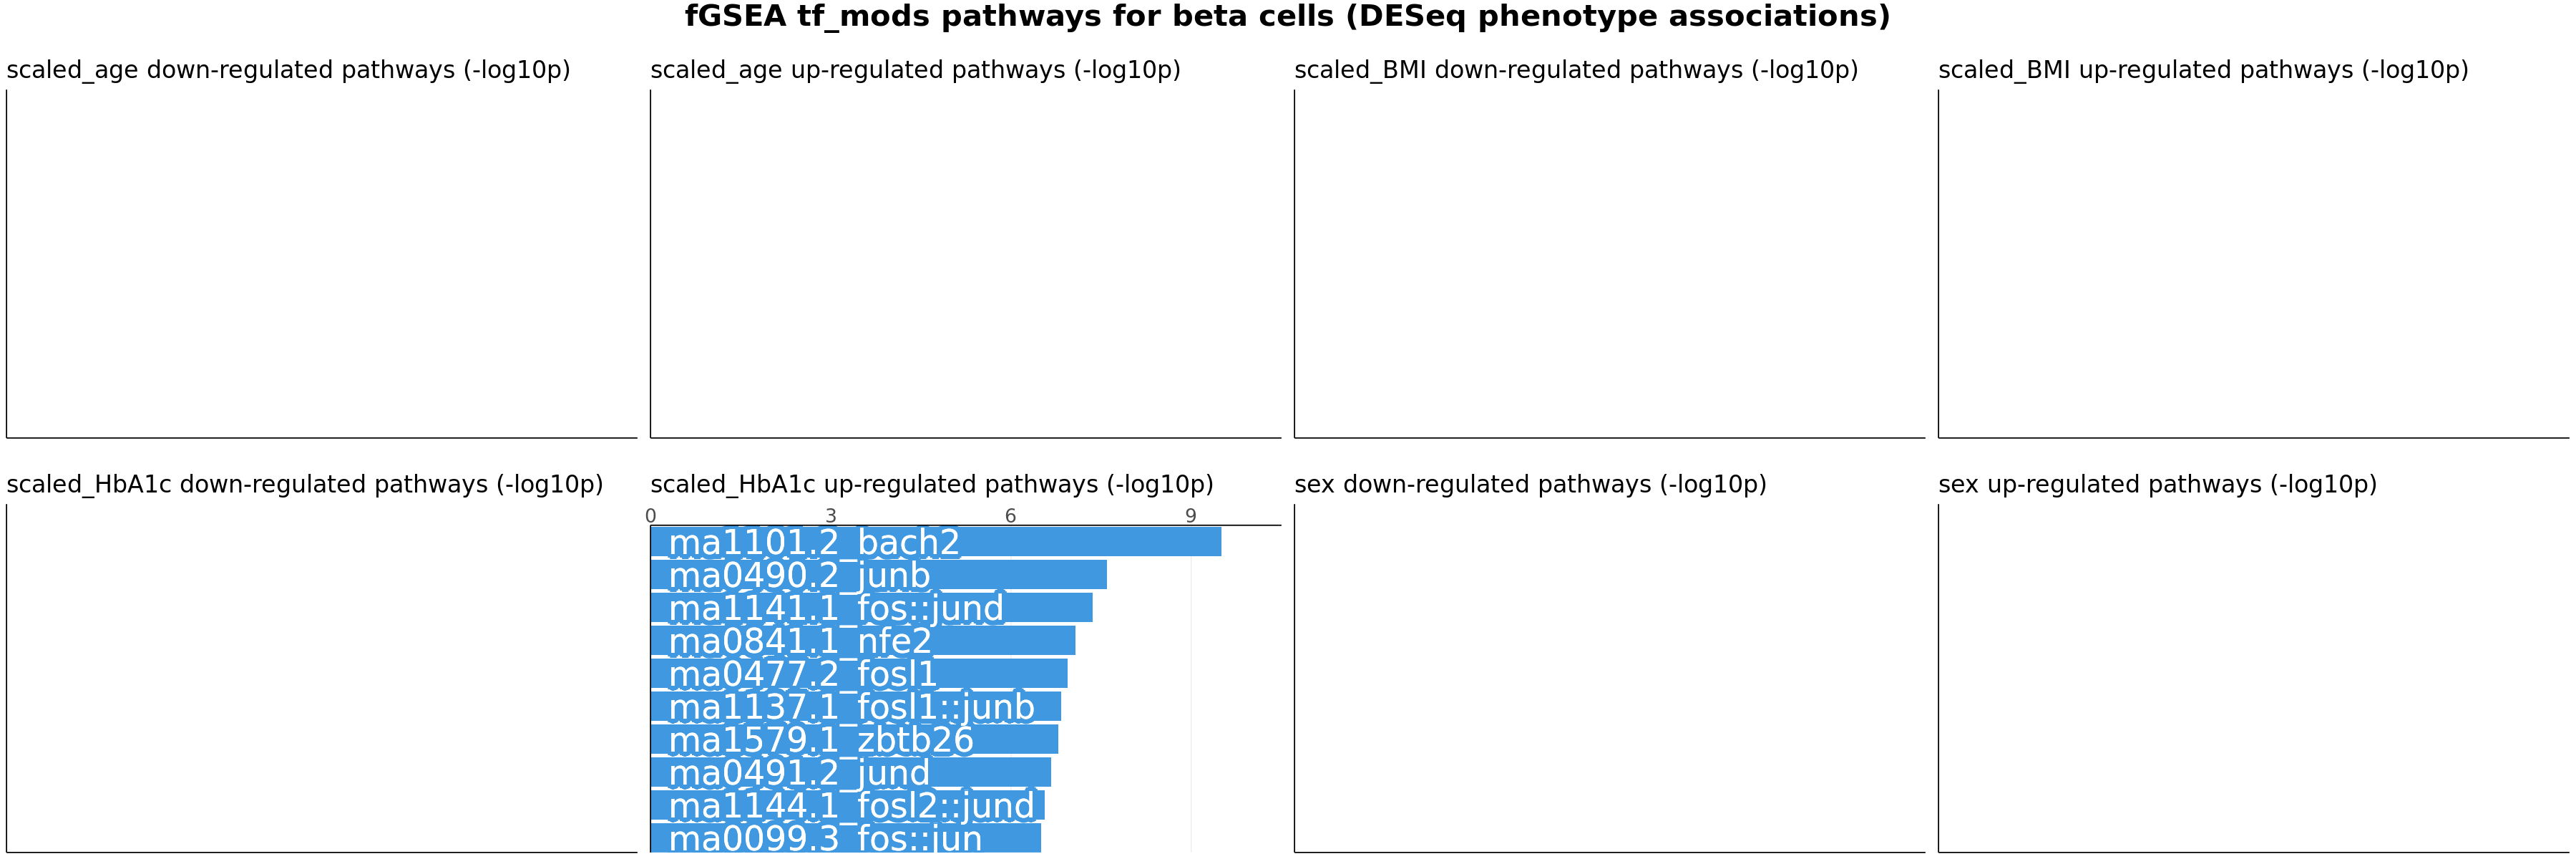

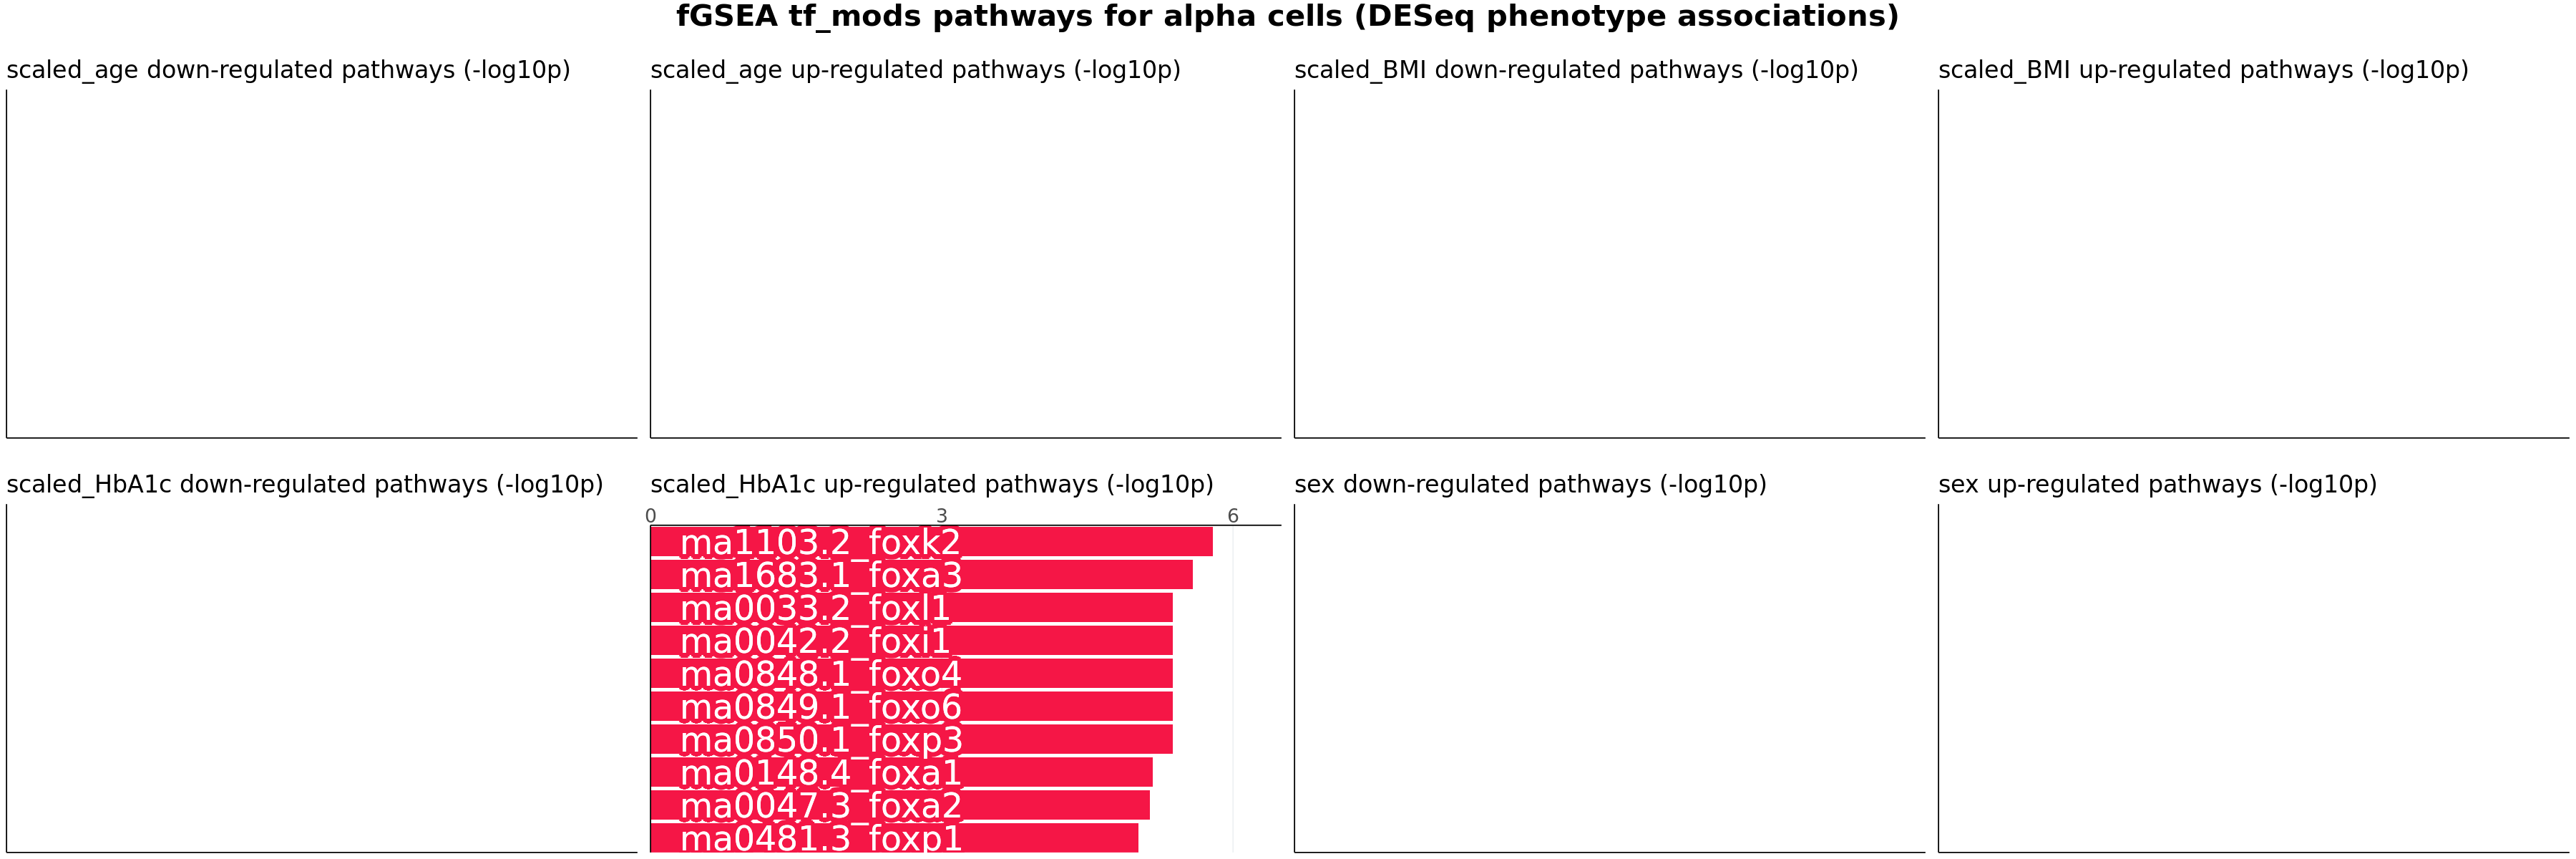

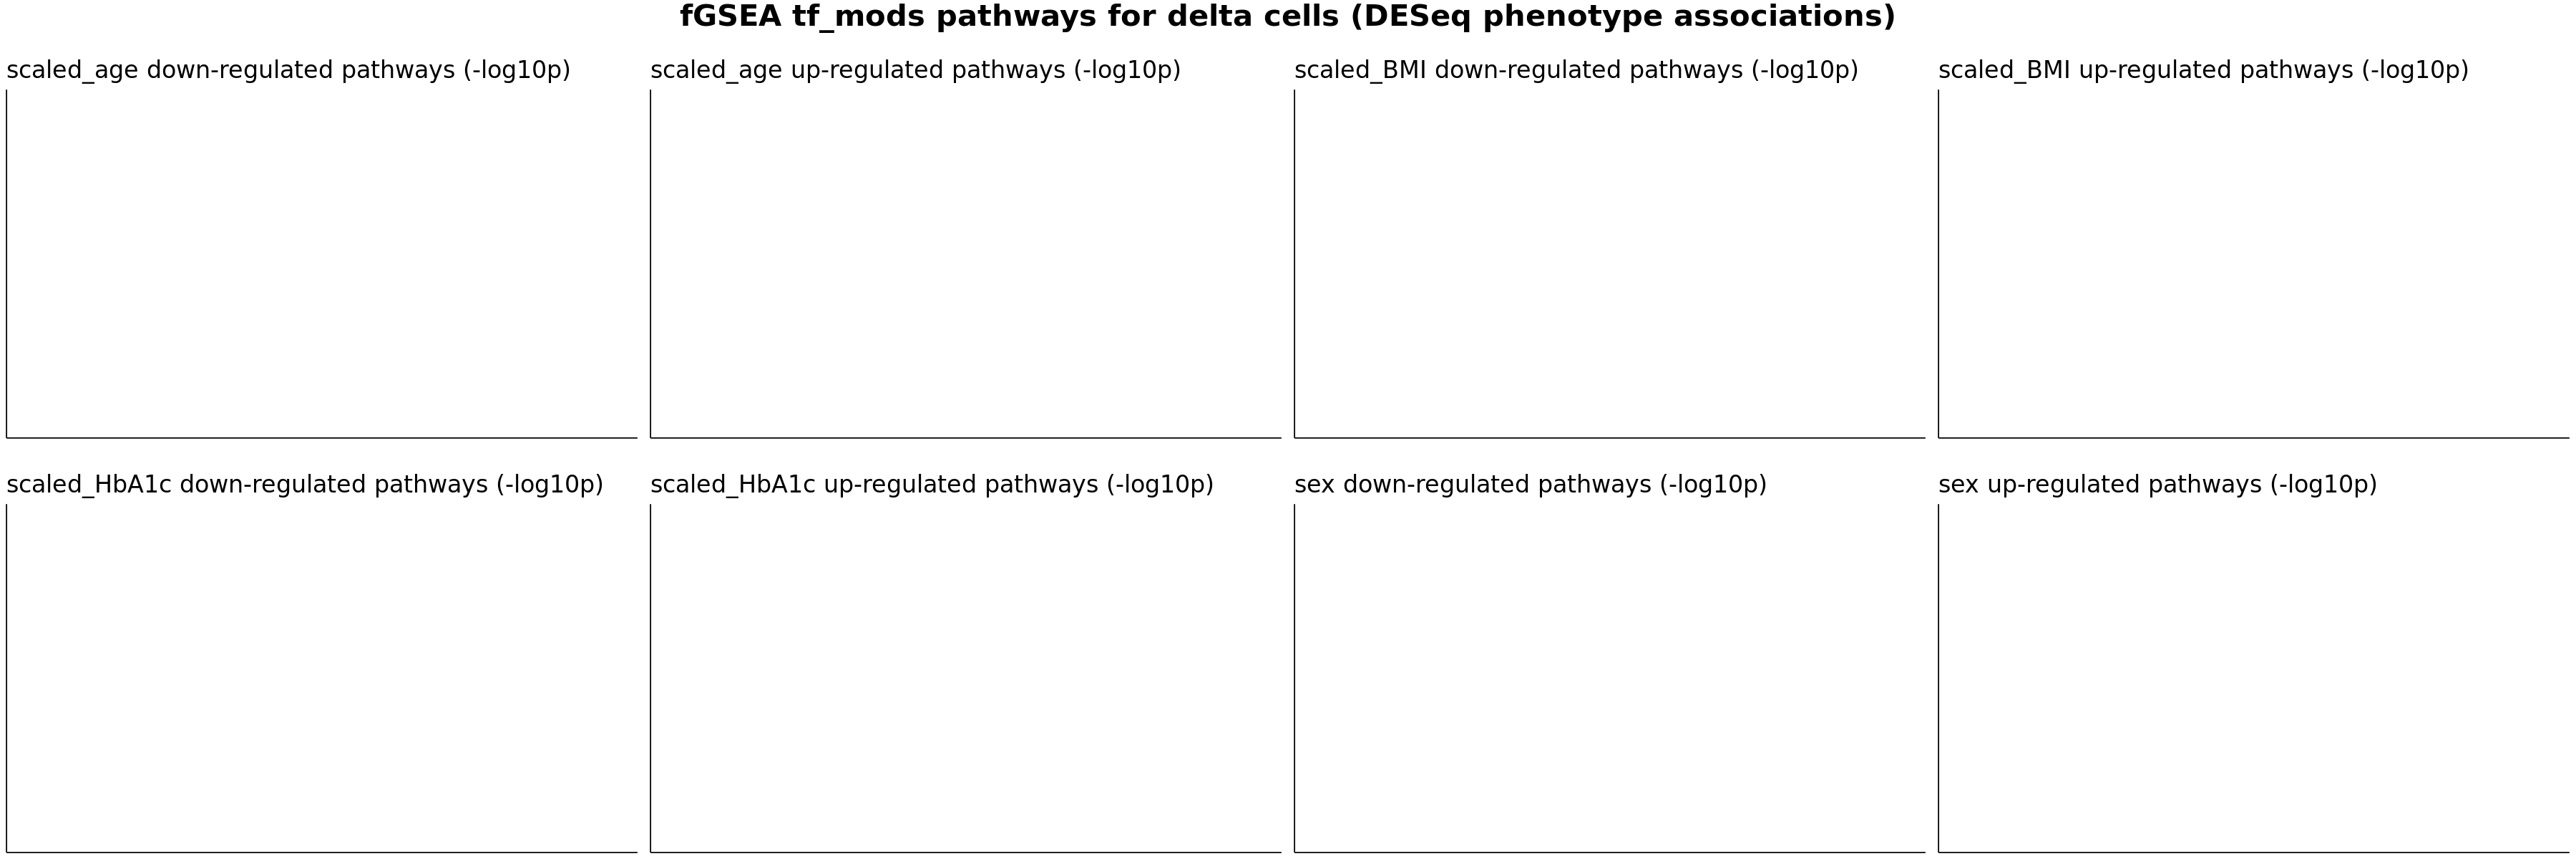

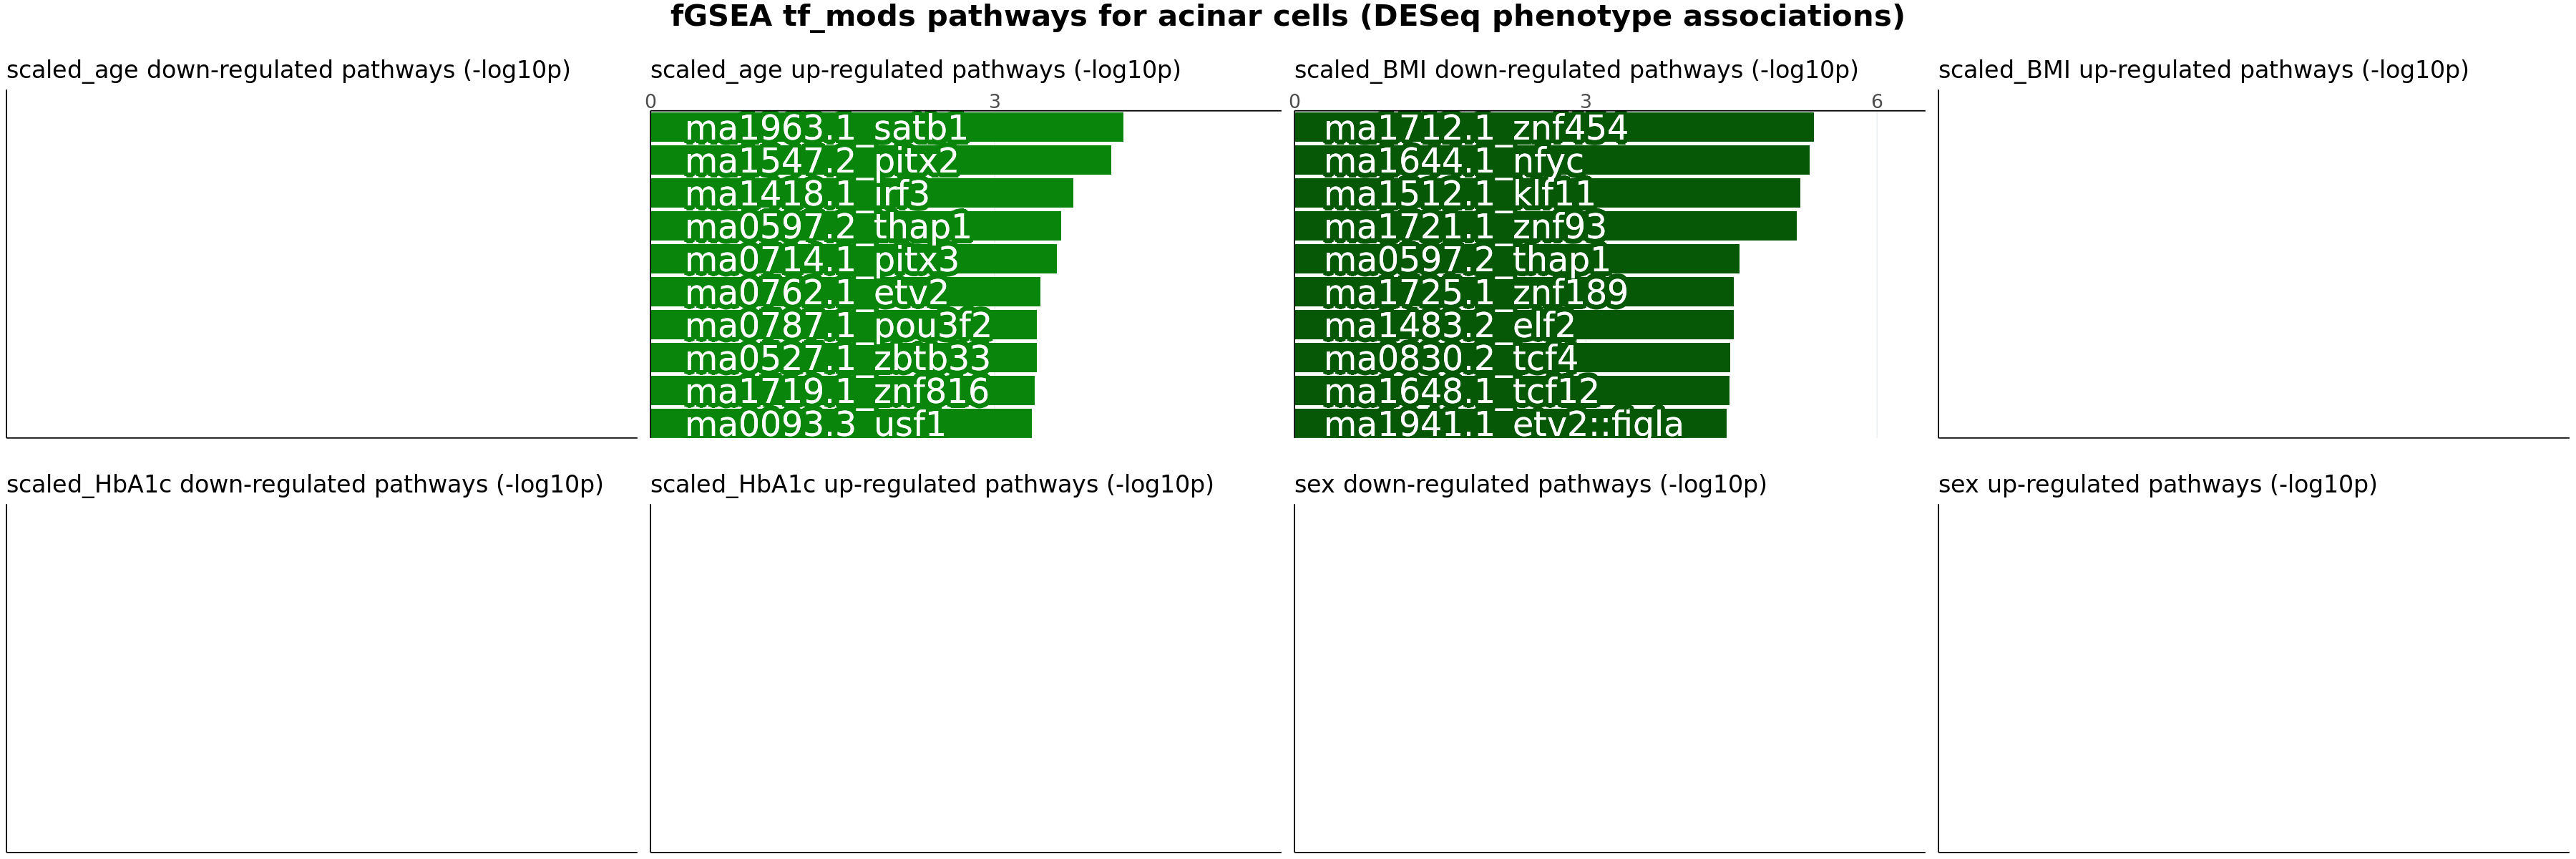

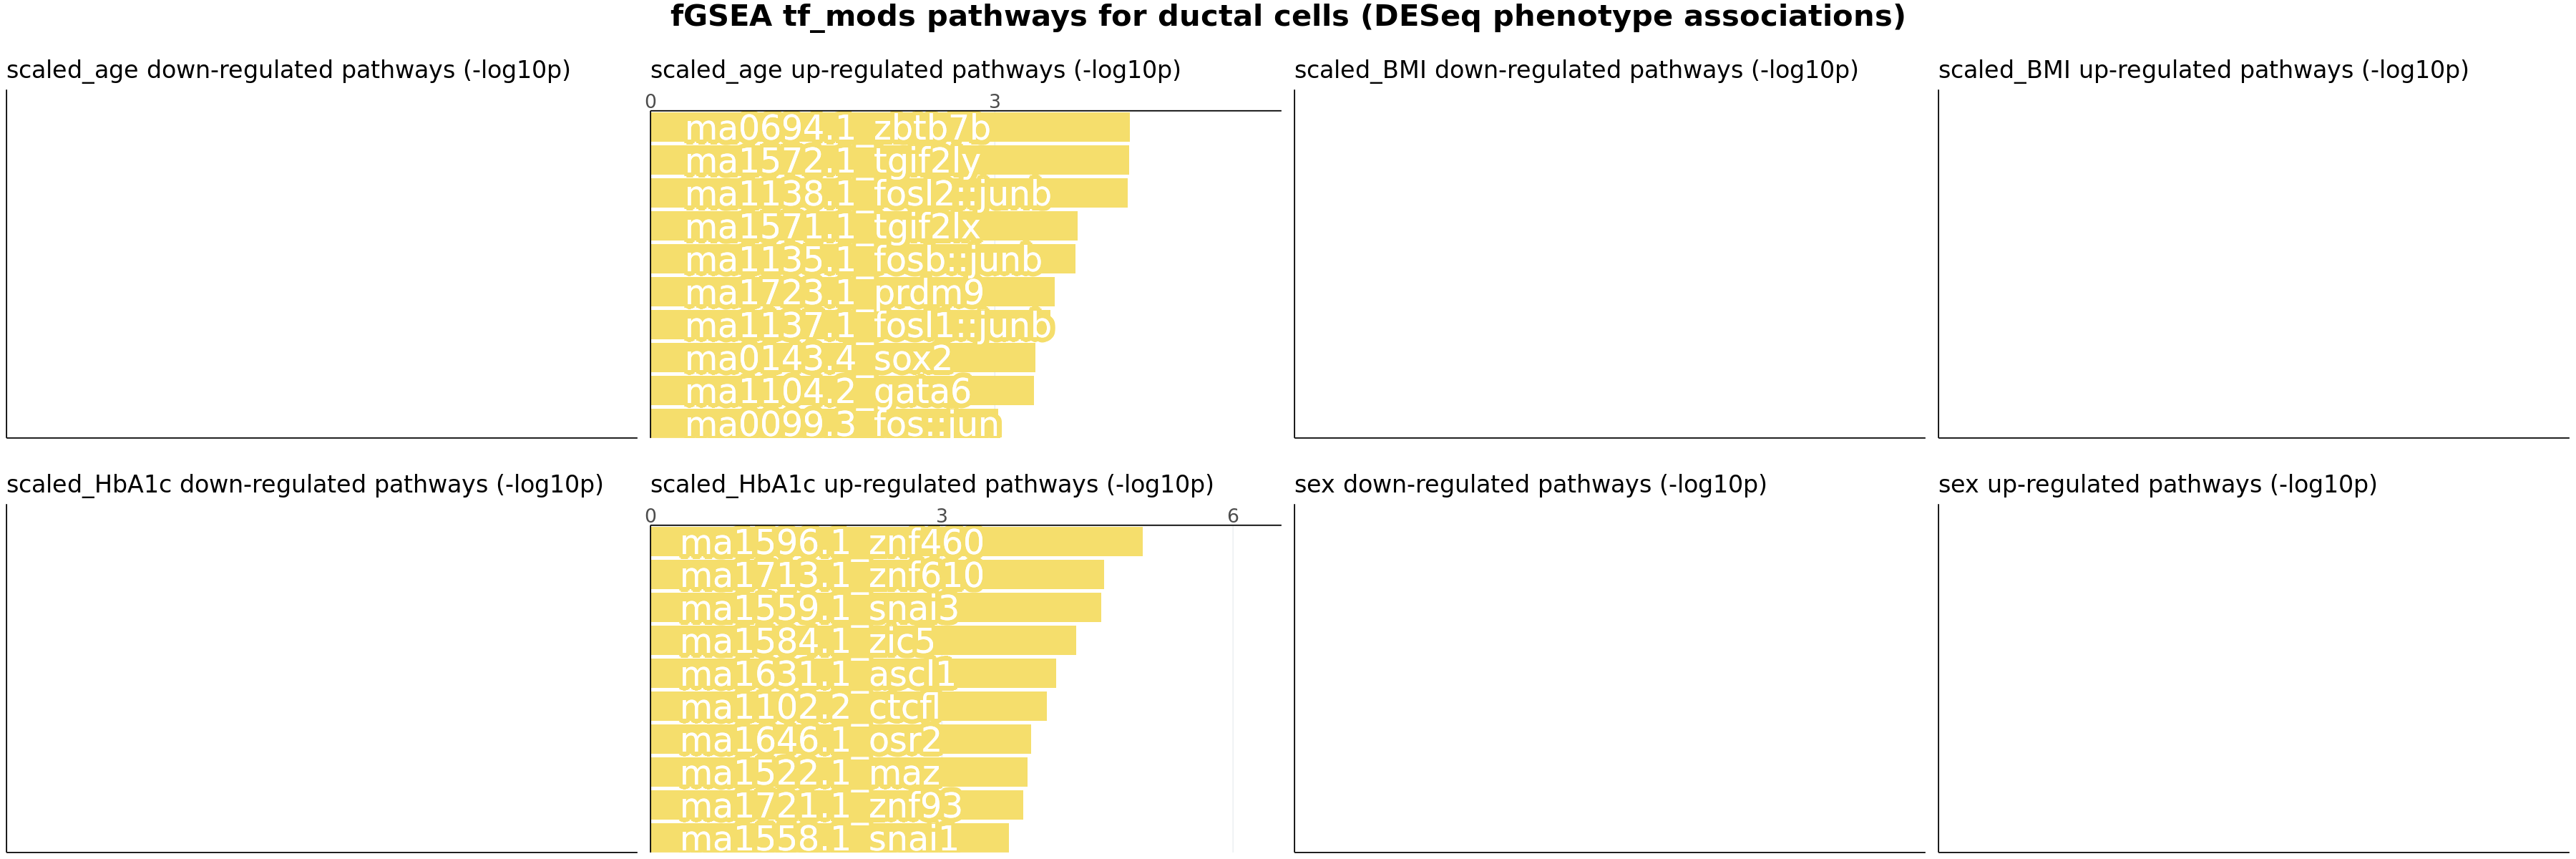

In [134]:
for (celltype in joint_celltypes[-4]){
    make_ct_pathway_plots(celltype, traits, fgsea_outdir, 'tf_mods', 0.1, colors)
}

## Quick exploration of sig results

### Beta cells and HbA1c
ChromVAR results: ZNF143 up and GATA6,NEUROD1 down.

HOMER results:
For HbA1c levels, cREs with increased activity in higher HbA1c were strongly enriched for NFkB motifs across all cell types, which is in line with the increased activity of inflammatory pathways, as well as for ELF, ETS, JUN/FOS and ATF motifs.  Beta cells also showed stronger enrichment for STAT-family motifs in higher HbA1c relative to other cell types (Figure 2e).

In [119]:
#read in an fGSEA fp of interest just to see what the sig mods are
celltype <- 'beta'
trait <- 'scaled_HbA1c'
pathways_name <- 'tf_mods'

fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
df <- read.table(fp, sep='\t', header=TRUE) %>% arrange(NES)
subset(df, padj < 0.1) %>% arrange(NES)

pathway              pval         padj         log2err   ES        NES     
1   MA1102.2_CTCFL       0.048057921  0.06462628   0.3217759 0.3252014 1.085835
2   MA1966.1_TFAP4::ETV1 0.048038328  0.06462628   0.3217759 0.3351676 1.093582
3   MA1107.2_KLF9        0.055973793  0.07363811   0.3217759 0.3293783 1.095939
4   MA0073.1_RREB1       0.060843511  0.07865462   0.3217759 0.3362231 1.102710
5   MA1569.1_TFAP2E      0.071052762  0.09027084   0.2878051 0.3390492 1.106103
6   MA0811.1_TFAP2B      0.077363274  0.09772974   0.2878051 0.3402253 1.110196
7   MA0163.1_PLAG1       0.049514653  0.06631782   0.3217759 0.3374360 1.110351
8   MA1512.1_KLF11       0.032782225  0.04682172   0.3217759 0.3349485 1.115164
9   MA1716.1_ZNF76       0.079431478  0.09977551   0.2878051 0.3437544 1.116782
10  MA0814.2_TFAP2C      0.061362175  0.07901268   0.3217759 0.3390943 1.118152
11  MA0524.2_TFAP2C      0.057752328  0.07538318   0.3217759 0.3459614 1.121997
12  MA1929.1_CTCF        0.013843731  0.02355553   0.3807304 0.3397148 1.126959
13  MA0475.2_FLI1        0.067636558  0.08625924   0.2878051 0.3527999 1.134308
14  MA0645.1_ETV6        0.061086227  0.07880950   0.3217759 0.3485606 1.134542
15  MA1938.1_ERF::NHLH1  0.053712645  0.07136720   0.3217759 0.3487183 1.134997
16  MA1656.1_ZNF449      0.054090666  0.07168751   0.3217759 0.3489800 1.135480
17  MA1712.1_ZNF454      0.016097361  0.02670881   0.3524879 0.3424399 1.139680
18  MA1483.2_ELF2        0.059629008  0.07737850   0.3217759 0.3542380 1.143108
19  MA0810.1_TFAP2A      0.016843158  0.02767090   0.3524879 0.3512769 1.145899
20  MA0502.2_NFYB        0.039867225  0.05516896   0.3217759 0.3518944 1.146002
21  MA0499.2_MYOD1       0.046729659  0.06348000   0.3217759 0.3514322 1.147844
22  MA1976.1_ZNF320      0.009285879  0.01728573   0.3807304 0.3450549 1.152125
23  MA1967.1_TFAP4::FLI1 0.045289902  0.06202950   0.3217759 0.3534137 1.155350
24  MA1517.1_KLF6        0.012581697  0.02168473   0.3807304 0.3490376 1.158805
25  MA0139.1_CTCF        0.006570747  0.01316123   0.4070179 0.3491649 1.159248
26  MA1635.1_BHLHE22     0.017836017  0.02864868   0.3524879 0.3548513 1.159480
27  MA0753.2_ZNF740      0.014770730  0.02487898   0.3807304 0.3513712 1.163333
28  MA1116.1_RBPJ        0.023463157  0.03597684   0.3524879 0.3577803 1.164114
29  MA1644.1_NFYC        0.050538397  0.06755333   0.3217759 0.3606345 1.165977
30  MA1641.1_MYF5        0.023782473  0.03621669   0.3524879 0.3628556 1.166091
⋮   ⋮                    ⋮            ⋮            ⋮         ⋮         ⋮       
502 MA0716.1_PRRX1       3.393297e-04 1.901957e-03 0.4984931 0.5215466 1.579222
503 MA0721.1_UNCX        3.393297e-04 1.901957e-03 0.4984931 0.5215466 1.579222
504 MA1519.1_LHX5        5.053129e-04 2.460173e-03 0.4772708 0.5270336 1.584154
505 MA0479.1_FOXH1       7.124568e-05 7.851022e-04 0.5384341 0.5148307 1.585828
506 MA1496.1_HOXA4       1.146224e-04 1.029493e-03 0.5384341 0.5236139 1.586386
507 MA0809.2_TEAD4       3.662076e-05 5.428010e-04 0.5573322 0.5088737 1.586943
508 MA0482.2_GATA4       5.791462e-04 2.717746e-03 0.4772708 0.5321447 1.587950
509 MA0673.1_NKX2-8      2.268105e-05 3.689820e-04 0.5756103 0.5095685 1.590162
510 MA0714.1_PITX3       6.071059e-04 2.792687e-03 0.4772708 0.5349891 1.590968
511 MA0724.1_VENTX       1.070890e-03 3.990413e-03 0.4550599 0.5816146 1.600259
512 MA0675.1_NKX6-2      2.155139e-04 1.455199e-03 0.5188481 0.5311370 1.604974
513 MA0674.1_NKX6-1      1.175455e-05 2.305966e-04 0.5933255 0.5139908 1.609456
514 MA0635.1_BARHL2      1.586258e-03 5.062363e-03 0.4550599 0.6136186 1.618276
515 MA1576.1_THRB        4.368617e-07 2.241437e-05 0.6749629 0.5060516 1.619022
516 MA1500.1_HOXB6       4.677372e-05 6.499598e-04 0.5573322 0.5255423 1.619828
517 MA1101.2_BACH2       3.151730e-10 2.102204e-07 0.8140358 0.5009473 1.634455
518 MA1557.1_SMAD5       7.862027e-04 3.229273e-03 0.4772708 0.6076315 1.640419
519 MA0829.2_SREBF1      1.293909e-06 4.315187e-05 0.6435518 0.5160430 1.642029
520 

In [120]:
subset(df, grepl('NFKB',pathway) & padj < 0.1)

pathway        pval       padj       log2err   ES       NES      size
183 MA0105.4_NFKB1 0.03971785 0.05507653 0.3217759 0.380469 1.210499 433 
    leadingEdge                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
183 EFNA1 AL512662.2 KCND3 PITRM1 SPAG17 AKR7A2 ARHGAP20 TRUB1 ITGA10 LINC01435 PACC1 DEPP1 FRMD4A ELK4 AC016042.1 DPM3 AMPD3 DNAJC12 SPSB1 PLPPR4 SPATA6 STX12 RGS7 CELF2 MGST3 CSGALNACT2 CAPN2 TIMM17A C1orf162 VAV3 DUSP5 ADGRA1 COG2 AL162431.1 PALMD AL157786.1 ADK DHX32 YY1AP1 CFAP43 NVL MTOR SPRTN NRBF2 CDC123 PINK1-AS MICU1 GSTO1 PRKCQ GNG4 TACC2 ACTN2 BTBD16 R3HCC1L MARK1 ZNF365 SDE2 RDX CORT FAM229A NRP1 WNT4 SLK GCLM TIMM23B-AGAP6 EXPH5 TP53BP2 TMEM51 TASOR2 VCL ESRRG PLCH2 COPA OBSCN XPR1 NT5C2 KIF1B UCHL5 TMEM234 USP6NL AL359762.1 TMCO1 PRPF18 SLC45A1 ALG9 MAP3K8 PRKAA2 CABCOCO1 STK40 SHTN1 GPATCH2 GBF1 TM9SF3 ABLIM1 DNM3-IT1 PHC2 DR1 ARHGEF10L NCOA4 RSBN1 XPNPEP1 UBR4 FAM204A

In [121]:
subset(df, grepl('ELF|ETS|JUN|FOS|ATF',pathway) & padj < 0.1)

pathway              pval         padj         log2err   ES        NES     
129 MA1483.2_ELF2        5.962901e-02 7.737850e-02 0.3217759 0.3542380 1.143108
157 MA1484.1_ETS2        3.057146e-02 4.413672e-02 0.3524879 0.3648155 1.175526
164 MA0641.1_ELF4        2.695138e-02 4.003690e-02 0.3524879 0.3633973 1.184747
217 MA0473.3_ELF1        1.624297e-03 5.134625e-03 0.4550599 0.3799544 1.240316
219 MA0492.1_JUND        1.391209e-02 2.361162e-02 0.3807304 0.3868135 1.240713
235 MA1953.1_FOXO1::ELF1 9.303711e-03 1.728573e-02 0.3807304 0.3884341 1.250501
248 MA0640.2_ELF3        2.312090e-03 6.372100e-03 0.4317077 0.3835245 1.257806
306 MA0834.1_ATF7        1.519728e-02 2.540497e-02 0.3807304 0.4106834 1.296887
326 MA1634.1_BATF        5.875342e-05 7.023825e-04 0.5573322 0.3976368 1.314879
337 MA0462.2_BATF::JUN   9.249903e-05 8.941573e-04 0.5384341 0.3982252 1.321667
352 MA0835.2_BATF3       5.956168e-05 7.023825e-04 0.5573322 0.4009765 1.331532
365 MA1127.1_FOSB::JUN   4.474890e-03 1.011780e-02 0.4070179 0.4199742 1.337559
379 MA1952.1_FOXJ2::ELF1 6.786039e-04 3.008177e-03 0.4772708 0.4177189 1.343033
383 MA1951.1_FOS         5.747646e-03 1.192286e-02 0.4070179 0.4220001 1.345485
404 MA0476.1_FOS         1.287688e-05 2.385799e-04 0.5933255 0.4122406 1.366261
407 MA1129.1_FOSL1::JUN  5.481578e-03 1.157029e-02 0.4070179 0.4366054 1.369298
416 MA1466.1_ATF6        3.685814e-03 8.748889e-03 0.4317077 0.4402232 1.373763
436 MA0488.1_JUN         2.893409e-04 1.752924e-03 0.4984931 0.4311702 1.386070
451 MA0478.1_FOSL2       3.554578e-06 9.483613e-05 0.6272567 0.4224016 1.398814
455 MA0605.2_ATF3        4.105617e-04 2.156257e-03 0.4984931 0.4398207 1.403013
459 MA1142.1_FOSL1::JUND 3.945343e-06 1.012132e-04 0.6105269 0.4285957 1.407617
465 MA1134.1_FOS::JUNB   4.461364e-06 1.086195e-04 0.6105269 0.4317635 1.415757
469 MA1632.1_ATF2        1.004457e-04 9.436239e-04 0.5384341 0.4382640 1.418692
472 MA1128.1_FOSL1::JUN  3.030058e-06 8.710059e-05 0.6272567 0.4283146 1.418921
489 MA1136.1_FOSB::JUNB  1.213029e-03 4.222047e-03 0.4550599 0.4525134 1.428981
511 MA1139.1_FOSL2::JUNB 3.827166e-04 2.058645e-03 0.4984931 0.4567346 1.443727
514 MA1135.1_FOSB::JUNB  9.056595e-07 3.475173e-05 0.6594444 0.4407540 1.444127
515 MA1126.1_FOS::JUN    4.598772e-04 2.323773e-03 0.4984931 0.4546522 1.444250
520 MA1130.1_FOSL2::JUN  4.095593e-07 2.241437e-05 0.6749629 0.4345998 1.446325
524 MA0477.2_FOSL1       1.136454e-07 1.516030e-05 0.7049757 0.4364368 1.448692
527 MA1132.1_JUN::JUNB   6.195732e-07 2.951824e-05 0.6594444 0.4420712 1.450489
531 MA0099.3_FOS::JUN    3.191754e-07 2.128900e-05 0.6749629 0.4387494 1.452770
535 MA1138.1_FOSL2::JUNB 3.566148e-07 2.162382e-05 0.6749629 0.4437516 1.454600
539 MA1144.1_FOSL2::JUND 2.784216e-07 2.063413e-05 0.6749629 0.4434221 1.457154
540 MA1143.1_FOSL1::JUND 7.951171e-04 3.229273e-03 0.4772708 0.4620321 1.458251
550 MA1133.1_JUN::JUNB   2.917159e-04 1.752924e-03 0.4984931 0.4598152 1.466053
551 MA1141.1_FOS::JUND   4.367465e-08 9.710331e-06 0.7195128 0.4413191 1.466587
556 MA1131.1_FOSL2::JUN  8.358800e-05 8.577415e-04 0.5384341 0.4600421 1.468116
560 MA1137.1_FOSL1::JUNB 1.460992e-07 1.564432e-05 0.6901325 0.4482071 1.475563
575 MA0491.2_JUND        2.176829e-07 1.814931e-05 0.6901325 0.4536721 1.490941
579 MA0833.2_ATF4        4.010096e-04 2.122805e-03 0.4984931 0.4778270 1.493439
583 MA1140.2_JUNB        3.235317e-04 1.860307e-03 0.4984931 0.4745015 1.498417
586 MA1145.1_FOSL2::JUND 3.958612e-05 5.739988e-04 0.5573322 0.4683269 1.500281
600 MA0490.2_JUNB        2.504752e-08 8.353348e-06 0.7337620 0.4628924 1.518628
    size
129  618
157  576
164  655
217  850
219  566
235  581
248  801
306  402
326 1059
337 1066
352 1044
365  463
379  573
383  440
404 1033
407  376
416  358
436  600
451 1037
455  478
459  968
465  964
469  640
472 1042
489  402
511  401
514  956
515  455
520 1023
524 1024
527  920
531 1013
535  945
539  979
540  399
550  440
551 1056
556  525
560  982
575  933
579  373
583  402
586  509
600  934

In [126]:
subset(df, grepl('ZNF143|GATA6|NEUROD1',pathway))

pathway          pval         padj        log2err   ES        NES      size
55  MA0088.2_ZNF143  0.3235719393 0.347540231 0.2035090 0.3286389 1.052452 498 
367 MA1109.1_NEUROD1 0.0007988458 0.003229273 0.4772708 0.4126450 1.338434 676 
581 MA1104.2_GATA6   0.0032088131 0.007811235 0.4317077 0.5044131 1.494832 222 
    leadingEdge                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
55  AL512662.2 IFI6 KCNAB2 KCND3 PITRM1 SPAG17 BATF3 NPHP4 ARHGAP20 TRUB1 CCDC18 CCDC6 ELK4 AC016042.1 DISC1 LINC02680 KIAA1217 AL360012.1 NRG3 LINC02645 SPSB1 PLPPR4 DESI2 STX12 RGS7 KIAA1614-AS1 CELF2 PSMA5 GTPBP4 AL049795.1 ABCC2 SRM MGST3 AURKAIP1 CAPN2 PITRM1-AS1 SEC23IP AL136982.3 C10orf88 DUSP5 ADGRA1 ADK DHX32 YY1AP1 DENND10 AMPD2 CFAP43 DYRK3 NVL PLPP3 MCM10 EPHA8 AL390860.1 EPRS GADD45A NRBF2 CDC123 PINK1-AS GSTO1 PRKCQ ADD3-AS1 GNG4 TACC2 ZNHIT6 DNTTIP2 R3HCC1L FAM53B MARK1 SDE2 RDX FMN2 ECHS1 SLK GCLM EXPH5 MYSM1 TP53BP2 AL359918.2 MPZL1 TASOR2 VCL LIPA BLZF1 ESRRG PLCH2 DYNC2H1 COPA AL096803.2 XPR1 NT5C2 SERINC2 KIF1B UCHL5 TIAL1 SMAP2 TMEM269 USP6NL TMCO1 ARHGAP29 PRPF18 SLC45A1 MAP3K8 PRKAA2 CABCOCO1 SSR2 TAGLN2 MIGA1 CLCC1 GPATCH2 GBF1 TM9SF3 ABLIM1 PHC2 ARHGEF10L XPNPEP1 STAMBPL1 UBR4 FAM204A                                                                                                                                                                                                                                                                                            
367 IFI6 AL713851.1 KCNAB2 KCND3 PITRM1 KIAA0040 NPHP4 AKR7A2 ARHGAP20 TRUB1 PLXDC2 SPATA42 MALRD1 PHLDA3 AL139243.1 CCDC18 CCDC6 FRMD4A IDE ENKUR DCUN1D5 STAM ELK4 AC016042.1 AL358612.1 KIAA1217 NRG3 AKR7A3 AMPD3 LINC02645 DNAJC12 AKNAD1 C1orf116 TNFRSF9 SPSB1 PLPPR4 RASGEF1A BCAR3 SPATA6 ARHGAP12 DESI2 CISD1 STX12 MRPL55 RGS7 CELF2 PSMA5 GTPBP4 SRM MGST3 C1orf198 CSGALNACT2 CAPN2 TIMM23 SEC23IP HECTD3 KIFAP3 VAV3 ADGRA1 COG2 AL365203.2 AL157786.1 ADK DHX32 YY1AP1 HAX1 PARD3-AS1 DENND10 DYRK3 NVL SLC30A1 EPHA8 NRBF2 KIN ERI3 PINK1-AS LYPLA2 TMEM9 GSTO1 CDHR1 NBL1 LSM10 NFKB2 ECHDC3 TACC2 ACTN2 BTBD16 TBC1D12 GALNT2 R3HCC1L PIP5K1A ARL5B CNKSR1 MARK1 ZSWIM8-AS1 ZNF365 AL355488.1 SDE2 ARMC3 RDX FAM229A NRP1 LINC02803 WNT4 DNAJC11 FMN2 SLK GCLM EXPH5 AL392086.3 TP53BP2 TMEM51 MPZL1 ZFAND4 ATP5MD TASOR2 VCL POLR3A C1orf220 PLCH2 DYNC2H1 OBSCN CFAP46 XPR1 NT5C2 SERINC2 KIF1B PLET1 UCHL5 TMEM234 TIAL1 NASP USP6NL TMCO1 ARHGAP29 PRPF18 SLC45A1 MAP3K8 CABCOCO1 SSR2 TAF1A TAGLN2 SHTN1 TFAM CLCC1 AL731563.3 GBF1 TM9SF3 ABLIM1 PHC2 DR1 ARHGEF10L NCOA4 RSBN1 XPNPEP1 STAMBPL1 AL139407.1 UBR4 FAM204A
581 KCND3 PITRM1 DCUN1D5 STAM MPP7-DT SPSB1 SPATA6 CELF2 MGST3 C1orf198 CSGALNACT2 CAPN2 TIMM17A VAV3 DHX32 YY1AP1 CFAP43 NVL SLC30A1 CHUK MTOR EPRS AL121929.3 GSTO1 PRKCQ TACC2 DNTTIP2 GALNT2 FAM53B STN1 NRP1 LINC02803 FBH1 SLK GCLM TP53BP2 TMEM51 POLR3A BLZF1 ESRRG PLCH2 XPR1 NT5C2 KIF1B USP6NL TMCO1 MAP3K8 SSR2 STK40 MIGA1 GBF1 XPNPEP1 STAMBPL1 FAM204A FLVCR1 ALOX

### Acinar cells and age
ChromVAR results: ZSCAN4 and EMX2 up, ONECUT3 down

HOMER results: no clue :)

In [135]:
#read in an fGSEA fp of interest just to see what the sig mods are
celltype <- 'acinar'
trait <- 'scaled_age'
pathways_name <- 'tf_mods'

fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
df <- read.table(fp, sep='\t', header=TRUE) %>% arrange(NES)
subset(df, padj < 0.1) %>% arrange(NES)

pathway              pval         padj       log2err   ES        NES     
1   MA1710.1_ZNF257      0.037500000  0.08912852 0.2377938 0.4446331 1.219448
2   MA1132.1_JUN::JUNB   0.038947368  0.08972517 0.2343926 0.4492241 1.224638
3   MA1107.2_KLF9        0.017642775  0.05364357 0.3524879 0.4436274 1.226487
4   MA0741.1_KLF16       0.007511540  0.03648444 0.4070179 0.4460651 1.235878
5   MA1721.1_ZNF93       0.013858191  0.04585431 0.3807304 0.4497490 1.242275
6   MA1712.1_ZNF454      0.008625383  0.03987762 0.3807304 0.4510656 1.246478
7   MA1726.1_ZNF331      0.040772532  0.09297790 0.2311267 0.4618332 1.246659
8   MA0750.2_ZBTB7A      0.029535865  0.07865546 0.2712886 0.4576075 1.247701
9   MA1731.1_ZNF768      0.038709677  0.08972517 0.2377938 0.4627191 1.248402
10  MA1631.1_ASCL1       0.029598309  0.07865546 0.2712886 0.4584216 1.248711
11  MA0154.4_EBF1        0.037878788  0.08971292 0.2413400 0.4639813 1.248766
12  MA1516.1_KLF3        0.014883595  0.04876906 0.3807304 0.4531668 1.248876
13  MA0501.1_MAF::NFE2   0.028846154  0.07757432 0.2765006 0.4636350 1.252988
14  MA0473.3_ELF1        0.029504742  0.07865546 0.2712886 0.4604758 1.254990
15  MA1987.1_ZNF701      0.011753767  0.04338425 0.3807304 0.4562115 1.255315
16  MA0144.2_STAT3       0.038503850  0.08972517 0.2413400 0.4697953 1.256156
17  MA1100.2_ASCL1       0.042299349  0.09581228 0.2279872 0.4682266 1.258727
18  MA0753.2_ZNF740      0.011009753  0.04320688 0.3807304 0.4592751 1.260476
19  MA1941.1_ETV2::FIGLA 0.033842795  0.08367724 0.2572065 0.4715113 1.263274
20  MA1508.1_IKZF1       0.031000811  0.08110677 0.3524879 0.4676755 1.263607
21  MA1522.1_MAZ         0.006804929  0.03604489 0.4070179 0.4580066 1.265638
22  MA1708.1_ETV7        0.032894737  0.08285055 0.2616635 0.4729883 1.266706
23  MA0841.1_NFE2        0.013951782  0.04593880 0.3807304 0.4656025 1.267211
24  MA1102.2_CTCFL       0.005588419  0.03429257 0.4070179 0.4588201 1.268088
25  MA0149.1_EWSR1-FLI1  0.013820711  0.04585431 0.3807304 0.4627422 1.269736
26  MA0746.2_SP3         0.002798300  0.02761074 0.4317077 0.4586602 1.270774
27  MA0103.3_ZEB1        0.012848264  0.04424785 0.3807304 0.4667600 1.273338
28  MA0747.1_SP8         0.004143820  0.02883586 0.4070179 0.4608919 1.274179
29  MA0761.2_ETV1        0.013177440  0.04492309 0.3807304 0.4690319 1.275234
30  MA1982.1_ZNF574      0.030401737  0.07984892 0.2712886 0.4748661 1.275879
⋮   ⋮                    ⋮            ⋮          ⋮         ⋮         ⋮       
280 MA0701.2_LHX9        6.125828e-03 0.03486500 0.4070179 0.6744747 1.528310
281 MA0717.1_RAX2        6.125828e-03 0.03486500 0.4070179 0.6744747 1.528310
282 MA0831.3_TFE3        9.123786e-04 0.02250109 0.4772708 0.6032424 1.530294
283 MA0861.1_TP73        2.027404e-03 0.02636034 0.4317077 0.6387969 1.530905
284 MA1532.2_NR1D2       1.048882e-03 0.02250109 0.4550599 0.6077717 1.536356
285 MA1639.1_MEIS1       1.066718e-03 0.02250109 0.4550599 0.6339438 1.544151
286 MA0790.1_POU4F1      8.444245e-04 0.02250109 0.4772708 0.6264808 1.545102
287 MA0787.1_POU3F2      4.271163e-04 0.02250109 0.4984931 0.6151031 1.546932
288 MA0679.2_ONECUT1     9.677353e-04 0.02250109 0.4772708 0.6179235 1.547348
289 MA1561.1_SOX12       3.864319e-03 0.02881745 0.4317077 0.6900279 1.547948
290 MA1552.1_RARB        1.854176e-03 0.02636034 0.4550599 0.6341046 1.548172
291 MA0712.2_OTX2        1.663352e-03 0.02636034 0.4550599 0.6417586 1.550054
292 MA1113.2_PBX2        1.124378e-03 0.02295415 0.4550599 0.6367657 1.554808
293 MA1568.1_TCF21       4.005847e-03 0.02881745 0.4070179 0.6798773 1.555896
294 MA0074.1_RXRA::VDR   2.673421e-03 0.02761074 0.4317077 0.6589641 1.560666
295 MA0770.1_HSF2        1.206001e-03 0.02295415 0.4550599 0.6531926 1.560846
296 MA1418.1_IRF3        2.052382e-04 0.02250109 0.5188481 0.6021132 1.562736
297 MA0618.1_LBX1        3.410480e-03 0.02817453 0.4317077 0.6819922 1.563158
298 MA0527.1_ZBTB33      4.279848e-04 0.02250109 0.4984931 0.6192488 1.564593
299 MA0758.1_E2F7        1

In [130]:
subset(df, grepl('ZSCAN4|EMX2|ONECUT3',pathway))

pathway          pval      padj       log2err   ES        NES      size
175 MA1155.1_ZSCAN4  0.1382488 0.19352769 0.1238422 0.4502909 1.176985 242 
202 MA0886.1_EMX2    0.2236842 0.26582191 0.1075544 0.5601874 1.196359  41 
545 MA0757.1_ONECUT3 0.0126548 0.04424785 0.3807304 0.5736129 1.395946 121 
    leadingEdge                                                                                                                                                                                                                                                                                                                                                                                          
175 GDF10 PFKFB2 PLK3 WNT9A ADIRF-AS1 EPHA2 AL513303.1 PROSER2 RAP1GAP AL031283.1 TENT5C JMJD1C PPP2R5A CD55 ARID5B IL22RA1 SLC9A1 GALNT2 GADD45A TENT5B MTHFR ARHGEF10L STAM ACSM6 AKR1C1 EIF2D BNIP3 NET1 PTGFRN DNTTIP2 CELA3A KCNK1 PITRM1 AL162274.1 ZNF697 SLC19A2 SDC3 GPR161 AL139424.3 SORBS1 ABLIM1 PPP1R12B PPP2R2D RASSF5 KLHL21 TNKS2 SUCO ERLIN1 CPEB3 LMNA PRKCZ PCGF5 LCK HIST2H2BE MACO1
202 PFKFB2 WNT9A PROSER2 CD55 AC010997.4 BNIP3 CSRP1 RHOU XPNPEP1 PDZD8 MINDY1 PPP2R2D RASSF5 CCDC172 PSD RLF PLPP3 YOD1                                                                                                                                                                                                                                                                                 
545 GDF10 PALD1 AL513303.1 SPSB1 SYTL1 PPP2R5A MAP3K21 DLG5 IL22RA1 CAPN8 GADD45A ARHGEF10L STN1 DLGAP3 BNIP3 AL592295.4 KCNK1 CTH PDCD4 GSTO2 CUZD1 SLC22A15 SLK CASZ1 PPP2R2D ZNF644 IL12RB2 SSX2IP PHLDA3 F11R PCP4L1 PPA1 SFPQ ZRANB1 CNIH3 BCCIP DIP2C ECE1 MAD2L2 IL6R MAP3K8

In [136]:
subset(df, grepl('RFX',pathway))

pathway       pval       padj       log2err    ES        NES       size
30  MA1554.1_RFX7 0.54425363 0.56693087 0.05456806 0.4010424 0.9530279  96 
199 MA0799.2_RFX4 0.16125000 0.21565071 0.11881504 0.4882434 1.1920511 124 
363 MA0510.2_RFX5 0.04631829 0.10020784 0.22798720 0.5038304 1.2905433 203 
386 MA0509.3_RFX1 0.03510896 0.08604601 0.26635066 0.5141930 1.3035944 183 
414 MA0798.3_RFX3 0.03575685 0.08661888 0.26166352 0.5132392 1.3142414 204 
479 MA0600.2_RFX2 0.02152984 0.06055266 0.35248786 0.5312162 1.3514312 192 
    leadingEdge                                                                                                                                                                                                                                                                                                                                                                                   
30  PLK3 SPSB1 AC119673.2 TXNIP GALNT2 BTG2 SESN2 STN1 TTLL10 CELA3A KCNK1 PITRM1 LYST LINC01348 SDC3 RHCE ILDR2 TNKS2 TBC1D12 ZNF644 MAN1C1 KCTD3 DDI2 IL12RB2                                                                                                                                                                                                                                   
199 PLK3 EPHA2 AL513303.1 PROSER2 DIRAS3 PPP2R5A MAP3K21 DLG5 NBPF1 GADD45A DNAJC1 AKR1C1 IFI16 SESN2 NET1 C10orf95 PITRM1 LYST NBL1 GNG4 ZFP69 SDC3 SORBS1 USP6NL ABCD3 ZNF644 PRKCZ SYPL2 IL23R                                                                                                                                                                                                 
363 PLK3 UNC5B WNT9A EPHA2 RAP1GAP SPSB1 RYR2 IFFO2 PPP2R5A DLG5 ARID5B TXNIP AL731568.1 GALNT2 GADD45A MTHFR DNAJC1 VIM RHOBTB1 DTL AL451042.1 LINC00853 AC119427.1 FAM107B TTLL10 DNTTIP2 CELA3A CTH SHLD2 RHOU C1orf116 LYST NTNG1 TRAF5 AL358072.1 AL596214.1 CUZD1 ZFP69 SLK DPH5 AC022400.4 CASZ1 PPP2R2D ABCD3 IFNLR1 NAV1 SYPL2 PCGF5 MACO1 KCTD3 SH3PXD2A DDI2 RLF SSX2IP NOL9 PACC1 YOD1
386 PLK3 UNC5B WNT9A EPHA2 RAP1GAP SPSB1 IFFO2 PPP2R5A ARID5B TXNIP AL731568.1 SEMA4A BICC1 GALNT2 GADD45A VIM DTL CCDC181 AL451042.1 BNIP3 AC119427.1 FAM107B TTLL10 DNTTIP2 CELA3A KCNK1 CTH RHOU LYST NTNG1 AL162274.1 TRAF5 AL358072.1 AL596214.1 ZFP69 DPH5 AC022400.4 PPP2R2D MCU ABCD3 LMNA NAV1 SYPL2 PCGF5 MACO1 KCTD3 SH3PXD2A DDI2 RLF SSX2IP NOL9 PACC1 YOD1                          
414 PLK3 UNC5B WNT9A EPHA2 RAP1GAP SPSB1 RYR2 IFFO2 PPP2R5A ARID5B TXNIP AL731568.1 SEMA4A BICC1 GALNT2 GADD45A VIM DTL CCDC181 AL451042.1 BNIP3 AC119427.1 PIGC FAM107B TTLL10 CELA3A KCNK1 CTH RHOU LYST NTNG1 AL162274.1 TRAF5 PDZD8 AL358072.1 AL596214.1 CUZD1 ZFP69 SLK DPH5 AC022400.4 PPP2R2D MCU ABCD3 IFNLR1 LMNA NAV1 SYPL2 PCGF5 MACO1 KCTD3 SH3PXD2A DDI2 RLF SSX2IP NOL9 PACC1 YOD1 
479 PLK3 UNC5B WNT9A EPHA2 RAP1GAP SPSB1 RYR2 AL031283.1 IFFO2 PPP2R5A DLG5 ARID5B TXNIP AL731568.1 BICC1 GALNT2 GADD45A VIM DTL CXCL12 AL451042.1 AC119427.1 FAM107B CSRP1 TTLL10 DNTTIP2 CELA3A CTH RHOU LYST NTNG1 TRAF5 AL358072.1 AL596214.1 CUZD1 ZFP69 SLK DPH5 AC022400.4 PPP2R2D MCU ABCD3 IFNLR1 NAV1 SYPL2 PCGF5 MACO1 KCTD3 SH3PXD2A

### Acinar cells and BMI
ChromVAR results: INSM1 and GLIS3 and RELA up, maybe ATF6 down

HOMER results: no clue :)

In [127]:
#read in an fGSEA fp of interest just to see what the sig mods are
celltype <- 'acinar'
trait <- 'scaled_BMI'
pathways_name <- 'tf_mods'

fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
df <- read.table(fp, sep='\t', header=TRUE) %>% arrange(NES)
subset(df, padj < 0.1) %>% arrange(NES)

pathway               pval         padj        log2err   ES        
1   MA0669.1_NEUROG2      2.408616e-03 0.012229639 0.4317077 -0.8141038
2   MA0863.1_MTF1         5.001626e-04 0.006138359 0.4772708 -0.7385708
3   MA0068.2_PAX4         4.463072e-03 0.016193250 0.4070179 -0.8512086
4   MA0596.1_SREBF2       4.271777e-05 0.001941680 0.5573322 -0.7124947
5   MA0497.1_MEF2C        1.354753e-04 0.003265921 0.5188481 -0.7099159
6   MA0046.2_HNF1A        3.346609e-04 0.005134002 0.4984931 -0.7138065
7   MA0855.1_RXRB         1.037154e-04 0.002692612 0.5384341 -0.7063250
8   MA0623.2_NEUROG1      6.761954e-03 0.020285863 0.4070179 -0.8262819
9   MA1523.1_MSANTD3      3.768681e-04 0.005299708 0.4984931 -0.7062593
10  MA1537.1_NR2F1        6.260856e-05 0.002224251 0.5384341 -0.6967103
11  MA0856.1_RXRG         1.833835e-04 0.003696859 0.5188481 -0.6999567
12  MA0153.2_HNF1B        1.044674e-03 0.009090876 0.4550599 -0.7154141
13  MA1574.1_THRB         1.003576e-04 0.002692612 0.5384341 -0.6968423
14  MA0817.1_BHLHE23      4.239628e-03 0.016162683 0.4070179 -0.8163464
15  MA1963.1_SATB1        4.255434e-03 0.016162683 0.4070179 -0.7686781
16  MA0818.2_BHLHE22      3.847460e-03 0.015644792 0.4317077 -0.8210192
17  MA1550.1_PPARD        4.733093e-04 0.005939428 0.4984931 -0.6923178
18  MA1146.1_NR1H4::RXRA  6.523298e-03 0.019806070 0.4070179 -0.7503975
19  MA0798.3_RFX3         5.751007e-04 0.006709327 0.4772708 -0.6899551
20  MA1644.1_NFYC         4.937059e-06 0.001139672 0.6105269 -0.6729527
21  MA0160.2_NR4A2        1.581736e-03 0.010889888 0.4550599 -0.7031053
22  MA1421.1_TCF7L1       1.661787e-03 0.010889888 0.4550599 -0.6936598
23  MA1725.1_ZNF189       2.970616e-05 0.001941680 0.5756103 -0.6762503
24  MA0757.1_ONECUT3      9.890566e-04 0.008901509 0.4550599 -0.7179353
25  MA0052.4_MEF2A        5.765051e-04 0.006709327 0.4772708 -0.6853765
26  MA1975.1_ZNF214       3.119553e-03 0.014010159 0.4317077 -0.7331038
27  MA1504.1_HOXC4        1.098316e-02 0.025228702 0.3807304 -0.7273017
28  MA1547.2_PITX2        3.119553e-03 0.014010159 0.4317077 -0.7326690
29  MA0674.1_NKX6-1       8.319907e-03 0.022185934 0.3807304 -0.7221106
30  MA1962.1_POU2F1::SOX2 1.012677e-03 0.008994168 0.4550599 -0.7168345
⋮   ⋮                     ⋮            ⋮           ⋮         ⋮         
594 MA0834.1_ATF7         0.04528764   0.05252432  0.2343926 -0.5371173
595 MA1718.1_ZNF8         0.08888889   0.09646302  0.1813831 -0.6248827
596 MA1100.2_ASCL1        0.02616891   0.03758302  0.3524879 -0.5136220
597 MA1928.1_BNC2         0.01624953   0.02966661  0.3524879 -0.5008483
598 MA0719.1_RHOXF1       0.06406685   0.07101006  0.2089550 -0.5862399
599 MA0861.1_TP73         0.06241700   0.06940935  0.2065879 -0.5617949
600 MA0667.1_MYF6         0.05617978   0.06309709  0.2114002 -0.5422685
601 MA0665.1_MSC          0.04211793   0.04952892  0.2413400 -0.5245966
602 MA1102.2_CTCFL        0.01128674   0.02543664  0.3807304 -0.4930659
603 MA0500.2_MYOG         0.03030303   0.04074611  0.2765006 -0.5087560
604 MA1930.1_CTCF         0.02306903   0.03525618  0.3524879 -0.4957523
605 MA1566.2_TBX3         0.05757196   0.06444623  0.2089550 -0.5356416
606 MA0744.2_SCRT2        0.05231144   0.05954506  0.2165428 -0.5193397
607 MA0102.4_CEBPA        0.05395232   0.06103784  0.2165428 -0.5303320
608 MA1719.1_ZNF816       0.03333333   0.04326923  0.2616635 -0.5010167
609 MA1581.1_ZBTB6        0.03344482   0.04333062  0.2616635 -0.5014608
610 MA1129.1_FOSL1::JUN   0.05639098   0.06322909  0.2114002 -0.5270139
611 MA1562.1_SOX14        0.08882907   0.09646302  0.1723243 -0.5540559
612 MA0891.1_GSC2         0.09040334   0.09794904  0.1737478 -0.5693394
613 MA1715.1_ZNF707       0.03815937   0.04674520  0.2450418 -0.4999713
614 MA0528.2_ZNF263       0.02855470   0.03974107  0.3524879 -0.4858506
615 MA1549.1_POU6F1       0.08255659   0.09002536  0.1782199 -0.5470076
616 MA0149.1_EWSR1-FLI1   0.03478096   0.04421309  0.3217759 -0.4878554
617 MA0820.1_FIGLA        0.05443787   0.061

In [128]:
subset(df, grepl('INSM1|GLIS3|RELA|ATF6',pathway))

pathway        pval        padj       log2err   ES         NES       size
367 MA1466.1_ATF6  0.025446275 0.03709770 0.3524879 -0.6194373 -1.481437 122 
372 MA0107.1_RELA  0.009731312 0.02414793 0.3807304 -0.5768171 -1.480047 316 
475 MA0155.1_INSM1 0.007981192 0.02198900 0.3807304 -0.5508147 -1.424040 388 
514 MA0737.1_GLIS3 0.031094527 0.04122782 0.2878571 -0.5738267 -1.397720 140 
    leadingEdge                                                                                                                                                                                                                                                                                                                                                                                                                        
367 BNIP3 LYPLAL1-AS1 GALNT2 ARMC4 STAMBPL1 RASSF5 PRDM16 PLXNA2 AL009181.1 RAP1GAP PALD1 EPHA2 ECE1 AL731568.1 PPP2R2D SPSB1 MFSD4A ZEB1                                                                                                                                                                                                                                                                                              
372 BNIP3 LYPLAL1-AS1 CELA3B IFI44L GALNT2 F11R AL451069.2 PTPRE HES4 CSRP1 PRDM16 LINC01348 CTH RAP1GAP CXCL12 KCNMA1 FHAD1 PALD1 EPHA2 ILDR2 PPP2R2D LHX4 AL662907.3 SLC19A2 IL15RA SIPA1L2 CLIC4 AL391427.1 B3GALNT2 MYPN EFHD2 PHGDH SPSB1 AC119673.2 UNC5B DNAJC1 COA7 CTBS LMNA LEPR JAKMIP3 DLG5 HIVEP3 CAMK1D SARS DNAJC6 CREG1 SLC41A1 RASAL2 C1orf220 NCOA4 ARID5B AL627309.5 GADD45A AL031283.1 PROX1 DNAH14 PWWP2B ARHGAP29
475 BNIP3 LYPLAL1-AS1 CELA3B WNT9A NKAIN1 GALNT2 ARMC4 NTNG1 F11R SEC16B CELA3A BMP8A PRDM16 ZMYND12 PDCD4 PLXNA2 PNLIPRP1 AL009181.1 CTH RAP1GAP CXCL12 ABLIM1 FHAD1 PALD1 EPHA2 AL592148.3 ECE1 PPP2R2D IL15RA JMJD1C SIPA1L2 CPEB3 CLIC4 LCK MYPN PIFO EFHD2 SPSB1 AC119673.2 LPAR3 JCAD DNAJC1 IL22RA1 NEBL ARL5B NR0B2 SLIT1 EIF3I HIVEP3 CAMK1D ARHGEF10L DEPP1 CREG1 RASAL2                                                     
514 CUZD1 SESN2 NPM3 PDCD4 AL009181.1 EPHA2 AL592148.3 PPP2R2D AL139260.1 IL15RA CPEB3 DIP2C LCK GLUD1 EFHD2 SPSB1 MFSD4A AC119673.2 LPAR3 RGS2 KIAA0040 STMN1 SLK NR0B2 DLG5